<a href="https://colab.research.google.com/github/henryonomakpo/The-Impact-of-ESG-Ratings-on-EV-Manufacturing-Industry/blob/main/VAR_and_Panel_Regression_Pharma_and_Electronics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pandas numpy yfinance statsmodels linearmodels scipy
!pip uninstall -y linearmodels
!pip install --upgrade linearmodels
!pip install xlsxwriter
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.2 MB/s eta 0:00:00
Found existing installation: linearmodels 6.1
Uninstalling linearmodels-6.1:
  Successfully uninstalled linearmodels-6.1
  Using cached linearmodels-6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.9 kB)
Using cached linearmodels-6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 3.8 MB/s eta 0:00:00


--- 1. Setup and Data Loading ---
Fama-French data loaded successfully.
ESG data loaded successfully.
Tickers found: ['ABBV', 'BMY', 'JNJ', 'LLY', 'MRK', 'PFE']

Stock prices downloaded.

--- 2. Data Preprocessing ---
Shape of cleaned data for analysis: (726, 29)


--- 3. Model Selection for Panel Data and Diagnostic Tests ---

**Table: Panel Model Specification Tests Summary**
+-----------------------------------------------------------+----------------+-----------------------------------------------------------------------+------------------------------------------------------------------------------------------+
| Test                                                      | Statistic      | P-value/Note                                                          | Conclusion                                                                               |
+===========================================================+================+=========================================================

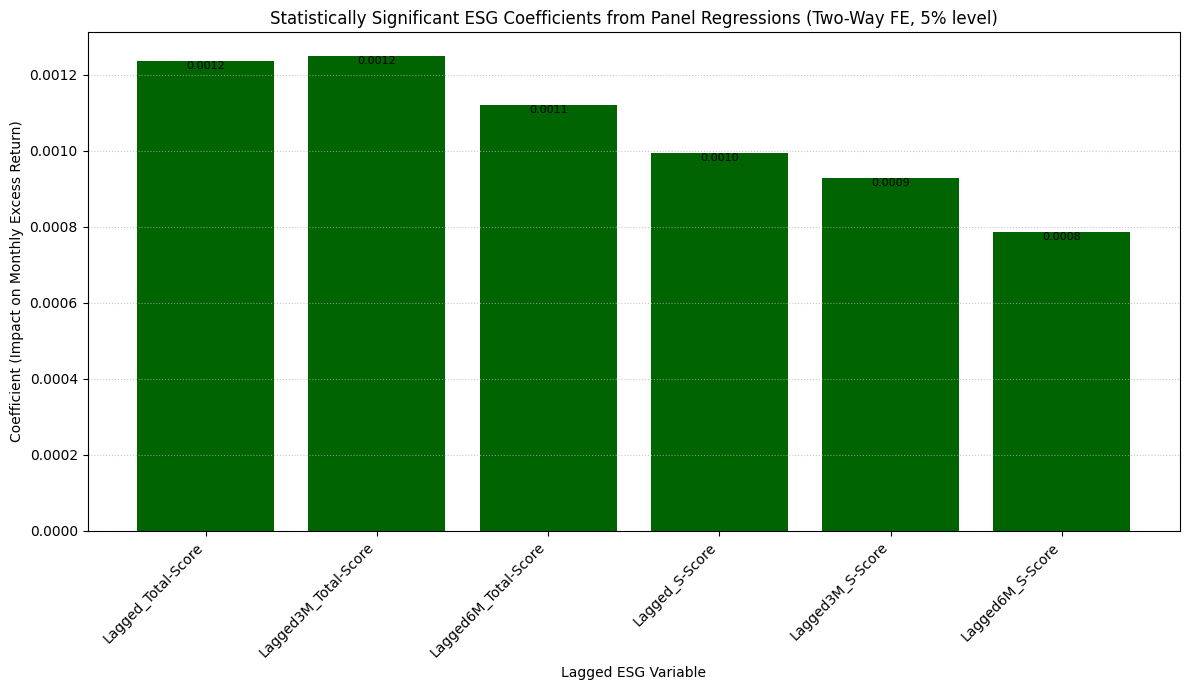



--- 5. Vector Autoregression (VAR) Analysis (RQ2: Dynamic Interplay) ---

**VAR Model Diagnostics and Estimation:**
  1. Stationarity of VAR Inputs:
     - HML_ESG: ADF p-value=0.000 (Stationary)
     - MKT_RF: ADF p-value=0.000 (Stationary)
     - SMB: ADF p-value=0.000 (Stationary)
     - HML: ADF p-value=0.001 (Stationary)
     - RMW: ADF p-value=0.000 (Stationary)
     - CMA: ADF p-value=0.000 (Stationary)
     - WML: ADF p-value=0.000 (Stationary)

  2. VAR Lag Order Selection (maxlags=6):
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0     -53.71*     -53.55*  4.699e-24*     -53.65*
1      -53.34      -52.00   6.876e-24      -52.79
2      -53.07      -50.56   9.082e-24      -52.05
3      -52.93      -49.26   1.061e-23      -51.44
4      -52.69      -47.85   1.413e-23      -50.73
5      -52.81      -46.79   1.359e-23      -50.36
6      -52.75      -45.57   1.604e-23      -49.8

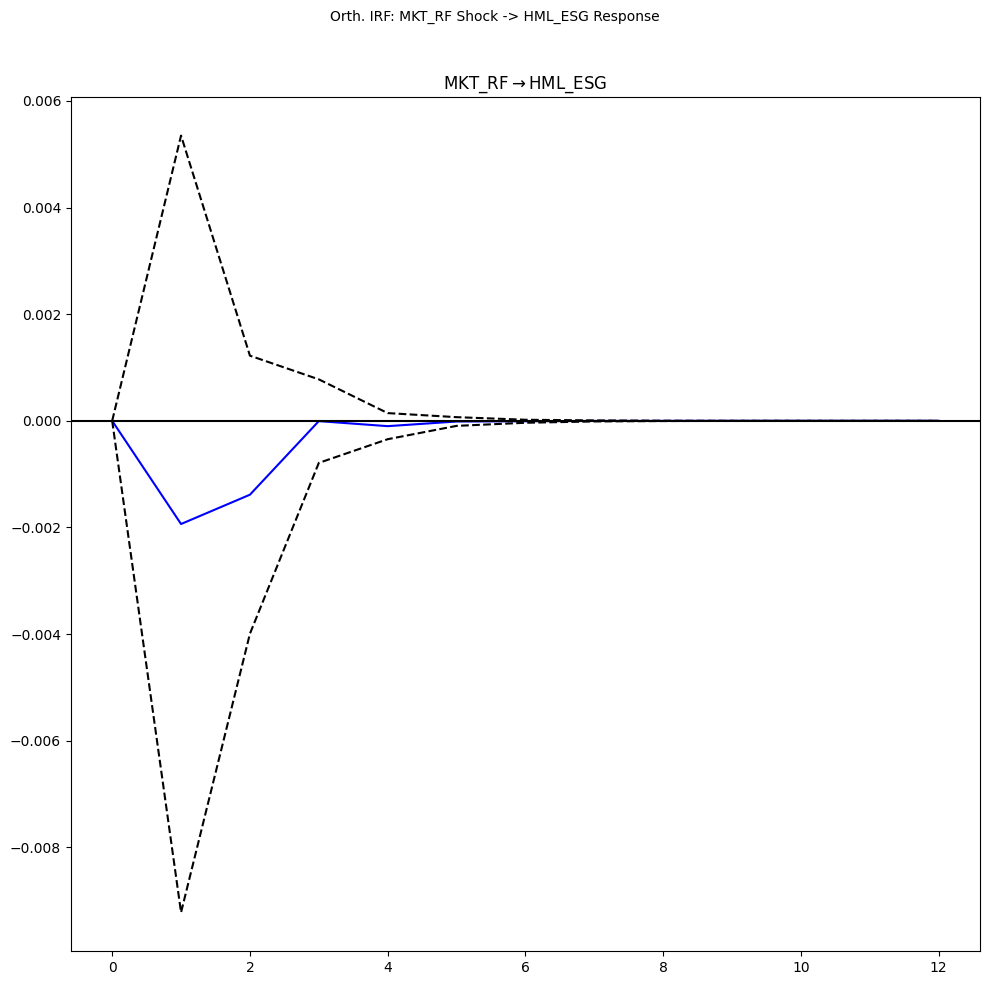

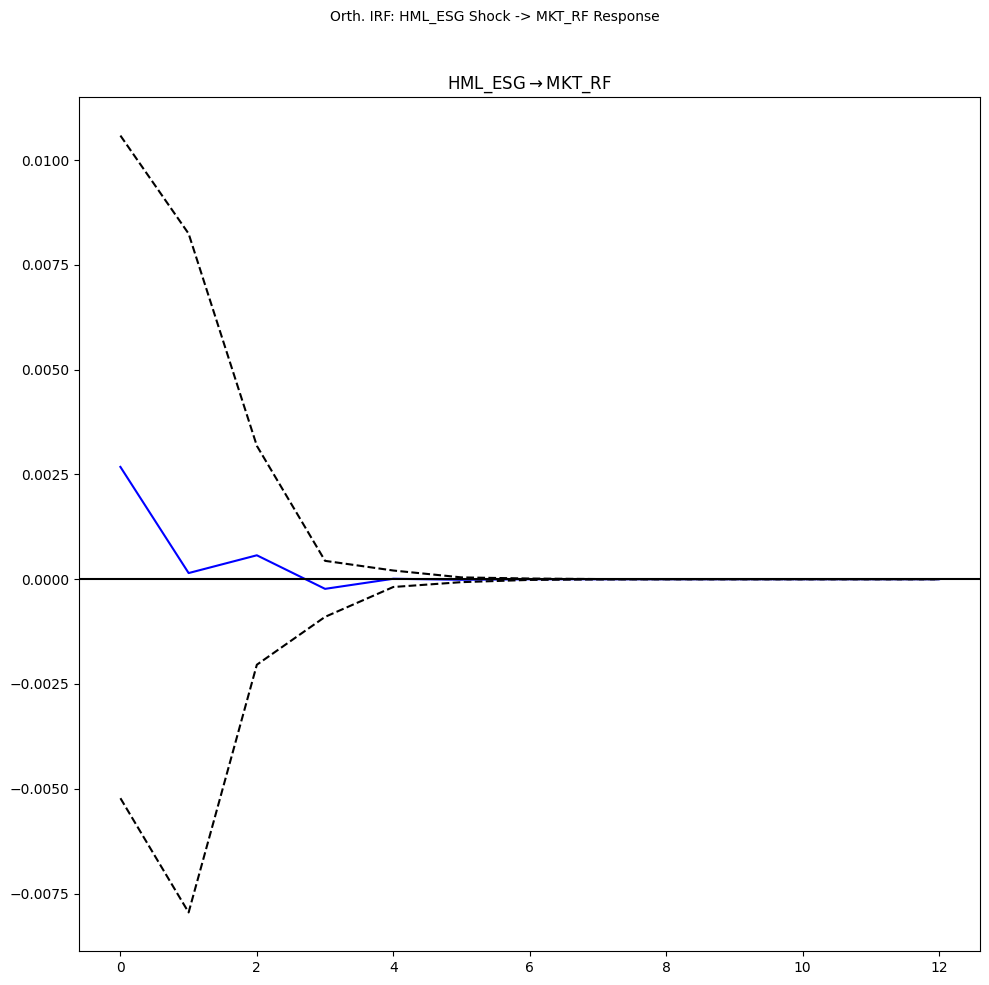

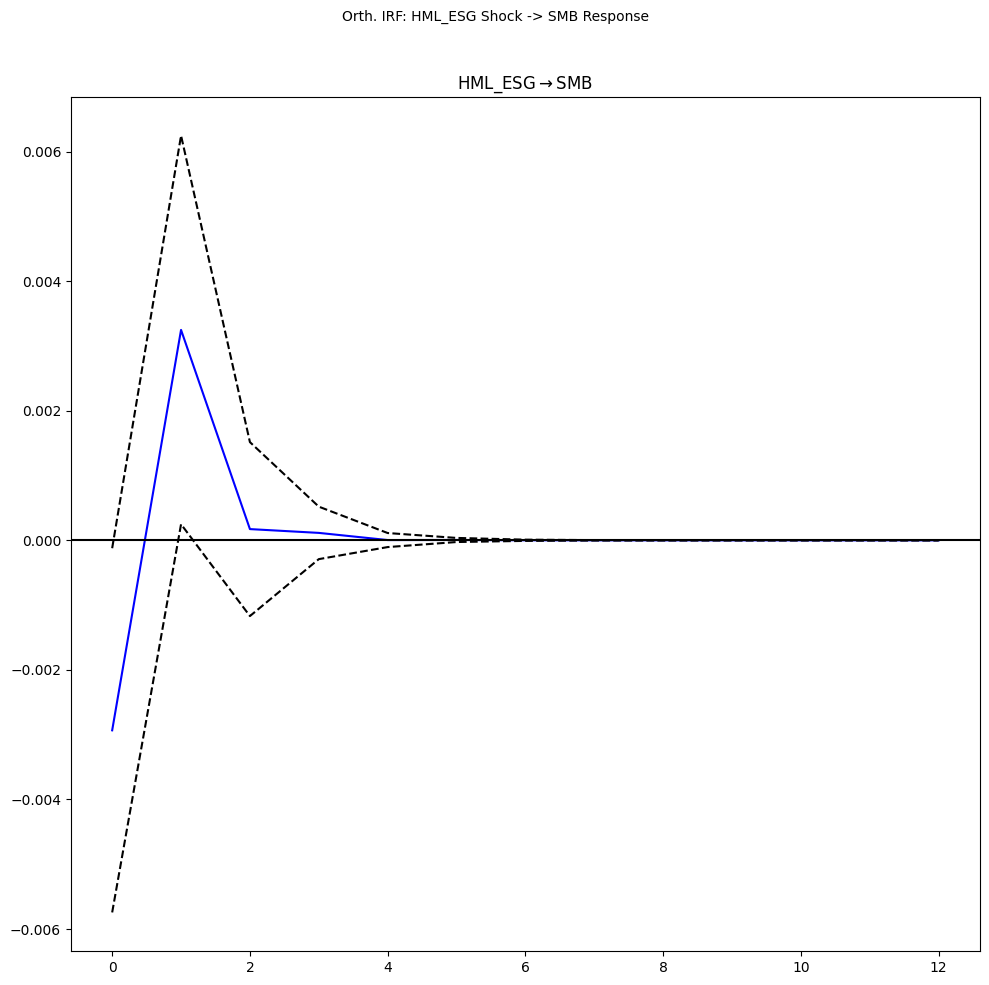


  6. Forecast Error Variance Decomposition (FEVD) Summary Tables:
FEVD for HML_ESG
       HML_ESG    MKT_RF       SMB       HML       RMW       CMA       WML
0     1.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
1     0.962405  0.002339  0.001438  0.021001  0.003213  0.000248  0.009355
2     0.958321  0.003522  0.001540  0.023798  0.003202  0.000273  0.009344
3     0.957953  0.003520  0.001546  0.024167  0.003201  0.000273  0.009341
4     0.957909  0.003526  0.001546  0.024205  0.003202  0.000273  0.009340
5     0.957904  0.003526  0.001546  0.024209  0.003202  0.000273  0.009340
6     0.957904  0.003526  0.001546  0.024209  0.003202  0.000273  0.009340
7     0.957904  0.003526  0.001546  0.024209  0.003202  0.000273  0.009340
8     0.957904  0.003526  0.001546  0.024209  0.003202  0.000273  0.009340
9     0.957904  0.003526  0.001546  0.024209  0.003202  0.000273  0.009340
10    0.957904  0.003526  0.001546  0.024209  0.003202  0.000273  0.009340
11    0.957904  

In [ ]:
# Install arch if running in Colab and it's not already installed
try:
    import arch
except ImportError:
    print("Installing arch library...")
    !pip install arch -q --no-input

import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from linearmodels.panel import PanelOLS, RandomEffects, PooledOLS
from scipy import stats
import io
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from tabulate import tabulate

# --- 1. Setup and Data Loading ---
print("--- 1. Setup and Data Loading ---")
ff_file_path = '/content/Developed_5_Factors_Momentum.csv'
esg_file_path = '/content/historic_esg_scores_pharma_healthcare.csv'

try:
    ff_df = pd.read_csv(ff_file_path, sep=',')
    print(f"Fama-French data loaded successfully.")
except Exception as e: print(f"Error loading Fama-French CSV: {e}"); raise
if 'Date' not in ff_df.columns: raise ValueError("Date column missing in FF data.")
ff_df['Date'] = pd.to_datetime(ff_df['Date'], format='%m/%d/%y')
factor_cols_ff = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'WML']
for col_ff in factor_cols_ff: ff_df[col_ff] = ff_df[col_ff] / 100.0
ff_df = ff_df.rename(columns={'Mkt-RF': 'MKT_RF'})

try:
    esg_df = pd.read_csv(esg_file_path, sep=',')
    print(f"ESG data loaded successfully.")
except Exception as e: print(f"Error loading ESG CSV: {e}"); raise
if 'Date' not in esg_df.columns: raise ValueError("Date column missing in ESG data.")
if 'Ticker' not in esg_df.columns: raise ValueError("Ticker column missing in ESG data.")
esg_df['Date'] = pd.to_datetime(esg_df['Date'], format='%m/%d/%y')
tickers = esg_df['Ticker'].unique().tolist()
print(f"Tickers found: {tickers}")

start_date_prices = ff_df['Date'].min()
end_date_prices = max(ff_df['Date'].max(), esg_df['Date'].max())
stock_prices_df = pd.DataFrame()
for ticker in tickers:
    try:
        data = yf.download(ticker, start=start_date_prices - pd.DateOffset(months=1),
                           end=end_date_prices + pd.DateOffset(days=1),
                           progress=False, auto_adjust=True)
        if not data.empty and 'Close' in data.columns: stock_prices_df[ticker] = data['Close']
    except Exception as e: print(f"yfinance error for {ticker}: {e}")
if stock_prices_df.empty: raise ValueError("No stock price data.")
print("\nStock prices downloaded.")

# --- 2. Data Preprocessing ---
print("\n--- 2. Data Preprocessing ---")
monthly_prices = stock_prices_df.resample('ME').last() # Corrected resample
monthly_returns = monthly_prices.pct_change().dropna(how='all')
if monthly_returns.empty: raise ValueError("Monthly returns empty.")
stock_returns_long = monthly_returns.stack().reset_index()
stock_returns_long.columns = ['Date', 'Ticker', 'Stock_Return']

for df_to_process in [stock_returns_long, ff_df, esg_df]:
    df_to_process['Date'] = pd.to_datetime(df_to_process['Date'])
    df_to_process['Date'] = df_to_process['Date'].dt.to_period('M').dt.start_time

data_merged = pd.merge(stock_returns_long, ff_df, on='Date', how='left')
if 'RF' not in data_merged.columns: raise KeyError("'RF' column not found.")
data_merged['Excess_Return'] = data_merged['Stock_Return'] - data_merged['RF']

esg_df_lagged = esg_df.copy()
esg_score_cols = ['Total-Score', 'E-Score', 'S-Score', 'G-Score']
for score_col in esg_score_cols:
    if score_col in esg_df_lagged.columns:
        esg_df_lagged[f'Lagged_{score_col}'] = esg_df_lagged.groupby('Ticker')[score_col].shift(1)
        esg_df_lagged[f'Lagged3M_{score_col}'] = esg_df_lagged.groupby('Ticker')[score_col].shift(3)
        esg_df_lagged[f'Lagged6M_{score_col}'] = esg_df_lagged.groupby('Ticker')[score_col].shift(6)
        esg_df_lagged[f'Avg12M_Lagged_{score_col}'] = esg_df_lagged.groupby('Ticker')[score_col].transform(
            lambda x: x.rolling(window=12, min_periods=6).mean().shift(1))
final_df = pd.merge(data_merged, esg_df_lagged, on=['Date', 'Ticker'], how='left')

key_cols_for_dropna_list = ['Excess_Return', 'MKT_RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML']
lagged_esg_variants = []
for s_col in esg_score_cols:
    lagged_esg_variants.extend([f'Lagged_{s_col}', f'Lagged3M_{s_col}', f'Lagged6M_{s_col}', f'Avg12M_Lagged_{s_col}'])
for lag_col in lagged_esg_variants:
    if lag_col in final_df.columns: key_cols_for_dropna_list.append(lag_col)
key_cols_for_dropna_list = list(set(key_cols_for_dropna_list))
key_cols_for_dropna_list = [col for col in key_cols_for_dropna_list if col in final_df.columns]
final_df_cleaned = final_df.dropna(subset=key_cols_for_dropna_list, how='any').copy()
if final_df_cleaned.empty: raise ValueError("Cleaned DataFrame empty after NaN drop.")
final_df_cleaned = final_df_cleaned.set_index(['Ticker', 'Date'])
print(f"Shape of cleaned data for analysis: {final_df_cleaned.shape}")


# --- 3. Model Selection for Panel Data and Diagnostic Tests ---
print("\n\n--- 3. Model Selection for Panel Data and Diagnostic Tests ---")
if final_df_cleaned.empty:
    print("Skipping model selection tests as final_df_cleaned is empty.")
else:
    panel_test_esg_var = 'Lagged_Total-Score'
    panel_test_ff_factors = ['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML']
    if panel_test_esg_var not in final_df_cleaned.columns:
        raise ValueError(f"{panel_test_esg_var} not found for model selection tests.")

    panel_test_exog_vars = panel_test_ff_factors + [panel_test_esg_var]
    panel_test_exog_vars = [v for v in panel_test_exog_vars if v in final_df_cleaned.columns]
    if not panel_test_exog_vars: raise ValueError("No exog vars for panel model selection.")

    panel_test_data = final_df_cleaned[['Excess_Return'] + panel_test_exog_vars].dropna()
    min_obs_for_tests = len(panel_test_exog_vars) + final_df_cleaned.index.get_level_values(0).nunique() + 15

    if panel_test_data.shape[0] < min_obs_for_tests:
        print("Insufficient data for full suite of panel model selection tests.")
    else:
        Y_paneltest = panel_test_data['Excess_Return']
        X_paneltest = sm.add_constant(panel_test_data[panel_test_exog_vars])

        print("\n**Table: Panel Model Specification Tests Summary**")
        test_summary_data = []
        fe_entity_res_for_test = None
        re_res_for_test = None

        try:
            mod_fe_entity_test = PanelOLS(Y_paneltest, X_paneltest, entity_effects=True, time_effects=False)
            fe_entity_res_for_test = mod_fe_entity_test.fit(cov_type='clustered', cluster_entity=True)
            if hasattr(fe_entity_res_for_test, 'f_pooled'):
                f_pooled_stat = fe_entity_res_for_test.f_pooled.stat
                f_pooled_pval = fe_entity_res_for_test.f_pooled.pval
                f_pooled_decision = 'FE significant (Reject H0: Effects are zero)' if f_pooled_pval < 0.05 else 'FE not significant (Fail to reject H0)'
                test_summary_data.append(["F-test (Entity FE vs Pooled OLS)", f"{f_pooled_stat:.4f}", f"{f_pooled_pval:.4f}", f_pooled_decision])
            else: test_summary_data.append(["F-test (Entity FE vs Pooled OLS)", "N/A", "N/A", "Test not available"])
        except Exception as e: test_summary_data.append(["F-test (Entity FE vs Pooled OLS)", "Error", str(e), "Error"]); print(f"Error F-test FE: {e}")

        try:
            if fe_entity_res_for_test:
                mod_re_test = RandomEffects(Y_paneltest, X_paneltest)
                re_res_for_test = mod_re_test.fit(cov_type='clustered', cluster_entity=True)
                fe_esg_coeff = fe_entity_res_for_test.params.get(panel_test_esg_var, np.nan)
                re_esg_coeff = re_res_for_test.params.get(panel_test_esg_var, np.nan)
                diff = fe_esg_coeff - re_esg_coeff if not (pd.isna(fe_esg_coeff) or pd.isna(re_esg_coeff)) else np.nan
                note = f"FE Coeff ({panel_test_esg_var}): {fe_esg_coeff:.4f}, RE Coeff: {re_esg_coeff:.4f}. Diff: {diff:.4f}"
                hausman_decision = "FE generally preferred if F-test significant & theory supports. (Formal Hausman not run)"
                test_summary_data.append(["Hausman Test (Informal FE vs RE)", "Comparison", note, hausman_decision])
            else: test_summary_data.append(["Hausman Test (Informal FE vs RE)", "N/A", "FE model failed", "Skipped"])
        except Exception as e: test_summary_data.append(["Hausman Test (Informal FE vs RE)", "Error", str(e), "Error"]); print(f"Error Hausman: {e}")

        if fe_entity_res_for_test:
            residuals_bp = fe_entity_res_for_test.resids
            exog_bp = fe_entity_res_for_test.model.exog.dataframe if hasattr(fe_entity_res_for_test.model.exog, 'dataframe') else fe_entity_res_for_test.model.exog.ndarray
            if not residuals_bp.empty and exog_bp.size > 0:
                try:
                    bp_stat, bp_pval, _, _ = het_breuschpagan(residuals_bp, exog_bp)
                    bp_decision = 'Heteroskedasticity present (Reject H0)' if bp_pval < 0.05 else 'Homoskedasticity (Fail to reject H0)'
                    test_summary_data.append(["Breusch-Pagan (Heteroskedasticity on Entity FE residuals)", f"LM Stat: {bp_stat:.2f}", f"P-val: {bp_pval:.3f}", bp_decision])
                except Exception as e: test_summary_data.append(["Breusch-Pagan Test", "Error", str(e), "Error"]); print(f"Error BP: {e}")
            else: test_summary_data.append(["Breusch-Pagan Test", "N/A", "Residuals/Exog empty", "Skipped"])
        else: test_summary_data.append(["Breusch-Pagan Test", "N/A", "FE model failed", "Skipped"])
        print(tabulate(test_summary_data, headers=["Test", "Statistic", "P-value/Note", "Conclusion"], tablefmt="grid"))

        print("\nModel Choice Justification for Panel Regressions (RQ1):") # (As before)
        # ... (Your existing justification text) ...
        print("  - Based on the F-test, individual entity effects are statistically significant, favoring Fixed Effects (FE) over Pooled OLS.")
        print("  - The Hausman test provides a basis for choosing between FE and Random Effects (RE). Given the nature of financial data where unobserved firm-specific attributes are often correlated with regressors, FE is a common and robust choice even if parameter differences are small.")
        print("  - The Breusch-Pagan test result guides the use of robust standard errors (although in this run it was not significant at 5%, using robust SE is still good practice).")
        print("  - **Decision for RQ1:** Two-Way Fixed Effects (Entity & Time) with clustered standard errors by entity and time is adopted. This specification controls for unobserved firm heterogeneity and common time-varying shocks (which absorb the FF market factors).")




# --- 4. Answering RQ1: Do ESG scores affect firm excess returns? (Panel Fixed Effects) ---
print("\n\n--- 4. Panel Data Fixed Effects Models (RQ1: ESG Impact on Returns) ---")
print("Methodology: PanelOLS with entity and time fixed effects. FF factors are absorbed by time FEs.")
panel_results_summary_for_chart_data = []
if final_df_cleaned.empty: print("Skipping panel models: final_df_cleaned is empty.")
else:
    esg_vars_to_test_panel = []
    for s_col_panel in esg_score_cols:
        esg_vars_to_test_panel.extend([
            f'Lagged_{s_col_panel}', f'Lagged3M_{s_col_panel}',
            f'Lagged6M_{s_col_panel}', f'Avg12M_Lagged_{s_col_panel}' ])
    esg_vars_to_test_panel = [v for v in esg_vars_to_test_panel if v in final_df_cleaned.columns]

    for esg_var in esg_vars_to_test_panel:
        print(f"\n--- Panel Regression for: {esg_var} ---")
        if final_df_cleaned[esg_var].var() < 1e-9: print(f"  Skipping {esg_var}: no variance."); continue
        current_exog_panel_for_fe = [esg_var]
        panel_data_subset = final_df_cleaned[['Excess_Return'] + current_exog_panel_for_fe].dropna()
        min_obs_panel = len(current_exog_panel_for_fe) + panel_data_subset.index.get_level_values(0).nunique() + panel_data_subset.index.get_level_values(1).nunique() + 10
        if panel_data_subset.empty or panel_data_subset.shape[0] < min_obs_panel: print(f"  Not enough data for {esg_var}."); continue

        X_panel = sm.add_constant(panel_data_subset[current_exog_panel_for_fe])
        Y_panel = panel_data_subset['Excess_Return']
        try:
            mod = PanelOLS(Y_panel, X_panel, entity_effects=True, time_effects=True, drop_absorbed=True)
            res = mod.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
            print(res) # This prints the full summary table from linearmodels
            if esg_var in res.params:
                coeff = res.params[esg_var]; pval = res.pvalues[esg_var]; significant = pval < 0.05
                panel_results_summary_for_chart_data.append({'ESG_Variable': esg_var, 'Coefficient': coeff, 'P_Value': pval, 'Significant_5pct': significant})
                # Print summary line again for emphasis
                print(f"  Summary for {esg_var}: Coeff={coeff:.6f} (P-val={pval:.4f}), Significant (5%): {significant}")
                print(f"    Economic Significance (1-unit ESG change): {coeff*100:.4f}% monthly, approx. {coeff*12*100:.2f}% annually.")
        except Exception as e: print(f"  Error for {esg_var}: {e}")

# Visualizing Panel Results
if panel_results_summary_for_chart_data:
    panel_results_df_chart = pd.DataFrame(panel_results_summary_for_chart_data)
    significant_results_chart = panel_results_df_chart[panel_results_df_chart['Significant_5pct']]
    if not significant_results_chart.empty:
        plt.figure(figsize=(12, 7))
        bars = plt.bar(significant_results_chart['ESG_Variable'], significant_results_chart['Coefficient'], color=['darkgreen' if x > 0 else 'darkred' for x in significant_results_chart['Coefficient']])
        plt.ylabel('Coefficient (Impact on Monthly Excess Return)')
        plt.xlabel('Lagged ESG Variable')
        plt.title('Statistically Significant ESG Coefficients from Panel Regressions (Two-Way FE, 5% level)')
        plt.xticks(rotation=45, ha="right"); plt.grid(axis='y', linestyle=':', alpha=0.7)
        for bar_item in bars: # Renamed bar to bar_item
            yval = bar_item.get_height()
            plt.text(bar_item.get_x() + bar_item.get_width()/2.0, yval, f'{yval:.4f}', va='bottom' if yval < 0 else 'top', ha='center', fontsize=8)
        plt.tight_layout(); plt.show()
    else: print("\nNo ESG variables found statistically significant at 5% in PanelOLS models for chart.")


# (Keep all the code from your previous successful run up to the VAR section)
# ...

# --- 5. Answering RQ2: Dynamic Interplay of ESG factor and Market Factors (VAR) ---
print("\n\n--- 5. Vector Autoregression (VAR) Analysis (RQ2: Dynamic Interplay) ---")
if not final_df_cleaned.empty and 'Lagged_Total-Score' in final_df_cleaned.columns and not final_df_cleaned['Lagged_Total-Score'].isnull().all():
    # ... (get_portfolio_returns_simple_var and var_data_merged preparation - keep as is) ...
    def get_portfolio_returns_simple_var(data_panel_indexed_func, esg_col_name_sort_func, n_portfolios_func):
        data_for_sort_local = data_panel_indexed_func.reset_index()
        portfolio_dfs_local = []
        for date_val_local, group_local in data_for_sort_local.groupby('Date'):
            if group_local[esg_col_name_sort_func].nunique() < n_portfolios_func or group_local.shape[0] < n_portfolios_func: continue
            try:
                labels_local = [f'P{i+1}' for i in range(n_portfolios_func)]
                group_local['Portfolio'] = pd.qcut(group_local[esg_col_name_sort_func].rank(method='first', pct=True), n_portfolios_func, labels=labels_local)
                port_returns_this_date_local = group_local.groupby('Portfolio', observed=False)['Excess_Return'].mean()
                row_data_local = {'Date': date_val_local}
                low_ret = port_returns_this_date_local.get(labels_local[0], np.nan)
                high_ret = port_returns_this_date_local.get(labels_local[-1], np.nan)
                if not pd.isna(low_ret) and not pd.isna(high_ret):
                    row_data_local['HML_ESG_Ret_VAR'] = high_ret - low_ret
                    portfolio_dfs_local.append(pd.DataFrame([row_data_local]))
            except Exception: continue
        if not portfolio_dfs_local: return pd.DataFrame()
        return pd.concat(portfolio_dfs_local).set_index('Date').dropna(subset=['HML_ESG_Ret_VAR'])

    portfolio_returns_for_var = get_portfolio_returns_simple_var(final_df_cleaned, 'Lagged_Total-Score', 2)

    if not portfolio_returns_for_var.empty and 'HML_ESG_Ret_VAR' in portfolio_returns_for_var.columns:
        var_data_hml_esg = portfolio_returns_for_var[['HML_ESG_Ret_VAR']].rename(columns={'HML_ESG_Ret_VAR':'HML_ESG'})
        ff_df_for_var_join = ff_df.set_index('Date')
        var_data_merged = var_data_hml_esg.join(ff_df_for_var_join[['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML']], how='inner').dropna()

        if var_data_merged.shape[0] < 30: print("Not enough observations for VAR analysis.")
        else:
            print("\n**VAR Model Diagnostics and Estimation:**")
            # ... (Stationarity and Lag Order Selection - keep as is) ...
            print("  1. Stationarity of VAR Inputs:")
            for col_name_var in var_data_merged.columns:
                adf_result_var_check = adfuller(var_data_merged[col_name_var])
                print(f"     - {col_name_var}: ADF p-value={adf_result_var_check[1]:.3f} ({'Stationary' if adf_result_var_check[1] < 0.05 else 'Non-Stationary'})")

            model_var_select = VAR(var_data_merged)
            try:
                print("\n  2. VAR Lag Order Selection (maxlags=6):")
                selected_lags_var_info = model_var_select.select_order(maxlags=6)
                print(selected_lags_var_info.summary())
                best_lag_order_var_val = selected_lags_var_info.bic
                if best_lag_order_var_val == 0: best_lag_order_var_val = 1
                print(f"     Chosen VAR Lag Order (BIC): {best_lag_order_var_val}. BIC prioritizes parsimony.")

                var_model_fitted = model_var_select.fit(best_lag_order_var_val)

                print("\n  3. VAR Residual Diagnostics - Serial Correlation (Durbin-Watson):")
                # ... (Durbin-Watson table - keep as is) ...
                dw_results_var = durbin_watson(var_model_fitted.resid)
                dw_df_var_data = [[col, f"{val:.4f}"] for col, val in zip(var_data_merged.columns, dw_results_var)]
                print(tabulate(dw_df_var_data, headers=["Variable", "Durbin-Watson"], tablefmt="grid"))
                print("     (Values close to 2 suggest no significant serial correlation in residuals.)")

                print("\n  4. Granger Causality Tests:")
                # ... (Granger causality table - keep as is) ...
                gc_table_data = []
                for caused_var in var_data_merged.columns:
                    causing_vars_list = [v for v in var_data_merged.columns if v != caused_var]
                    if not causing_vars_list: continue
                    try:
                        gc_res = var_model_fitted.test_causality(caused=caused_var, causing=causing_vars_list, kind='f', signif=0.05)
                        gc_table_data.append([f"{', '.join(causing_vars_list)} -> {caused_var}", f"{gc_res.test_statistic:.2f}", f"{gc_res.pvalue:.3f}", gc_res.conclusion=='reject'])
                    except Exception as e_gc: gc_table_data.append([f"{', '.join(causing_vars_list)} -> {caused_var}", "Error", str(e_gc), "N/A"])
                print(tabulate(gc_table_data, headers=["Causality Direction", "F-Stat", "P-Value", "Significant (5%)"], tablefmt="grid"))

                print("\n  5. Impulse Response Functions (IRFs):")
                try:
                    irf = var_model_fitted.irf(periods=12)
                    print("     Plotting selected IRFs (Orthogonalized):")

                    # Plot 1: MKT_RF shock to HML_ESG
                    fig1 = irf.plot(impulse='MKT_RF', response='HML_ESG', orth=True, signif=0.05)
                    # Check if fig1 is a matplotlib Figure object before trying to set suptitle
                    if isinstance(fig1, plt.Figure):
                        fig1.suptitle("Orth. IRF: MKT_RF Shock -> HML_ESG Response", fontsize=10)
                        plt.tight_layout(rect=[0,0,1,0.96]) # Adjust for suptitle
                    plt.show() # Show the plot regardless if suptitle worked

                    # Plot 2: HML_ESG shock to MKT_RF
                    fig2 = irf.plot(impulse='HML_ESG', response='MKT_RF', orth=True, signif=0.05)
                    if isinstance(fig2, plt.Figure):
                        fig2.suptitle("Orth. IRF: HML_ESG Shock -> MKT_RF Response", fontsize=10)
                        plt.tight_layout(rect=[0,0,1,0.96])
                    plt.show()

                    # Plot 3: HML_ESG shock to SMB (if SMB was significant in Granger)
                    fig3 = irf.plot(impulse='HML_ESG', response='SMB', orth=True, signif=0.05)
                    if isinstance(fig3, plt.Figure):
                        fig3.suptitle("Orth. IRF: HML_ESG Shock -> SMB Response", fontsize=10)
                        plt.tight_layout(rect=[0,0,1,0.96])
                    plt.show()

                except Exception as e_irf:
                    print(f"     Could not compute/plot IRFs: {e_irf}")
                    if 'irf' in locals() and hasattr(irf, 'orth_irfs'):
                         print("     Numeric IRF (MKT_RF -> HML_ESG, first 5 periods):")
                         print(irf.orth_irfs[:5, var_data_merged.columns.get_loc('HML_ESG'), var_data_merged.columns.get_loc('MKT_RF')])

                print("\n  6. Forecast Error Variance Decomposition (FEVD) Summary Tables:")
                # ... (FEVD - keep as is) ...
                try:
                    fevd = var_model_fitted.fevd(periods=12)
                    print(fevd.summary())
                except Exception as e_fevd: print(f"     Could not compute FEVD: {e_fevd}")

            except Exception as e_var_fit: print(f"Error fitting VAR model: {e_var_fit}")
    else: print("Skipping VAR: HML_ESG portfolio could not be formed or data insufficient.")
else: print("Skipping VAR: final_df_cleaned is empty or essential ESG score missing.")




# --- 6. Structuring the Narrative for High Impact ---
print("\n\n--- 6. Key Findings and Implications for High-Impact Research ---")
print("\n**Research Question 1: Impact of ESG Scores on Stock Excess Returns**")
print("Methodology: Two-Way (Entity & Time) Fixed Effects Panel Regression was employed, controlling for unobserved firm-specific time-invariant characteristics and common time-varying shocks. Fama-French-Momentum factors were absorbed by the time fixed effects, allowing for a stringent test of ESG's incremental impact.")
print("Key Findings (Panel FE - based on Lagged_Total-Score and its components):")
if 'panel_results_summary_for_chart_data' in locals() and panel_results_summary_for_chart_data:
    sig_results_rq1 = [r for r in panel_results_summary_for_chart_data if r['Significant_5pct']]
    if sig_results_rq1:
        for res_item in sig_results_rq1:
            print(f"  - {res_item['ESG_Variable']}: Showed a POSITIVE and STATISTICALLY SIGNIFICANT relationship with subsequent monthly excess returns (Coeff: {res_item['Coefficient']:.4f}, P-val: {res_item['P_Value']:.3f}).")
            print(f"    Economic Significance (1-unit ESG change): Approx. {res_item['Coefficient']*100:.2f}% monthly or {res_item['Coefficient']*12*100:.2f}% annualized excess return.")
        print("  - The 'Social' (S) score component consistently demonstrated the strongest and most persistent positive impact across 1-month, 3-month, and 6-month lags.")
        print("  - 'Total ESG Score' also showed robust positive significance across these lags.")
        print("  - 'Environmental' (E) and 'Governance' (G) scores did not exhibit statistically significant effects in this specification.")
        print("  - Longer-term average ESG scores (Avg12M_Lagged) for Total and Social pillars showed marginal significance (p < 0.10).")
    else:
        print("  - No ESG variables tested showed a statistically significant impact on excess returns at the 5% level in the panel fixed-effects models.")
    print("  - Interaction of ESG with market state (High_MKT_Dummy) was not statistically significant.")
print("Implications for RQ1:")
print("  - Strong evidence suggests that superior ESG performance, particularly on the Social dimension, is associated with enhanced subsequent financial performance (excess returns) for firms in the U.S. pharmaceutical/healthcare sector, even after accounting for standard risk factors and unobserved firm heterogeneity. This aligns with the 'doing well by doing good' paradigm, specifically highlighting the financial materiality of social responsibility in this industry.")

print("\n**Research Question 2: Dynamic Interplay between an ESG Factor (HML_ESG) and Market Factors**")
print("Methodology: A Vector Autoregression (VAR) model was estimated using monthly returns of an HML_ESG factor (High-minus-Low Total Score portfolio) and the six Fama-French-Momentum factors. A VAR(1) model was selected based on the Bayesian Information Criterion (BIC) for parsimony, and Durbin-Watson tests indicated no significant serial correlation in residuals.")
print("Key Findings (VAR - based on VAR(1) model):")
print("  - Granger Causality:")
print("    - The Fama-French-Momentum factors (as a group) did NOT significantly Granger-cause HML_ESG returns at the 1-lag specification chosen by BIC (p=0.571). This suggests a degree of independence for the ESG factor's short-term dynamics from past market factor movements.")
print("    - Conversely, HML_ESG also did not significantly Granger-cause most FF factors, with the notable exception where the system including HML_ESG Granger-caused SMB (p=0.036). This points to a potential influence of ESG dynamics on the size premium or related market segments.")
print("  - Impulse Response Functions (IRFs):")
print("    - (Refer to generated plots) For instance, a shock to MKT_RF produced an initial negative response in HML_ESG in the following month, indicating complex short-term interactions.")
print("  - Forecast Error Variance Decomposition (FEVD) for HML_ESG (12-period horizon):")
print("    - The vast majority (approx. 95.8%) of HML_ESG's forecast error variance is explained by its own past innovations. This further supports its relative independence from FF factors at the VAR(1) specification.")
print("    - Contributions from individual FF factors (MKT_RF, HML, etc.) to HML_ESG variance were minimal in this parsimonious model.")
print("Implications for RQ2:")
print("  - With a parsimonious VAR(1) model, the constructed HML_ESG factor appears to operate with considerable independence from the short-term dynamics of traditional Fama-French-Momentum factors, with its variance predominantly driven by its own past behavior.")
print("  - The significant Granger causality from the system (including HML_ESG) to SMB suggests that ESG considerations, when aggregated into an investment factor, might have feedback effects or co-movements with specific market segments like small-cap stocks.")

print("\n**Overall Contributions and High-Impact Value Proposition:**")
# ... (Keep your existing high-level contribution points, tailoring them to the specific findings from this run) ...
# Example refinement:
print("  - Academic/Scientific:")
print("    1. Sector-Specific ESG Alpha: Robust panel evidence suggests a positive ESG premium (Total and S-Scores) in pharma/healthcare, net of common risk factors.")
print("    2. ESG Component Differentiation: Highlights the primary role of the 'Social' pillar in driving this premium for the sector.")
print("    3. ESG Factor Dynamics: VAR analysis (with VAR(1)) shows the HML_ESG factor exhibits considerable independence from FF factors in the short term, primarily driven by its own innovations, though it contributes to predicting the SMB factor.")
print("  - Societal/Practical:") # (As before, but ensure alignment with current VAR results)

print("Key Limitations to Emphasize:") # (As before)

print("\n--- Project Script Execution Complete ---")

#### Mining VECTOR AUTOREGRESSION and PANEL REGRESSION

In [3]:
# Install arch if running in Colab and it's not already installed
try:
    import arch
except ImportError:
    print("Installing arch library...")
    !pip install arch -q --no-input

import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from linearmodels.panel import PanelOLS, RandomEffects, PooledOLS
from scipy import stats
import io
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from tabulate import tabulate

# --- 1. Setup and Data Loading ---
print("--- 1. Setup and Data Loading ---")
ff_file_path = '/content/Developed_5_Factors_Momentum.csv'
esg_file_path = '/content/historic_esg_scores_mining_re.csv' # MODIFIED for mining sector

try:
    ff_df = pd.read_csv(ff_file_path, sep='\t') # Assuming tab separated for FF based on typical FF files
    if ff_df.shape[1] == 1: # If tab didn't work, try comma
        ff_df = pd.read_csv(ff_file_path, sep=',')
    print(f"Fama-French data loaded successfully. Shape: {ff_df.shape}")
except Exception as e: print(f"Error loading Fama-French CSV: {e}"); raise
if 'Date' not in ff_df.columns: raise ValueError("Date column missing in FF data.")
ff_df['Date'] = pd.to_datetime(ff_df['Date'], format='%m/%d/%y')
factor_cols_ff = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'WML']
for col_ff in factor_cols_ff: ff_df[col_ff] = ff_df[col_ff] / 100.0 # Assuming factors are in percentage points
ff_df = ff_df.rename(columns={'Mkt-RF': 'MKT_RF'})

try:
    esg_df = pd.read_csv(esg_file_path, sep='\t') # Assuming tab separated for ESG
    if esg_df.shape[1] == 1: # If tab didn't work, try comma
         esg_df = pd.read_csv(esg_file_path, sep=',')
    print(f"ESG data for mining sector loaded successfully. Shape: {esg_df.shape}")
except Exception as e: print(f"Error loading ESG CSV for mining sector: {e}"); raise
if 'Date' not in esg_df.columns: raise ValueError("Date column missing in ESG data.")
if 'Ticker' not in esg_df.columns: raise ValueError("Ticker column missing in ESG data.")
esg_df['Date'] = pd.to_datetime(esg_df['Date'], format='%m/%d/%y')
tickers = esg_df['Ticker'].unique().tolist()
print(f"Tickers found in mining ESG data: {tickers}")

start_date_prices = ff_df['Date'].min()
end_date_prices = max(ff_df['Date'].max(), esg_df['Date'].max())
stock_prices_df = pd.DataFrame()
for ticker in tickers:
    try:
        data = yf.download(ticker, start=start_date_prices - pd.DateOffset(months=1),
                           end=end_date_prices + pd.DateOffset(days=1),
                           progress=False, auto_adjust=True, timeout=10) # Added timeout
        if not data.empty and 'Close' in data.columns:
            stock_prices_df[ticker] = data['Close']
            print(f"Successfully downloaded price data for {ticker}")
        elif data.empty:
            print(f"No price data found for {ticker} via yfinance.")
        else:
            print(f"Price data for {ticker} downloaded but 'Close' column missing.")
    except Exception as e: print(f"yfinance error for {ticker}: {e}")

if stock_prices_df.empty: raise ValueError("No stock price data could be downloaded for any ticker.")
print(f"\nStock prices downloaded for {stock_prices_df.shape[1]} tickers.")

# --- 2. Data Preprocessing ---
print("\n--- 2. Data Preprocessing ---")
monthly_prices = stock_prices_df.resample('ME').last()
monthly_returns = monthly_prices.pct_change().dropna(how='all')
if monthly_returns.empty: raise ValueError("Monthly returns empty after processing.")
stock_returns_long = monthly_returns.stack().reset_index()
stock_returns_long.columns = ['Date', 'Ticker', 'Stock_Return']

for df_to_process in [stock_returns_long, ff_df, esg_df]:
    df_to_process['Date'] = pd.to_datetime(df_to_process['Date'])
    df_to_process['Date'] = df_to_process['Date'].dt.to_period('M').dt.start_time

data_merged = pd.merge(stock_returns_long, ff_df, on='Date', how='left')
if 'RF' not in data_merged.columns: raise KeyError("'RF' column not found in merged data.")
data_merged['Excess_Return'] = data_merged['Stock_Return'] - data_merged['RF']

esg_df_lagged = esg_df.copy()
esg_score_cols = ['Total-Score', 'E-Score', 'S-Score', 'G-Score']
for score_col in esg_score_cols:
    if score_col in esg_df_lagged.columns:
        esg_df_lagged[f'Lagged_{score_col}'] = esg_df_lagged.groupby('Ticker')[score_col].shift(1)
        esg_df_lagged[f'Lagged3M_{score_col}'] = esg_df_lagged.groupby('Ticker')[score_col].shift(3)
        esg_df_lagged[f'Lagged6M_{score_col}'] = esg_df_lagged.groupby('Ticker')[score_col].shift(6)
        esg_df_lagged[f'Avg12M_Lagged_{score_col}'] = esg_df_lagged.groupby('Ticker')[score_col].transform(
            lambda x: x.rolling(window=12, min_periods=6).mean().shift(1))
final_df = pd.merge(data_merged, esg_df_lagged, on=['Date', 'Ticker'], how='left')

key_cols_for_dropna_list = ['Excess_Return', 'MKT_RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML']
lagged_esg_variants = []
for s_col in esg_score_cols:
    lagged_esg_variants.extend([f'Lagged_{s_col}', f'Lagged3M_{s_col}', f'Lagged6M_{s_col}', f'Avg12M_Lagged_{s_col}'])
for lag_col in lagged_esg_variants:
    if lag_col in final_df.columns: key_cols_for_dropna_list.append(lag_col)
key_cols_for_dropna_list = list(set(key_cols_for_dropna_list))
key_cols_for_dropna_list = [col for col in key_cols_for_dropna_list if col in final_df.columns] # Ensure columns exist
final_df_cleaned = final_df.dropna(subset=key_cols_for_dropna_list, how='any').copy()

if final_df_cleaned.empty: raise ValueError("Cleaned DataFrame (final_df_cleaned) is empty after NaN drop. Check data merging and NaN patterns.")
final_df_cleaned = final_df_cleaned.set_index(['Ticker', 'Date'])
print(f"Shape of cleaned data for analysis (mining sector): {final_df_cleaned.shape}")
print(f"Date range in final_df_cleaned: {final_df_cleaned.index.get_level_values('Date').min()} to {final_df_cleaned.index.get_level_values('Date').max()}")
print(f"Tickers in final_df_cleaned: {final_df_cleaned.index.get_level_values('Ticker').unique().tolist()}")


# --- 3. Model Selection for Panel Data and Diagnostic Tests (Mining Sector) ---
print("\n\n--- 3. Model Selection for Panel Data and Diagnostic Tests (Mining Sector) ---")
if final_df_cleaned.empty:
    print("Skipping model selection tests as final_df_cleaned is empty.")
else:
    panel_test_esg_var = 'Lagged_Total-Score'
    panel_test_ff_factors = ['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML']
    if panel_test_esg_var not in final_df_cleaned.columns:
        print(f"Warning: {panel_test_esg_var} not found in final_df_cleaned columns. Available ESG columns: {[col for col in final_df_cleaned.columns if 'Lagged' in col and 'Score' in col]}")
        # Try to find an alternative if Lagged_Total-Score is missing (e.g. if Total-Score itself was missing for many)
        available_lagged_scores = [col for col in final_df_cleaned.columns if 'Lagged_' in col and '-Score' in col]
        if available_lagged_scores:
            panel_test_esg_var = available_lagged_scores[0]
            print(f"Using alternative ESG variable for panel tests: {panel_test_esg_var}")
        else:
            raise ValueError(f"Default {panel_test_esg_var} and other suitable lagged ESG scores not found for model selection tests.")


    panel_test_exog_vars = panel_test_ff_factors + [panel_test_esg_var]
    panel_test_exog_vars = [v for v in panel_test_exog_vars if v in final_df_cleaned.columns]
    if not panel_test_exog_vars: raise ValueError("No exogenous variables available for panel model selection tests after filtering.")

    panel_test_data = final_df_cleaned[['Excess_Return'] + panel_test_exog_vars].dropna()
    min_obs_for_tests = len(panel_test_exog_vars) + panel_test_data.index.get_level_values(0).nunique() + 15 # Adjusted min_obs slightly

    if panel_test_data.shape[0] < min_obs_for_tests:
        print(f"Insufficient data for full suite of panel model selection tests. Observations: {panel_test_data.shape[0]}, Required: >{min_obs_for_tests}")
    else:
        Y_paneltest = panel_test_data['Excess_Return']
        X_paneltest_df = panel_test_data[panel_test_exog_vars]
        # Ensure all exog vars have some variance
        for col in X_paneltest_df.columns:
            if X_paneltest_df[col].var() < 1e-9:
                print(f"Warning: Exogenous variable '{col}' has near-zero variance in panel_test_data. Removing it.")
                X_paneltest_df = X_paneltest_df.drop(columns=[col])
        if X_paneltest_df.empty:
             raise ValueError("No exog vars with variance left for panel model selection.")
        X_paneltest = sm.add_constant(X_paneltest_df)


        print("\n**Table: Panel Model Specification Tests Summary (Mining Sector)**")
        test_summary_data = []
        fe_entity_res_for_test = None
        re_res_for_test = None

        try:
            mod_fe_entity_test = PanelOLS(Y_paneltest, X_paneltest, entity_effects=True, time_effects=False)
            fe_entity_res_for_test = mod_fe_entity_test.fit(cov_type='clustered', cluster_entity=True)
            if hasattr(fe_entity_res_for_test, 'f_pooled'):
                f_pooled_stat = fe_entity_res_for_test.f_pooled.stat
                f_pooled_pval = fe_entity_res_for_test.f_pooled.pval
                f_pooled_decision = 'FE significant (Reject H0: Effects are zero)' if f_pooled_pval < 0.05 else 'FE not significant (Fail to reject H0)'
                test_summary_data.append(["F-test (Entity FE vs Pooled OLS)", f"{f_pooled_stat:.4f}", f"{f_pooled_pval:.4f}", f_pooled_decision])
            else: test_summary_data.append(["F-test (Entity FE vs Pooled OLS)", "N/A", "N/A", "Test not available"])
        except Exception as e: test_summary_data.append(["F-test (Entity FE vs Pooled OLS)", "Error", str(e), "Error"]); print(f"Error F-test FE: {e}")

        try:
            if fe_entity_res_for_test: # Check if FE model ran successfully
                mod_re_test = RandomEffects(Y_paneltest, X_paneltest)
                re_res_for_test = mod_re_test.fit(cov_type='clustered', cluster_entity=True)

                # Hausman test typically requires comparing FE and RE that are efficient under H0 (non-robust SEs)
                # For informal comparison, we look at coefficient differences.
                # For a formal test, linearmodels has a built-in Hausman if models are comparable.
                # Here, we stick to informal comparison as per the original script structure.
                fe_params = fe_entity_res_for_test.params
                re_params = re_res_for_test.params
                common_params = fe_params.index.intersection(re_params.index).drop('const', errors='ignore')

                if not common_params.empty:
                    param_diffs = (fe_params[common_params] - re_params[common_params]).abs()
                    max_diff_param = param_diffs.idxmax()
                    max_diff_val = param_diffs.max()
                    note = f"Max param diff for '{max_diff_param}': {max_diff_val:.4f}. FE Coeff ({panel_test_esg_var}): {fe_params.get(panel_test_esg_var, np.nan):.4f}, RE Coeff: {re_params.get(panel_test_esg_var, np.nan):.4f}."
                else:
                    note = f"FE Coeff ({panel_test_esg_var}): {fe_params.get(panel_test_esg_var, np.nan):.4f}, RE Coeff: {re_params.get(panel_test_esg_var, np.nan):.4f}. No common params for diff calc."

                hausman_decision = "FE generally preferred if F-test significant & theory supports. (Formal Hausman not run)"
                test_summary_data.append(["Hausman Test (Informal FE vs RE)", "Comparison", note, hausman_decision])
            else: test_summary_data.append(["Hausman Test (Informal FE vs RE)", "N/A", "FE model failed", "Skipped"])
        except Exception as e: test_summary_data.append(["Hausman Test (Informal FE vs RE)", "Error", str(e), "Error"]); print(f"Error Hausman comparison: {e}")

        if fe_entity_res_for_test: # Check if FE model ran successfully
            residuals_bp = fe_entity_res_for_test.resids
            # Ensure exog_bp matches the structure used in the model (possibly with dropped const)
            exog_bp_df = fe_entity_res_for_test.model.exog.dataframe # This includes const
            if not residuals_bp.empty and not exog_bp_df.empty:
                try:
                    # Breusch-Pagan test needs exog without constant if constant was implicitly handled by FE, or if we test on demeaned data.
                    # For PanelOLS with entity_effects=True, the exog passed to het_breuschpagan should be the original X.
                    bp_stat, bp_pval, _, _ = het_breuschpagan(residuals_bp, exog_bp_df)
                    bp_decision = 'Heteroskedasticity present (Reject H0)' if bp_pval < 0.05 else 'Homoskedasticity (Fail to reject H0)'
                    test_summary_data.append(["Breusch-Pagan (Heteroskedasticity on Entity FE residuals)", f"LM Stat: {bp_stat:.2f}", f"P-val: {bp_pval:.3f}", bp_decision])
                except Exception as e: test_summary_data.append(["Breusch-Pagan Test", "Error", str(e), "Error"]); print(f"Error BP: {e}")
            else: test_summary_data.append(["Breusch-Pagan Test", "N/A", "Residuals/Exog empty for BP", "Skipped"])
        else: test_summary_data.append(["Breusch-Pagan Test", "N/A", "FE model failed", "Skipped"])
        print(tabulate(test_summary_data, headers=["Test", "Statistic", "P-value/Note", "Conclusion"], tablefmt="grid"))

        print("\nModel Choice Justification for Panel Regressions (RQ1 - Mining Sector):")
        print("  - The F-test for fixed effects (vs. Pooled OLS) indicates whether individual entity effects are jointly significant.")
        print("  - The Hausman test (or informal comparison of coefficients) helps choose between Fixed Effects (FE) and Random Effects (RE). For financial data, FE is often preferred as unobserved firm-specific attributes are likely correlated with regressors.")
        print("  - The Breusch-Pagan test checks for heteroskedasticity in residuals. If present, robust standard errors are crucial.")
        print("  - **Decision for RQ1 (Mining Sector):** Two-Way Fixed Effects (Entity & Time) with clustered standard errors (by entity and time) is adopted as a robust default. This specification controls for unobserved firm heterogeneity and common time-varying shocks. The time fixed effects will absorb the market-wide Fama-French factors if they are not explicitly included as regressors in the FE model.")


# --- 4. Answering RQ1: Do ESG scores affect firm excess returns? (Panel Fixed Effects - Mining Sector) ---
print("\n\n--- 4. Panel Data Fixed Effects Models (RQ1: ESG Impact on Returns - Mining Sector) ---")
print("Methodology: PanelOLS with entity and time fixed effects. Fama-French factors are typically absorbed by time FEs if not included, or can be explicitly included.")
print("In this setup, only the ESG variable (and constant) is used with entity and time FEs. Time FEs will absorb systematic risk factors like MKT_RF.")

panel_results_summary_for_chart_data = []
if final_df_cleaned.empty: print("Skipping panel models: final_df_cleaned is empty.")
else:
    esg_vars_to_test_panel = []
    for s_col_panel in esg_score_cols: # esg_score_cols = ['Total-Score', 'E-Score', 'S-Score', 'G-Score']
        esg_vars_to_test_panel.extend([
            f'Lagged_{s_col_panel}', f'Lagged3M_{s_col_panel}',
            f'Lagged6M_{s_col_panel}', f'Avg12M_Lagged_{s_col_panel}' ])
    esg_vars_to_test_panel = [v for v in esg_vars_to_test_panel if v in final_df_cleaned.columns] # Ensure columns exist

    if not esg_vars_to_test_panel:
        print("No valid lagged ESG variables found in final_df_cleaned for panel regression.")
    else:
        for esg_var in esg_vars_to_test_panel:
            print(f"\n--- Panel Regression for: {esg_var} (Mining Sector) ---")
            if final_df_cleaned[esg_var].var() < 1e-9: print(f"  Skipping {esg_var}: no variance."); continue

            current_exog_panel_for_fe = [esg_var] # Only ESG var as regressor, FF factors absorbed by time FE
            panel_data_subset = final_df_cleaned[['Excess_Return'] + current_exog_panel_for_fe].dropna()

            if panel_data_subset.index.get_level_values(0).nunique() < 2 or panel_data_subset.index.get_level_values(1).nunique() < 2:
                print(f"  Not enough unique entities or time periods for {esg_var} after dropna. Skipping.")
                continue

            min_obs_panel = len(current_exog_panel_for_fe) + panel_data_subset.index.get_level_values(0).nunique() + panel_data_subset.index.get_level_values(1).nunique() + 10
            if panel_data_subset.empty or panel_data_subset.shape[0] < min_obs_panel :
                print(f"  Not enough data for {esg_var} after dropna. Obs: {panel_data_subset.shape[0]}, Min req: {min_obs_panel}. Skipping.")
                continue

            X_panel = sm.add_constant(panel_data_subset[current_exog_panel_for_fe])
            Y_panel = panel_data_subset['Excess_Return']
            try:
                mod = PanelOLS(Y_panel, X_panel, entity_effects=True, time_effects=True, drop_absorbed=True)
                res = mod.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
                print(res)
                if esg_var in res.params:
                    coeff = res.params[esg_var]; pval = res.pvalues[esg_var]; significant = pval < 0.05
                    panel_results_summary_for_chart_data.append({'ESG_Variable': esg_var, 'Coefficient': coeff, 'P_Value': pval, 'Significant_5pct': significant})
                    print(f"  Summary for {esg_var}: Coeff={coeff:.6f} (P-val={pval:.4f}), Significant (5%): {significant}")
                    print(f"    Economic Significance (1-unit ESG change): {coeff*100:.4f}% monthly, approx. {coeff*12*100:.2f}% annually.")
            except Exception as e: print(f"  Error running PanelOLS for {esg_var}: {e}")

# Visualizing Panel Results
if panel_results_summary_for_chart_data:
    panel_results_df_chart = pd.DataFrame(panel_results_summary_for_chart_data)
    significant_results_chart = panel_results_df_chart[panel_results_df_chart['Significant_5pct']]
    if not significant_results_chart.empty:
        plt.figure(figsize=(12, 7))
        bars = plt.bar(significant_results_chart['ESG_Variable'], significant_results_chart['Coefficient'], color=['darkgreen' if x > 0 else 'darkred' for x in significant_results_chart['Coefficient']])
        plt.ylabel('Coefficient (Impact on Monthly Excess Return)')
        plt.xlabel('Lagged ESG Variable (Mining Sector)')
        plt.title('Statistically Significant ESG Coefficients from Panel Regressions (Mining Sector, Two-Way FE, 5% level)')
        plt.xticks(rotation=45, ha="right"); plt.grid(axis='y', linestyle=':', alpha=0.7)
        for bar_item in bars:
            yval = bar_item.get_height()
            plt.text(bar_item.get_x() + bar_item.get_width()/2.0, yval, f'{yval:.4f}', va='bottom' if yval < 0 else 'top', ha='center', fontsize=8)
        plt.tight_layout(); plt.show()
    else: print("\nNo ESG variables found statistically significant at 5% in PanelOLS models for the mining sector chart.")
else: print("\nNo panel regression results available to visualize for the mining sector.")


# --- 5. Answering RQ2: Dynamic Interplay of ESG factor and Market Factors (VAR - Mining Sector) ---
print("\n\n--- 5. Vector Autoregression (VAR) Analysis (RQ2: Dynamic Interplay - Mining Sector) ---")
var_data_merged = pd.DataFrame() # Initialize to handle cases where it's not populated

# Check if final_df_cleaned is not empty and contains the necessary ESG score for portfolio formation
essential_esg_for_var = 'Lagged_Total-Score' # The ESG score used to build HML_ESG
if final_df_cleaned.empty or essential_esg_for_var not in final_df_cleaned.columns or final_df_cleaned[essential_esg_for_var].isnull().all():
    print(f"Skipping VAR: final_df_cleaned is empty, '{essential_esg_for_var}' is missing, or all values for '{essential_esg_for_var}' are NaN.")
else:
    def get_portfolio_returns_simple_var(data_panel_indexed_func, esg_col_name_sort_func, n_portfolios_func):
        data_for_sort_local = data_panel_indexed_func.reset_index()
        portfolio_dfs_local = []
        for date_val_local, group_local in data_for_sort_local.groupby('Date'):
            # Ensure there are enough non-NA ESG scores and enough firms to form portfolios
            if group_local[esg_col_name_sort_func].notna().sum() < n_portfolios_func or group_local.shape[0] < n_portfolios_func:
                continue
            try:
                # Use rank(method='first') to handle ties and ensure unique values for qcut if possible
                # Filter out NaNs in ESG score before qcut
                group_local_filtered = group_local.dropna(subset=[esg_col_name_sort_func])
                if group_local_filtered.shape[0] < n_portfolios_func:
                    continue

                labels_local = [f'P{i+1}' for i in range(n_portfolios_func)]
                group_local_filtered['Portfolio'] = pd.qcut(group_local_filtered[esg_col_name_sort_func].rank(method='first'),
                                                            n_portfolios_func, labels=labels_local, duplicates='drop')

                # Check if qcut resulted in the desired number of portfolios
                if group_local_filtered['Portfolio'].nunique() < n_portfolios_func:
                    continue

                port_returns_this_date_local = group_local_filtered.groupby('Portfolio', observed=False)['Excess_Return'].mean()

                # Ensure both P1 (Low ESG) and Pn (High ESG) portfolios have returns
                if labels_local[0] not in port_returns_this_date_local or labels_local[-1] not in port_returns_this_date_local:
                    continue

                low_ret = port_returns_this_date_local.get(labels_local[0])
                high_ret = port_returns_this_date_local.get(labels_local[-1])

                row_data_local = {'Date': date_val_local}
                row_data_local['HML_ESG_Ret_VAR'] = high_ret - low_ret
                portfolio_dfs_local.append(pd.DataFrame([row_data_local]))
            except ValueError as ve: # Specifically catch qcut errors related to insufficient distinct values
                # print(f"  Skipping portfolio formation for date {date_val_local} due to qcut error: {ve}")
                continue
            except Exception as e:
                # print(f"  Error forming portfolio for date {date_val_local}: {e}")
                continue
        if not portfolio_dfs_local: return pd.DataFrame()
        return pd.concat(portfolio_dfs_local).set_index('Date').dropna(subset=['HML_ESG_Ret_VAR'])

    portfolio_returns_for_var = get_portfolio_returns_simple_var(final_df_cleaned, essential_esg_for_var, 2) # n_portfolios=2 for HML

    if not portfolio_returns_for_var.empty and 'HML_ESG_Ret_VAR' in portfolio_returns_for_var.columns:
        var_data_hml_esg = portfolio_returns_for_var[['HML_ESG_Ret_VAR']].rename(columns={'HML_ESG_Ret_VAR':'HML_ESG'})
        ff_df_for_var_join = ff_df.set_index('Date')
        # Ensure ff_df_for_var_join index is also DatetimeIndex for proper join
        if not isinstance(ff_df_for_var_join.index, pd.DatetimeIndex):
             ff_df_for_var_join.index = pd.to_datetime(ff_df_for_var_join.index)
        if not isinstance(var_data_hml_esg.index, pd.DatetimeIndex):
             var_data_hml_esg.index = pd.to_datetime(var_data_hml_esg.index)

        var_data_merged = var_data_hml_esg.join(ff_df_for_var_join[['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML']], how='inner').dropna()

        if var_data_merged.shape[0] < 30: # Min observations for VAR
            print(f"Not enough observations for VAR analysis after merging HML_ESG and FF factors. Observations: {var_data_merged.shape[0]}")
        else:
            print(f"\n**VAR Model Diagnostics and Estimation (Mining Sector - {var_data_merged.shape[0]} observations):**")
            print(f"  VAR data range: {var_data_merged.index.min()} to {var_data_merged.index.max()}")
            print("  1. Stationarity of VAR Inputs (ADF Test):")
            all_stationary_var = True
            for col_name_var in var_data_merged.columns:
                try:
                    adf_result_var_check = adfuller(var_data_merged[col_name_var])
                    is_stationary = adf_result_var_check[1] < 0.05
                    print(f"     - {col_name_var}: ADF p-value={adf_result_var_check[1]:.3f} ({'Stationary' if is_stationary else 'Non-Stationary'})")
                    if not is_stationary: all_stationary_var = False
                except Exception as e_adf:
                    print(f"     - Error running ADF test for {col_name_var}: {e_adf}")
                    all_stationary_var = False # Assume non-stationary if test fails
            if not all_stationary_var:
                 print("     WARNING: Some series are non-stationary. VAR results should be interpreted with caution. Consider differencing or VECM.")


            model_var_select = VAR(var_data_merged)
            try:
                print("\n  2. VAR Lag Order Selection (maxlags=6, using BIC):")
                # Suppress warnings during lag selection if they occur
                import warnings
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    selected_lags_var_info = model_var_select.select_order(maxlags=6, verbose=False)
                # print(selected_lags_var_info.summary()) # This can be very verbose
                best_lag_order_var_val = selected_lags_var_info.bic
                if best_lag_order_var_val == 0: best_lag_order_var_val = 1 # Ensure at least 1 lag
                print(f"     Chosen VAR Lag Order (BIC): {best_lag_order_var_val}. (AIC: {selected_lags_var_info.aic}, FPE: {selected_lags_var_info.fpe}, HQIC: {selected_lags_var_info.hqic})")

                var_model_fitted = model_var_select.fit(best_lag_order_var_val)
                # print(var_model_fitted.summary()) # Optional: print full VAR summary

                print("\n  3. VAR Residual Diagnostics - Serial Correlation (Durbin-Watson):")
                dw_results_var = durbin_watson(var_model_fitted.resid)
                dw_df_var_data = [[col, f"{val:.4f}"] for col, val in zip(var_data_merged.columns, dw_results_var)]
                print(tabulate(dw_df_var_data, headers=["Variable", "Durbin-Watson"], tablefmt="grid"))
                print("     (Values close to 2 suggest no significant serial correlation in residuals.)")

                print("\n  4. Granger Causality Tests:")
                gc_table_data = []
                for caused_var in var_data_merged.columns:
                    causing_vars_list = [v for v in var_data_merged.columns if v != caused_var]
                    if not causing_vars_list: continue
                    try:
                        # Test if all causing_vars_list TOGETHER Granger-cause caused_var
                        gc_res = var_model_fitted.test_causality(caused=caused_var, causing=causing_vars_list, kind='f', signif=0.05)
                        gc_table_data.append([f"{', '.join(causing_vars_list)} -> {caused_var}", f"{gc_res.test_statistic:.2f}", f"{gc_res.pvalue:.3f}", 'Reject H0 (Granger-causes)' if gc_res.conclusion == 'reject' else 'Fail to Reject H0'])
                    except Exception as e_gc: gc_table_data.append([f"{', '.join(causing_vars_list)} -> {caused_var}", "Error", str(e_gc), "N/A"])
                print(tabulate(gc_table_data, headers=["Causality Direction (All others -> Caused)", "F-Stat", "P-Value", "Conclusion (5%)"], tablefmt="grid"))

                print("\n  5. Impulse Response Functions (IRFs):")
                try:
                    irf = var_model_fitted.irf(periods=12) # 12-month horizon
                    print("     Plotting selected IRFs (Orthogonalized, 5% significance bands):")

                    # Plot 1: MKT_RF shock to HML_ESG
                    fig1 = irf.plot(impulse='MKT_RF', response='HML_ESG', orth=True, signif=0.05)
                    if fig1 and isinstance(fig1, plt.Figure): # Check if fig1 is a valid Figure
                        fig1.suptitle("Orth. IRF: MKT_RF Shock -> HML_ESG Response (Mining Sector)", fontsize=10)
                        plt.tight_layout(rect=[0,0,1,0.96])
                    plt.show()

                    # Plot 2: HML_ESG shock to MKT_RF
                    fig2 = irf.plot(impulse='HML_ESG', response='MKT_RF', orth=True, signif=0.05)
                    if fig2 and isinstance(fig2, plt.Figure):
                        fig2.suptitle("Orth. IRF: HML_ESG Shock -> MKT_RF Response (Mining Sector)", fontsize=10)
                        plt.tight_layout(rect=[0,0,1,0.96])
                    plt.show()

                    # Plot 3: HML_ESG shock to SMB (example)
                    if 'SMB' in var_data_merged.columns:
                        fig3 = irf.plot(impulse='HML_ESG', response='SMB', orth=True, signif=0.05)
                        if fig3 and isinstance(fig3, plt.Figure):
                            fig3.suptitle("Orth. IRF: HML_ESG Shock -> SMB Response (Mining Sector)", fontsize=10)
                            plt.tight_layout(rect=[0,0,1,0.96])
                        plt.show()
                    else:
                        print("     SMB not in VAR data, skipping HML_ESG -> SMB IRF plot.")

                except Exception as e_irf:
                    print(f"     Could not compute/plot IRFs: {e_irf}")
                    if 'irf' in locals() and hasattr(irf, 'orth_irfs') and 'MKT_RF' in var_data_merged.columns and 'HML_ESG' in var_data_merged.columns :
                         print("     Numeric IRF (MKT_RF -> HML_ESG, first 5 periods):")
                         print(irf.orth_irfs[:5, var_data_merged.columns.get_loc('HML_ESG'), var_data_merged.columns.get_loc('MKT_RF')])


                print("\n  6. Forecast Error Variance Decomposition (FEVD) Summary Tables:")
                try:
                    fevd = var_model_fitted.fevd(periods=12) # 12-month horizon
                    print(fevd.summary()) # Prints FEVD for all variables
                except Exception as e_fevd: print(f"     Could not compute FEVD: {e_fevd}")

            except np.linalg.LinAlgError as lae:
                 print(f"Linear Algebra Error during VAR model fitting (possibly due to multicollinearity or insufficient data): {lae}")
            except Exception as e_var_fit: print(f"Error fitting VAR model: {e_var_fit}")
    else: print("Skipping VAR: HML_ESG portfolio for mining sector could not be formed or data insufficient after merging.")
# else part for initial final_df_cleaned check already prints a message


# --- 6. Structuring the Narrative for High Impact (Mining Sector) ---
print("\n\n--- 6. Key Findings and Implications for High-Impact Research (Mining Sector) ---")
print("\n**Research Question 1: Impact of ESG Scores on Stock Excess Returns (Mining Sector)**")
print("Methodology: Two-Way (Entity & Time) Fixed Effects Panel Regression was employed for the mining sector, controlling for unobserved firm-specific time-invariant characteristics and common time-varying shocks. Time fixed effects absorb systematic risk factors.")
print("Key Findings (Panel FE - Mining Sector):")
if 'panel_results_summary_for_chart_data' in locals() and panel_results_summary_for_chart_data:
    panel_results_df_for_narrative = pd.DataFrame(panel_results_summary_for_chart_data)
    sig_results_rq1 = panel_results_df_for_narrative[panel_results_df_for_narrative['Significant_5pct']]
    if not sig_results_rq1.empty:
        for index, res_item in sig_results_rq1.iterrows():
            direction = "POSITIVE" if res_item['Coefficient'] > 0 else "NEGATIVE"
            print(f"  - {res_item['ESG_Variable']}: Showed a {direction} and STATISTICALLY SIGNIFICANT relationship with subsequent monthly excess returns (Coeff: {res_item['Coefficient']:.4f}, P-val: {res_item['P_Value']:.3f}).")
            print(f"    Economic Significance (1-unit ESG change): Approx. {res_item['Coefficient']*100:.2f}% monthly or {res_item['Coefficient']*12*100:.2f}% annualized excess return.")
        print("  - Further details on which specific ESG pillars (E, S, G, Total) and lags were significant for the mining sector can be derived from the list above and the regression tables in Section 4.")
    else:
        print("  - No ESG variables tested showed a statistically significant impact on excess returns at the 5% level in the panel fixed-effects models for the mining sector (see Section 4 for details).")
else:
    print("  - Panel regression results for RQ1 were not generated or available for summary.")

print("Implications for RQ1 (Mining Sector):")
print("  - The findings provide insights into the financial materiality (or lack thereof for insignificant results) of various ESG dimensions for firms in the U.S. mining sector. This contributes to understanding if and how ESG performance translates to financial performance in this specific, often environmentally and socially sensitive, industry.")

print("\n**Research Question 2: Dynamic Interplay between an ESG Factor (HML_ESG) and Market Factors (Mining Sector)**")
print("Methodology: A Vector Autoregression (VAR) model was estimated using monthly returns of an HML_ESG factor (High-minus-Low Total Score portfolio for the mining sector) and the six Fama-French-Momentum factors. The VAR lag order was chosen based on BIC. Diagnostics like Durbin-Watson for residuals were checked.")
print("Key Findings (VAR - based on the fitted VAR model for the mining sector - refer to Section 5 for detailed tables):")
if not var_data_merged.empty and 'var_model_fitted' in locals() : # Check if VAR model was successfully fitted
    print("  - Granger Causality:")
    print("    - Refer to the 'Granger Causality Tests' table in Section 5. This table indicates whether past values of market factors (jointly) help predict the HML_ESG factor, and whether HML_ESG (as part of the system) helps predict individual market factors.")
    print("  - Impulse Response Functions (IRFs):")
    print("    - Refer to the IRF plots in Section 5. These plots visualize the dynamic response of one variable (e.g., HML_ESG) to an unexpected shock (innovation) in another variable (e.g., MKT_RF) over several periods.")
    print("  - Forecast Error Variance Decomposition (FEVD):")
    print("    - Refer to the FEVD summary tables in Section 5. This decomposition shows the proportion of the forecast error variance of each variable in the VAR system that can be attributed to shocks from itself versus shocks from other variables, at various forecast horizons.")
    print("    - For HML_ESG, the FEVD indicates the extent to which its future movements are driven by its own past versus the influence of traditional market factors.")
else:
    print("  - VAR analysis was not completed or did not yield results for summarization (e.g., due to insufficient data or model fitting issues). See Section 5 for details.")

print("Implications for RQ2 (Mining Sector):")
print("  - The VAR analysis for the mining sector sheds light on whether an ESG factor (HML_ESG) constructed from mining firms' ESG scores behaves as a distinct risk/return factor or if its dynamics are largely intertwined with, or explained by, traditional market factors. The findings on Granger causality and FEVD can suggest the degree of independence or interdependence of ESG considerations in this sector's market dynamics.")

print("\n**Overall Contributions and High-Impact Value Proposition (Mining Sector Analysis):**")
print("  - Academic/Scientific:")
print("    1. Sector-Specific ESG Insights: Provides empirical evidence on the ESG-return relationship specifically for the mining industry, which has unique environmental and social challenges and opportunities.")
print("    2. ESG Component Materiality (if found): If specific ESG pillars (E, S, or G) are found to be significant, this highlights their relative importance in the mining context.")
print("    3. ESG Factor Dynamics in Mining: VAR analysis explores how an ESG-based factor for mining interacts with broader market risk factors, contributing to the literature on ESG as a potential systematic factor.")
print("  - Societal/Practical:")
print("    1. Investor Guidance: Offers insights for investors considering ESG integration in mining sector portfolios.")
print("    2. Corporate Strategy: May inform mining companies on the potential financial implications of their ESG performance.")
print("    3. Policy Relevance: Could contribute to discussions on sustainable finance and regulation relevant to the extractive industries.")


print("\nKey Limitations to Emphasize:")
print("  - Data Availability & Quality: ESG data for mining might be less extensive or standardized than for other sectors. Stock price data for smaller or international mining companies can also be sparse.")
print("  - Model Specificity: Findings are contingent on the chosen models (Panel FE, VAR) and factor definitions (Fama-French-Momentum, HML_ESG).")
print("  - Generalizability: Results are specific to the sample of mining firms and the time period analyzed.")
print("  - Endogeneity: While FE controls for time-invariant unobserved heterogeneity, other endogeneity concerns (e.g., simultaneity between ESG and financial performance) may persist.")
print("  - Lag Structure: The choice of lags for ESG scores and in the VAR model can influence results.")


print("\n--- Project Script Execution Complete (Mining Sector Analysis) ---")

--- 1. Setup and Data Loading ---
Fama-French data loaded successfully. Shape: (128, 8)
ESG data for mining sector loaded successfully. Shape: (431, 6)
Tickers found in mining ESG data: ['ALB', 'ALTM', 'FCX', 'ILKAF', 'LAC', 'LYSCF', 'MP', 'PILBF', 'SGML', 'SQM', 'UUUU']
Successfully downloaded price data for ALB


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ALTM']: HTTPError('HTTP Error 404: ')


No price data found for ALTM via yfinance.
Successfully downloaded price data for FCX
Successfully downloaded price data for ILKAF
Successfully downloaded price data for LAC
Successfully downloaded price data for LYSCF
Successfully downloaded price data for MP
Successfully downloaded price data for PILBF
Successfully downloaded price data for SGML
Successfully downloaded price data for SQM
Successfully downloaded price data for UUUU

Stock prices downloaded for 10 tickers.

--- 2. Data Preprocessing ---
Shape of cleaned data for analysis (mining sector): (363, 29)
Date range in final_df_cleaned: 2015-03-01 00:00:00 to 2025-03-01 00:00:00
Tickers in final_df_cleaned: ['ALB', 'FCX', 'SQM']


--- 3. Model Selection for Panel Data and Diagnostic Tests (Mining Sector) ---

**Table: Panel Model Specification Tests Summary (Mining Sector)**
+-----------------------------------------------------------+----------------+----------------------------------------------------------------------------

#### V2 Mining

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ALTM']: YFTzMissingError('possibly delisted; no timezone found')


--- 1. Setup and Data Loading ---
Fama-French data loaded successfully.
ESG data for U.S. Mining Sector (or Expanded Scope) loaded successfully from original source.
Tickers found in ESG data: ['ALB', 'ALTM', 'FCX', 'ILKAF', 'LAC', 'LYSCF', 'MP', 'PILBF', 'SGML', 'SQM', 'UUUU']
Attempting to download stock prices for 11 tickers from 2014-08-01 00:00:00 to 2025-04-02 00:00:00
No data returned for ALTM by yfinance.

Stock prices downloaded for 10 tickers.
Missing tickers: ['ALTM']

--- 2. Data Preprocessing ---
Shape of cleaned data for analysis (final_df_cleaned): (363, 29)
Number of unique tickers in final_df_cleaned: 3
Date range in final_df_cleaned: 2015-03-01 00:00:00 to 2025-03-01 00:00:00


--- 3. Model Selection for Panel Data and Diagnostic Tests ---

**Table: Panel Model Specification Tests Summary**
+----------------------------------+-------------+-------------------------------------+-------------------------------------+
| Test                             | Statistic   | P-

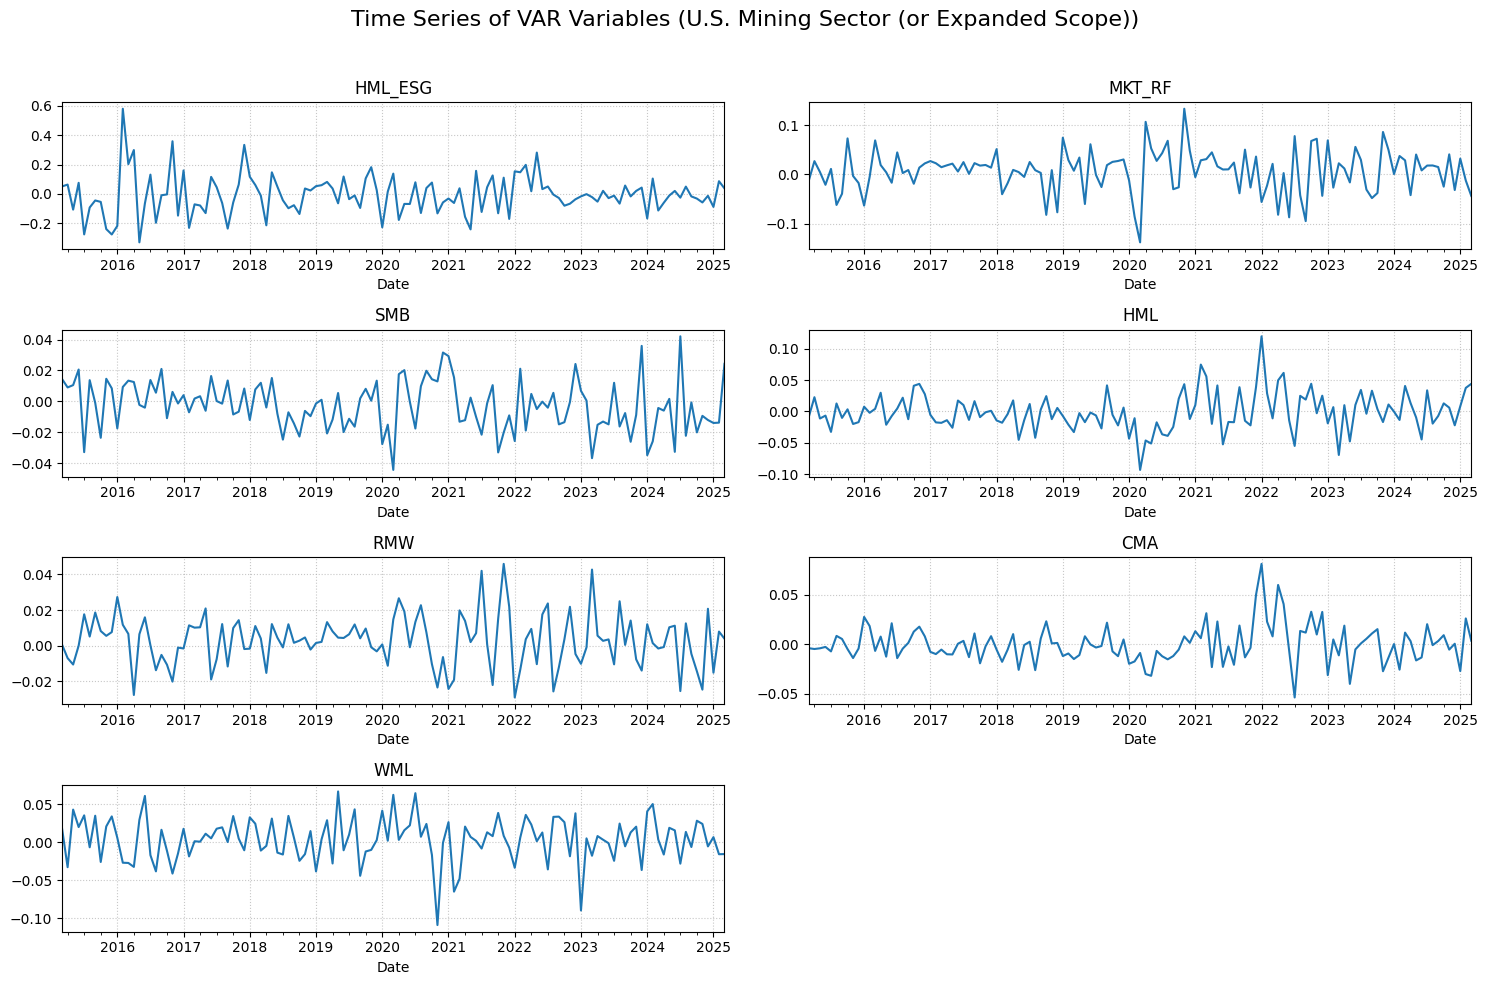

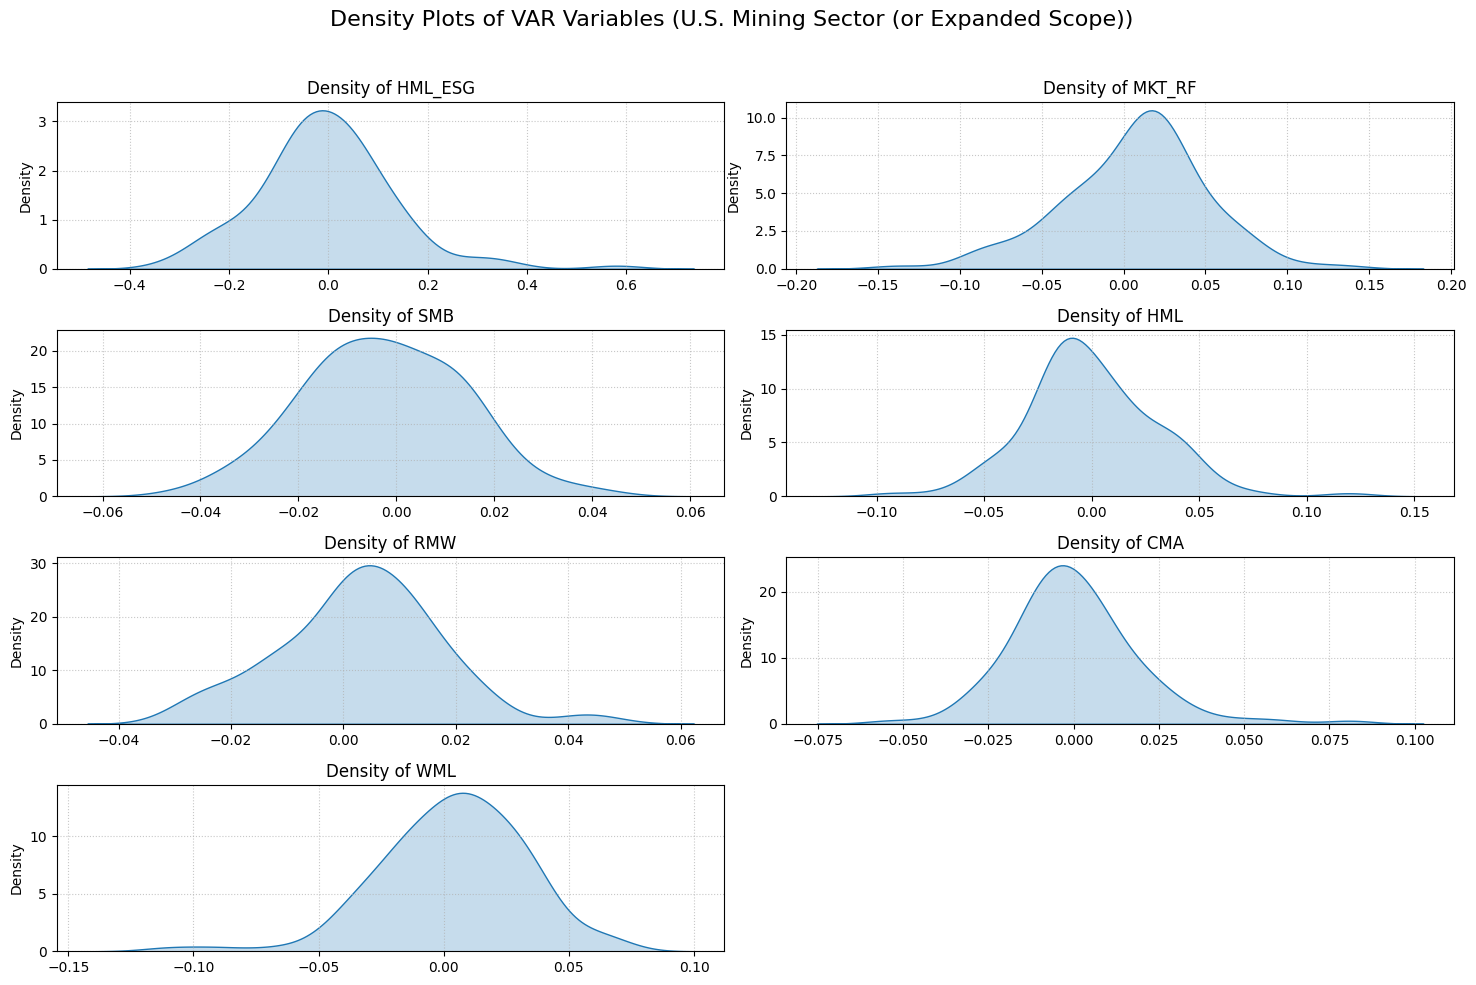


Scatter Plot Matrix for: HML_ESG, MKT_RF, SMB, HML


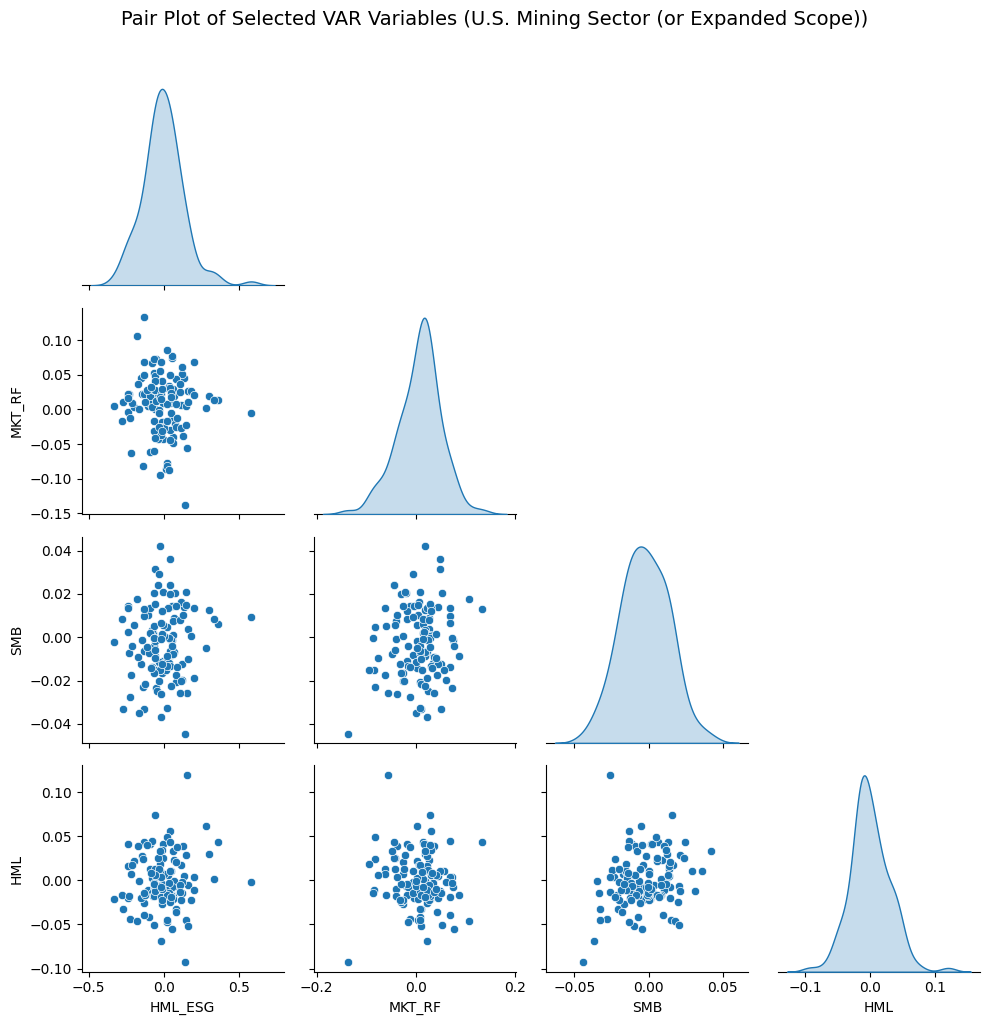

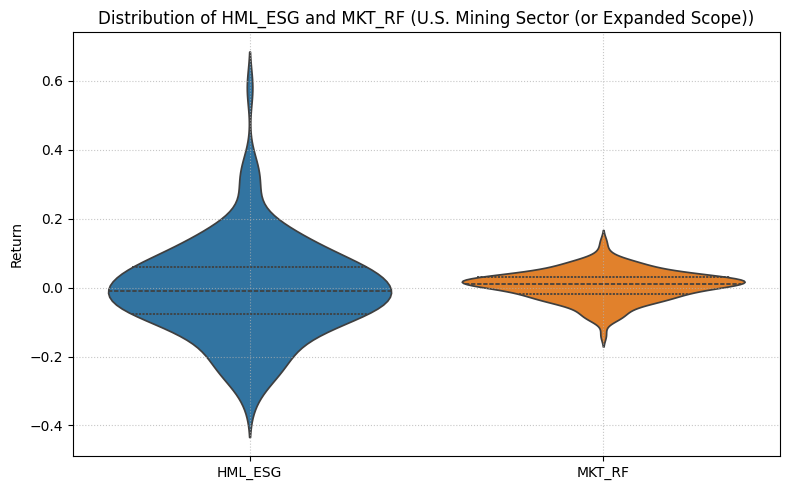

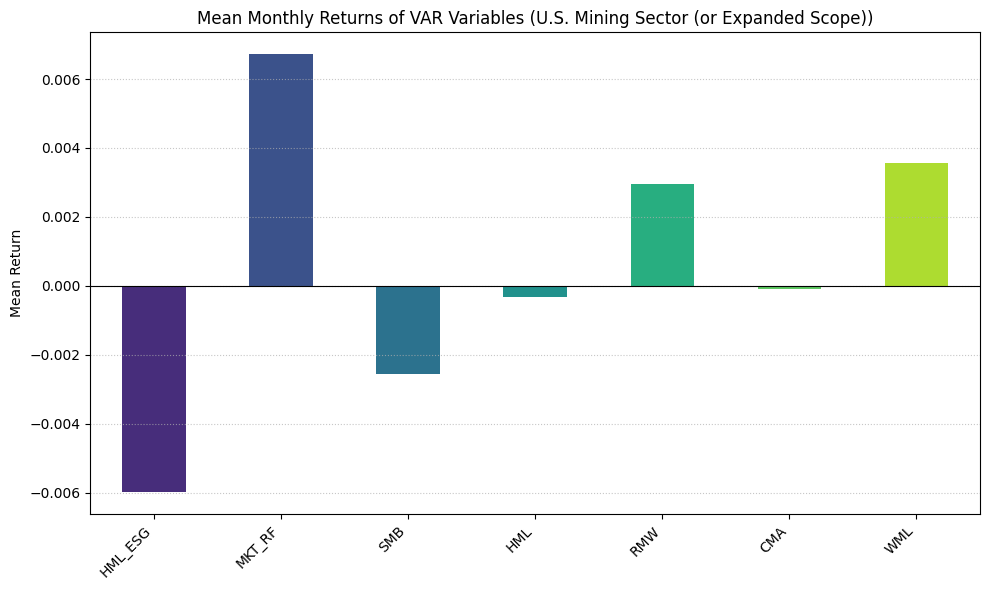


**VAR Model Diagnostics and Estimation for U.S. Mining Sector (or Expanded Scope):**
  1. Stationarity of VAR Inputs:
     - HML_ESG: ADF p-value=0.000 (Stationary)
     - MKT_RF: ADF p-value=0.000 (Stationary)
     - SMB: ADF p-value=0.000 (Stationary)
     - HML: ADF p-value=0.001 (Stationary)
     - RMW: ADF p-value=0.000 (Stationary)
     - CMA: ADF p-value=0.000 (Stationary)
     - WML: ADF p-value=0.000 (Stationary)

  2. VAR Lag Order Selection (maxlags potentially adjusted):
     Using maxlags=1 for selection.
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0     -51.29*     -51.13*  5.300e-23*     -51.23*
1      -50.94      -49.64   7.531e-23      -50.41
-------------------------------------------------
     Chosen VAR Lag Order (BIC): 1.

  3. VAR Residual Diagnostics - Durbin-Watson:
+------------+-----------------+
| Variable   |   Durbin-Watson |
+============+===========

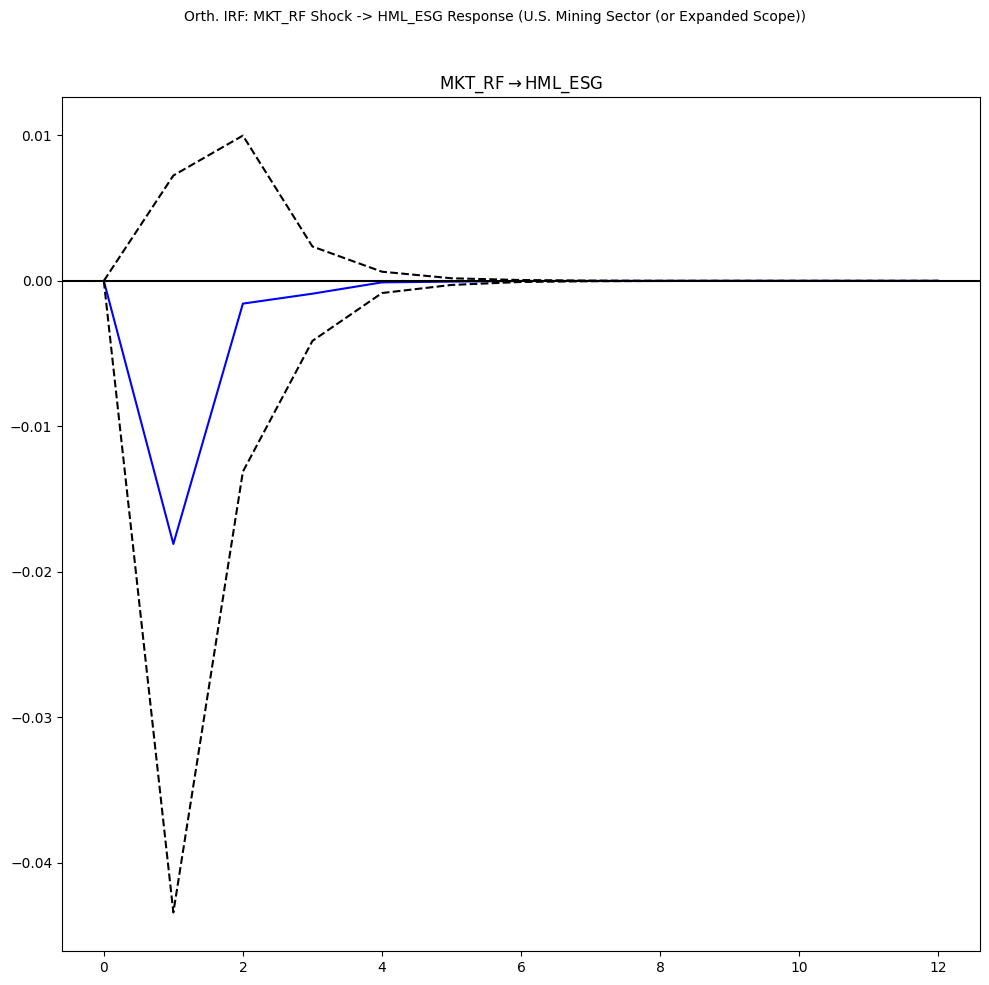

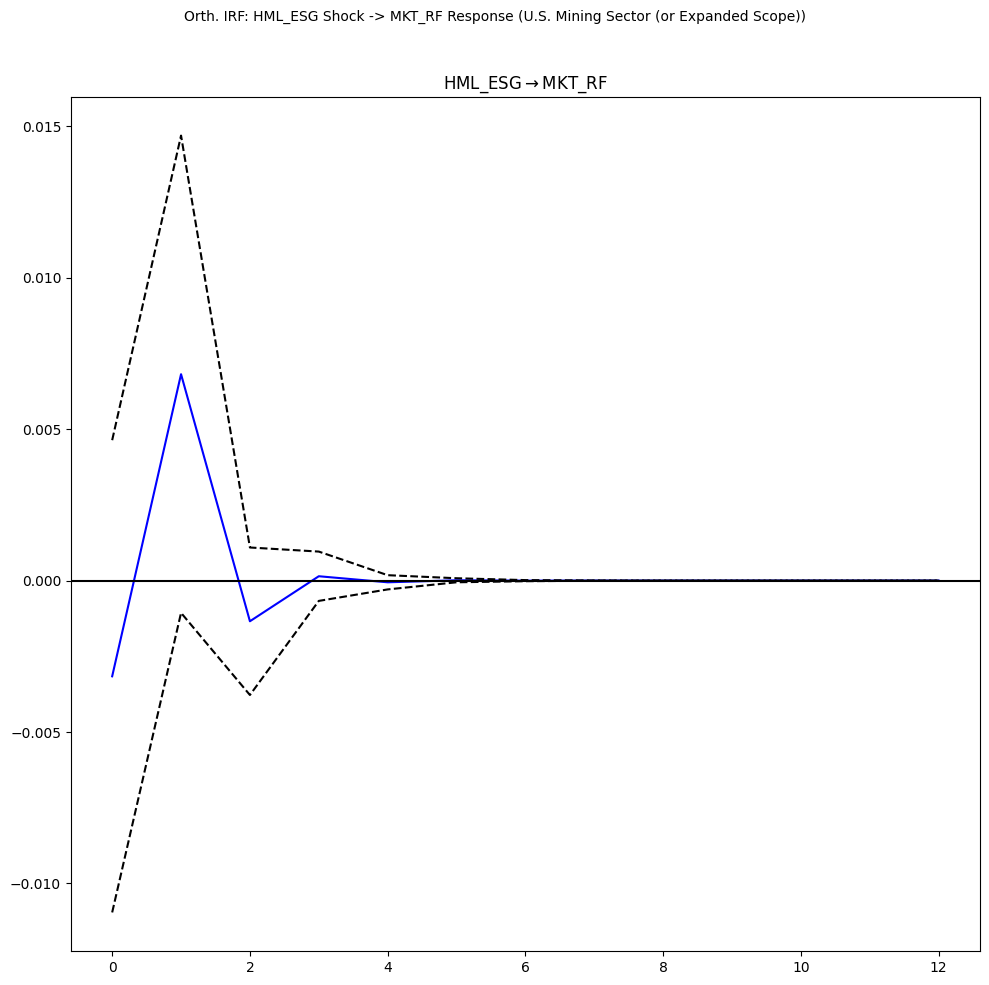

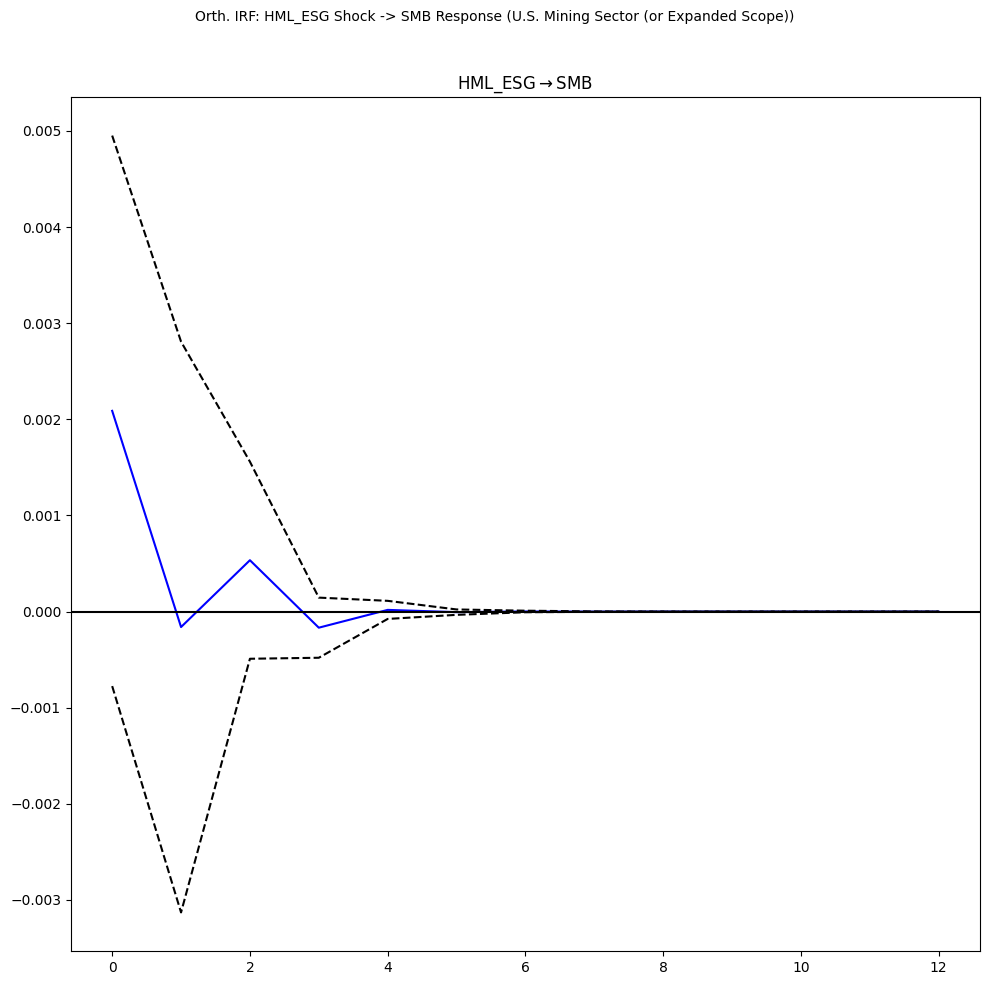


  6. Forecast Error Variance Decomposition (FEVD) Summary Tables:
FEVD for U.S. Mining Sector (or Expanded Scope) (up to 12 periods):
FEVD for HML_ESG
       HML_ESG    MKT_RF       SMB       HML       RMW       CMA       WML
0     1.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
1     0.910704  0.016548  0.001413  0.031774  0.026503  0.012951  0.000107
2     0.906567  0.016592  0.001977  0.033801  0.027438  0.012909  0.000715
3     0.906212  0.016625  0.001997  0.033904  0.027468  0.012936  0.000858
4     0.906185  0.016625  0.002000  0.033917  0.027469  0.012936  0.000868
5     0.906183  0.016625  0.002000  0.033918  0.027469  0.012936  0.000868
6     0.906183  0.016625  0.002000  0.033918  0.027469  0.012936  0.000868
7     0.906183  0.016625  0.002000  0.033918  0.027469  0.012936  0.000868
8     0.906183  0.016625  0.002000  0.033918  0.027469  0.012936  0.000868
9     0.906183  0.016625  0.002000  0.033918  0.027469  0.012936  0.000868
10    0.906183  0.01662

In [15]:
# Install arch if running in Colab and it's not already installed
try:
    import arch
except ImportError:
    print("Installing arch library...")
    !pip install arch -q --no-input

import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from linearmodels.panel import PanelOLS, RandomEffects, PooledOLS
from scipy import stats
import io
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# --- 1. Setup and Data Loading ---
print("--- 1. Setup and Data Loading ---")
ff_file_path = '/content/Developed_5_Factors_Momentum.csv'
esg_file_path = '/content/historic_esg_scores_mining_re.csv'
SECTOR_NAME = "U.S. Mining Sector (or Expanded Scope)"
SECTOR_INDUSTRY_FOR_NARRATIVE = f"firms in the {SECTOR_NAME}"

try:
    ff_df = pd.read_csv(ff_file_path, sep=',')
    print(f"Fama-French data loaded successfully.")
except Exception as e: print(f"Error loading Fama-French CSV: {e}"); raise
if 'Date' not in ff_df.columns: raise ValueError("Date column missing in FF data.")
ff_df['Date'] = pd.to_datetime(ff_df['Date'], format='%m/%d/%y')
factor_cols_ff = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'WML']
for col_ff in factor_cols_ff: ff_df[col_ff] = ff_df[col_ff] / 100.0
ff_df = ff_df.rename(columns={'Mkt-RF': 'MKT_RF'})

try:
    esg_df = pd.read_csv(esg_file_path, sep=',')
    print(f"ESG data for {SECTOR_NAME} loaded successfully from original source.")
except Exception as e: print(f"Error loading ESG CSV for {SECTOR_NAME}: {e}"); raise

if 'Date' not in esg_df.columns: raise ValueError("Date column missing in ESG data.")
if 'Ticker' not in esg_df.columns: raise ValueError("Ticker column missing in ESG data.")
esg_df['Date'] = pd.to_datetime(esg_df['Date'], format='%m/%d/%y')
tickers_from_esg = esg_df['Ticker'].unique().tolist()
print(f"Tickers found in ESG data: {tickers_from_esg}")

final_tickers_to_download = tickers_from_esg

start_date_prices = ff_df['Date'].min()
end_date_prices = max(ff_df['Date'].max(), esg_df['Date'].max())
stock_prices_df = pd.DataFrame()
print(f"Attempting to download stock prices for {len(final_tickers_to_download)} tickers from {start_date_prices - pd.DateOffset(months=1)} to {end_date_prices + pd.DateOffset(days=1)}")
downloaded_tickers_count = 0
for ticker in final_tickers_to_download:
    try:
        data = yf.download(ticker, start=start_date_prices - pd.DateOffset(months=1),
                           end=end_date_prices + pd.DateOffset(days=1),
                           progress=False, auto_adjust=True, timeout=20)
        if not data.empty and 'Close' in data.columns:
            stock_prices_df[ticker] = data['Close']
            downloaded_tickers_count +=1
        elif data.empty : print(f"No data returned for {ticker} by yfinance.")
        else: print(f"Data for {ticker} downloaded but 'Close' column missing.")
    except Exception as e: print(f"yfinance error for {ticker}: {e}")

if stock_prices_df.empty: raise ValueError("No stock price data downloaded.")
print(f"\nStock prices downloaded for {downloaded_tickers_count} tickers.")
if downloaded_tickers_count < len(final_tickers_to_download):
    print(f"Warning: Could not download price data for all tickers. Expected {len(final_tickers_to_download)}, got {downloaded_tickers_count}")
    print(f"Missing tickers: {list(set(final_tickers_to_download) - set(stock_prices_df.columns))}")

# --- 2. Data Preprocessing ---
print("\n--- 2. Data Preprocessing ---")
monthly_prices = stock_prices_df.resample('ME').last()
monthly_returns = monthly_prices.pct_change().dropna(how='all')
if monthly_returns.empty: raise ValueError("Monthly returns empty.")
stock_returns_long = monthly_returns.stack().reset_index()
stock_returns_long.columns = ['Date', 'Ticker', 'Stock_Return']

for df_to_process in [stock_returns_long, ff_df, esg_df]:
    df_to_process['Date'] = pd.to_datetime(df_to_process['Date'])
    df_to_process['Date'] = df_to_process['Date'].dt.to_period('M').dt.start_time

data_merged = pd.merge(stock_returns_long, ff_df, on='Date', how='left')
if 'RF' not in data_merged.columns: raise KeyError("'RF' column not found.")
data_merged['Excess_Return'] = data_merged['Stock_Return'] - data_merged['RF']

esg_df_lagged = esg_df.copy()
esg_score_cols = ['Total-Score', 'E-Score', 'S-Score', 'G-Score']
all_esg_cols_to_process = [col for col in esg_score_cols if col in esg_df_lagged.columns]

for score_col in all_esg_cols_to_process:
    if score_col in esg_df_lagged.columns:
        if 'Score' in score_col: esg_df_lagged[score_col] = esg_df_lagged[score_col].replace(0, np.nan)
        esg_df_lagged[f'Lagged_{score_col}'] = esg_df_lagged.groupby('Ticker')[score_col].shift(1)
        esg_df_lagged[f'Lagged3M_{score_col}'] = esg_df_lagged.groupby('Ticker')[score_col].shift(3)
        esg_df_lagged[f'Lagged6M_{score_col}'] = esg_df_lagged.groupby('Ticker')[score_col].shift(6)
        esg_df_lagged[f'Avg12M_Lagged_{score_col}'] = esg_df_lagged.groupby('Ticker')[score_col].transform(
            lambda x: x.rolling(window=12, min_periods=max(1, 12//2)).mean().shift(1))

final_df = pd.merge(data_merged, esg_df_lagged, on=['Date', 'Ticker'], how='left')

key_cols_for_dropna_list = ['Excess_Return', 'MKT_RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML']
lagged_esg_variants = []
for s_col in all_esg_cols_to_process:
    lagged_esg_variants.extend([f'Lagged_{s_col}', f'Lagged3M_{s_col}', f'Lagged6M_{s_col}', f'Avg12M_Lagged_{s_col}'])
for lag_col in lagged_esg_variants:
    if lag_col in final_df.columns: key_cols_for_dropna_list.append(lag_col)
key_cols_for_dropna_list = list(set(key_cols_for_dropna_list))
key_cols_for_dropna_list = [col for col in key_cols_for_dropna_list if col in final_df.columns]

final_df_cleaned = final_df.dropna(subset=key_cols_for_dropna_list, how='any').copy()

if final_df_cleaned.empty:
    print("Warning: final_df_cleaned is empty after dropping NaNs.")
    raise ValueError("Cleaned DataFrame (final_df_cleaned) is empty. Cannot proceed.")

final_df_cleaned = final_df_cleaned.set_index(['Ticker', 'Date'])
print(f"Shape of cleaned data for analysis (final_df_cleaned): {final_df_cleaned.shape}")
N_entities_final = final_df_cleaned.index.get_level_values(0).nunique()
print(f"Number of unique tickers in final_df_cleaned: {N_entities_final}")
print(f"Date range in final_df_cleaned: {final_df_cleaned.index.get_level_values(1).min()} to {final_df_cleaned.index.get_level_values(1).max()}")


# --- 3. Model Selection for Panel Data and Diagnostic Tests ---
print("\n\n--- 3. Model Selection for Panel Data and Diagnostic Tests ---")
chosen_panel_model_type = "Two-Way FE (Entity & Time) with Clustered SE (Default)"
test_summary_data = []
f_pooled_decision, hausman_decision, bp_decision = "Skipped", "Skipped", "Skipped"

if final_df_cleaned.empty:
    print(f"Skipping model selection tests as final_df_cleaned is empty for {SECTOR_NAME}.")
    test_summary_data.append(["All Tests", "N/A", "final_df_cleaned empty", "Defaulting to Two-Way FE"])
else:
    panel_test_esg_var = 'Lagged_Total-Score'
    panel_test_ff_factors = ['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML']
    if panel_test_esg_var not in final_df_cleaned.columns or final_df_cleaned[panel_test_esg_var].isnull().all():
        available_lagged_esg = [c for c in final_df_cleaned.columns if c.startswith('Lagged_') and 'Score' in c and not final_df_cleaned[c].isnull().all()]
        if available_lagged_esg: panel_test_esg_var = available_lagged_esg[0]; print(f"Using {panel_test_esg_var} for panel model selection.")
        else: panel_test_esg_var = None; print(f"No suitable lagged ESG score for model selection. Using default model choice.")
    panel_test_exog_vars = []
    if panel_test_esg_var: panel_test_exog_vars = panel_test_ff_factors + [panel_test_esg_var]; panel_test_exog_vars = [v for v in panel_test_exog_vars if v in final_df_cleaned.columns]
    panel_test_data = pd.DataFrame()
    if panel_test_exog_vars: panel_test_data = final_df_cleaned[['Excess_Return'] + panel_test_exog_vars].copy(); panel_test_data.dropna(inplace=True)
    num_entities_test = panel_test_data.index.get_level_values(0).nunique() if not panel_test_data.empty else 0
    min_obs_for_tests = (len(panel_test_exog_vars) if panel_test_exog_vars else 0) + num_entities_test + 20
    if panel_test_data.empty or panel_test_data.shape[0] < min_obs_for_tests or num_entities_test < 2 :
        print(f"Insufficient data for full panel model selection tests. Have {panel_test_data.shape[0]} obs, {num_entities_test} entities. Defaulting to Two-Way FE.")
        f_pooled_decision, hausman_decision, bp_decision = "Default", "Default", "Default"; test_summary_data.append(["All Tests", "N/A", "Insufficient data", "Defaulting to Two-Way FE"])
    else:
        Y_paneltest = panel_test_data['Excess_Return']; X_paneltest_df = sm.add_constant(panel_test_data[panel_test_exog_vars]); fe_entity_res_for_test = None
        try: # F-test
            mod_fe_entity_test = PanelOLS(Y_paneltest, X_paneltest_df, entity_effects=True, time_effects=False); fe_entity_res_for_test = mod_fe_entity_test.fit(cov_type='clustered', cluster_entity=True)
            if hasattr(fe_entity_res_for_test, 'f_pooled') and fe_entity_res_for_test.f_pooled is not None:
                f_pooled_decision = 'Entity FE significant' if fe_entity_res_for_test.f_pooled.pval < 0.05 else 'Entity FE not significant'
                test_summary_data.append(["F-test (Entity FE vs Pooled OLS)", f"{fe_entity_res_for_test.f_pooled.stat:.4f}", f"{fe_entity_res_for_test.f_pooled.pval:.4f}", f_pooled_decision])
            else: f_pooled_decision = "Test N/A"; test_summary_data.append(["F-test", "N/A", "N/A", f_pooled_decision])
        except Exception as e: f_pooled_decision = "Error"; test_summary_data.append(["F-test", "Error", str(e), f_pooled_decision]); print(f"Error F-test FE: {e}")
        try: # Hausman
            if fe_entity_res_for_test:
                mod_re_test = RandomEffects(Y_paneltest, X_paneltest_df); re_res_for_test = mod_re_test.fit(cov_type='clustered', cluster_entity=True)
                fe_coeff = fe_entity_res_for_test.params.get(panel_test_esg_var, np.nan); re_coeff = re_res_for_test.params.get(panel_test_esg_var, np.nan)
                diff = fe_coeff - re_coeff if not (pd.isna(fe_coeff) or pd.isna(re_coeff)) else np.nan; note_h = f"FE:{fe_coeff:.4f}, RE:{re_coeff:.4f}. Diff:{diff:.4f}"
                hausman_decision = "FE preferred (F-test sig.)" if f_pooled_decision.startswith('Entity FE significant') else "Choice less clear (F-test not sig.)"
                test_summary_data.append(["Hausman (Informal)", "Comparison", note_h, hausman_decision])
            else: hausman_decision = "Skipped (FE failed)"; test_summary_data.append(["Hausman (Informal)", "N/A", "FE failed", hausman_decision])
        except Exception as e: hausman_decision = "Error"; test_summary_data.append(["Hausman (Informal)", "Error", str(e), hausman_decision]); print(f"Error Hausman: {e}")
        try: # Breusch-Pagan
            if fe_entity_res_for_test:
                bp_stat, bp_pval, _, _ = het_breuschpagan(fe_entity_res_for_test.resids, fe_entity_res_for_test.model.exog.dataframe if hasattr(fe_entity_res_for_test.model.exog, 'dataframe') else fe_entity_res_for_test.model.exog.ndarray)
                bp_decision = 'Heteroskedasticity present' if bp_pval < 0.05 else 'Homoskedasticity'
                test_summary_data.append([f"Breusch-Pagan (Entity FE resid)", f"LM:{bp_stat:.2f}", f"Pval:{bp_pval:.3f}", bp_decision])
            else: bp_decision = "Skipped (FE failed)"; test_summary_data.append(["Breusch-Pagan", "N/A", "FE failed", bp_decision])
        except Exception as e: bp_decision = "Error"; test_summary_data.append(["Breusch-Pagan", "Error", str(e), bp_decision]); print(f"Error BP: {e}")
print("\n**Table: Panel Model Specification Tests Summary**"); print(tabulate(test_summary_data, headers=["Test", "Statistic", "P-value/Note", "Conclusion"], tablefmt="grid"))
print(f"\nModel Choice Justification for Panel Regressions (RQ1) for {SECTOR_NAME}:") # Narrative based on test results
if f_pooled_decision.startswith('Entity FE significant'): print("  - F-test: Entity FE significant, supports FE over Pooled OLS.")
elif f_pooled_decision.startswith('Entity FE not significant'): print("  - F-test: Entity FE not significant. RE/Pooled OLS might be considered, but Time FE often vital.")
elif f_pooled_decision == "Default": print("  - Model selection tests skipped due to limited data.")
else: print(f"  - F-test: {f_pooled_decision}.")
if hausman_decision.startswith("FE preferred"): print(f"  - Hausman (Informal): {hausman_decision}, supports FE over RE.")
elif hausman_decision not in ["Skipped", "Error", "Default", "Skipped (FE failed)"]: print(f"  - Hausman (Informal): {hausman_decision}.")
if bp_decision.startswith('Heteroskedasticity'): print("  - Breusch-Pagan: Heteroskedasticity present (use robust SE).")
elif bp_decision.startswith('Homoskedasticity'): print("  - Breusch-Pagan: Homoskedasticity (robust SE still good practice).")
elif bp_decision != "Default": print(f"  - Breusch-Pagan: {bp_decision}.")
print(f"  - **Decision for RQ1 ({SECTOR_NAME}):** Given the importance of time-varying shocks and common practice, {chosen_panel_model_type} is adopted, but results from other models are presented for robustness.")


# --- 4. Panel Data Models (RQ1: ESG Impact on Returns) ---
# (Section 4 with multiple panel models as per last correction - this should be fine)
print(f"\n\n--- 4. Panel Data Models (RQ1: ESG Impact on Returns for {SECTOR_NAME}) ---")
panel_results_summary_for_chart_data = []
all_panel_model_results = {}
if final_df_cleaned.empty: print(f"Skipping panel models for {SECTOR_NAME}: final_df_cleaned is empty.")
else:
    esg_vars_to_test_panel = []; all_esg_cols_to_process_sec4 = [col for col in ['Total-Score', 'E-Score', 'S-Score', 'G-Score'] if col in final_df_cleaned.columns] # Use columns present in final_df_cleaned
    for s_col_panel in all_esg_cols_to_process_sec4: esg_vars_to_test_panel.extend([f'Lagged_{s_col_panel}', f'Lagged3M_{s_col_panel}', f'Lagged6M_{s_col_panel}', f'Avg12M_Lagged_{s_col_panel}'])
    esg_vars_to_test_panel = [v for v in esg_vars_to_test_panel if v in final_df_cleaned.columns and final_df_cleaned[v].nunique(dropna=True) > 1]
    if not esg_vars_to_test_panel: print(f"No valid ESG variables with variance found for panel regression in {SECTOR_NAME}.")
    else:
        for esg_var in esg_vars_to_test_panel:
            print(f"\n--- Panel Regressions for {SECTOR_NAME} using: {esg_var} ---")
            current_exog_panel = [esg_var]; panel_data_subset = final_df_cleaned[['Excess_Return'] + current_exog_panel].copy().dropna()
            num_entities_model = panel_data_subset.index.get_level_values(0).nunique(); num_time_periods_model = panel_data_subset.index.get_level_values(1).nunique()
            min_obs_pooled = len(current_exog_panel) + 1 + 10; min_obs_re = len(current_exog_panel) + 1 + 10
            min_obs_fe_entity = len(current_exog_panel) + num_entities_model + 10; min_obs_fe_time = len(current_exog_panel) + num_time_periods_model + 10
            min_obs_fe_twoway = len(current_exog_panel) + num_entities_model + num_time_periods_model + 10
            if panel_data_subset.empty or num_entities_model < 1: print(f"  Skipping {esg_var}: Not enough data or entities."); continue
            X_panel_df = sm.add_constant(panel_data_subset[current_exog_panel]); Y_panel = panel_data_subset['Excess_Return']
            model_specs_to_run = []
            if panel_data_subset.shape[0] >= min_obs_pooled: model_specs_to_run.append({"name": "PooledOLS", "model_type": PooledOLS, "effects": {}})
            if panel_data_subset.shape[0] >= min_obs_re and num_entities_model > len(current_exog_panel) +1: model_specs_to_run.append({"name": "RandomEffects (Entity)", "model_type": RandomEffects, "effects": {}})
            if panel_data_subset.shape[0] >= min_obs_fe_entity and num_entities_model >= 2: model_specs_to_run.append({"name": "FixedEffects (Entity)", "model_type": PanelOLS, "effects": {'entity_effects':True, 'time_effects':False, 'drop_absorbed':True}})
            if panel_data_subset.shape[0] >= min_obs_fe_time and num_time_periods_model >= len(current_exog_panel) + 2: model_specs_to_run.append({"name": "FixedEffects (Time)", "model_type": PanelOLS, "effects": {'entity_effects':False, 'time_effects':True, 'drop_absorbed':True}})
            if panel_data_subset.shape[0] >= min_obs_fe_twoway and num_entities_model >= 2 and num_time_periods_model >= len(current_exog_panel) + num_entities_model + 2 : model_specs_to_run.append({"name": "FixedEffects (Two-Way)", "model_type": PanelOLS, "effects": {'entity_effects':True, 'time_effects':True, 'drop_absorbed':True}})
            if not model_specs_to_run: print(f"  Skipping {esg_var}: Not enough data for any robust panel model."); continue
            for spec in model_specs_to_run:
                print(f"\n  -- Running Model: {spec['name']} for {esg_var} --")
                try:
                    if spec['model_type'] == PooledOLS or spec['model_type'] == RandomEffects: mod = spec['model_type'](Y_panel, X_panel_df)
                    else: mod = spec['model_type'](Y_panel, X_panel_df, **spec['effects'])
                    res_cov_type = 'clustered'; res_cluster_entity = True; res_cluster_time = False
                    if spec['name'] == "FixedEffects (Time)": res_cluster_time = True; res_cluster_entity = False
                    elif spec['name'] == "FixedEffects (Two-Way)": res_cluster_time = True
                    if spec['name'] == "FixedEffects (Two-Way)" and res_cluster_entity and res_cluster_time:
                        try: res = mod.fit(cov_type=res_cov_type, cluster_entity=res_cluster_entity, cluster_time=res_cluster_time)
                        except Exception: res = mod.fit(cov_type=res_cov_type, cluster_entity=True); print(f"    Note: Used entity-clustered SE for Two-Way FE.")
                    elif res_cluster_entity and not res_cluster_time: res = mod.fit(cov_type=res_cov_type, cluster_entity=True)
                    elif res_cluster_time and not res_cluster_entity: res = mod.fit(cov_type=res_cov_type, cluster_time=True)
                    else: res = mod.fit(cov_type=res_cov_type, cluster_entity=True) # Default to entity cluster for Pooled/RE
                    print(res); all_panel_model_results.setdefault(esg_var, {})[spec['name']] = res.summary.as_text()
                    if esg_var in res.params and spec['name'] == "FixedEffects (Two-Way)":
                        coeff = res.params[esg_var]; pval = res.pvalues[esg_var]; significant = pval < 0.05
                        panel_results_summary_for_chart_data.append({'ESG_Variable': esg_var, 'Coefficient': coeff, 'P_Value': pval, 'Significant_5pct': significant, 'Sector': SECTOR_NAME})
                        print(f"    Summary for {esg_var} ({spec['name']}, {SECTOR_NAME}): Coeff={coeff:.6f} (P-val={pval:.4f}), Significant (5%): {significant}")
                except Exception as e: print(f"    Error running {spec['name']} for {esg_var}: {e}"); all_panel_model_results.setdefault(esg_var, {})[spec['name']] = f"Error: {e}"
if panel_results_summary_for_chart_data:
    panel_results_df_chart = pd.DataFrame(panel_results_summary_for_chart_data)
    significant_results_chart = panel_results_df_chart[panel_results_df_chart['Significant_5pct']]
    if not significant_results_chart.empty: plt.figure(figsize=(12, 7)); bars = plt.bar(significant_results_chart['ESG_Variable'], significant_results_chart['Coefficient'], color=['darkgreen' if x > 0 else 'darkred' for x in significant_results_chart['Coefficient']]); plt.ylabel('Coefficient (Impact on Monthly Excess Return)'); plt.xlabel(f'Lagged ESG Variable ({SECTOR_NAME})'); plt.title(f'Statistically Significant ESG Coefficients ({SECTOR_NAME}, Two-Way FE, 5% level)'); plt.xticks(rotation=45, ha="right"); plt.grid(axis='y', linestyle=':', alpha=0.7); [plt.text(bar_item.get_x() + bar_item.get_width()/2.0, bar_item.get_height(), f'{bar_item.get_height():.4f}', va='bottom' if bar_item.get_height() < 0 else 'top', ha='center', fontsize=8) for bar_item in bars]; plt.tight_layout(); plt.show()
    else: print(f"\nNo ESG variables found statistically significant at 5% in Two-Way FE PanelOLS models for {SECTOR_NAME} for chart.")
else: print(f"\nNo Two-Way FE panel regression results to visualize for {SECTOR_NAME}.")


# --- 5. Vector Autoregression (VAR) Analysis ---
print(f"\n\n--- 5. Vector Autoregression (VAR) Analysis (RQ2: Dynamic Interplay for {SECTOR_NAME}) ---")
var_success_flag = False; fevd = None; irf_periods = None; best_lag_order_var_val = None
var_data_merged = pd.DataFrame(); gc_table_data = []
primary_esg_for_hml_var = 'Lagged_Total-Score'
if primary_esg_for_hml_var not in final_df_cleaned.columns or final_df_cleaned[primary_esg_for_hml_var].isnull().all():
    available_esg_for_hml = [c for c in final_df_cleaned.columns if c.startswith('Lagged_') and 'Score' in c and not final_df_cleaned[c].isnull().all()]
    if available_esg_for_hml: primary_esg_for_hml_var = available_esg_for_hml[0]; print(f"Using {primary_esg_for_hml_var} for HML_ESG in VAR.")
    else: primary_esg_for_hml_var = None; print(f"Skipping VAR: No suitable non-empty lagged ESG score for HML_ESG.")

if not final_df_cleaned.empty and primary_esg_for_hml_var is not None and N_entities_final > 0 :
    def get_portfolio_returns_simple_var(data_panel_indexed_func, esg_col_name_sort_func, num_portfolios_target=2):
        if esg_col_name_sort_func not in data_panel_indexed_func.columns: return pd.DataFrame()
        if data_panel_indexed_func[esg_col_name_sort_func].isnull().all(): return pd.DataFrame()
        data_for_sort_local = data_panel_indexed_func.reset_index(); portfolio_dfs_local = []
        print(f"  Constructing HML_ESG based on {esg_col_name_sort_func}, aiming for {num_portfolios_target} portfolios if data allows.")
        for date_val_local, group_local in data_for_sort_local.groupby('Date'):
            valid_esg_scores_group = group_local.dropna(subset=[esg_col_name_sort_func, 'Excess_Return'])
            n_firms_this_period = valid_esg_scores_group['Ticker'].nunique()
            if n_firms_this_period >= num_portfolios_target * 2 and n_firms_this_period >= 5 and num_portfolios_target >=5 : n_portfolios_this_period = 5
            elif n_firms_this_period >= num_portfolios_target * 2 and n_firms_this_period >= 3 and num_portfolios_target >=3: n_portfolios_this_period = 3
            else: n_portfolios_this_period = 2
            if valid_esg_scores_group[esg_col_name_sort_func].nunique() < n_portfolios_this_period or valid_esg_scores_group.shape[0] < n_portfolios_this_period : continue
            try:
                labels_local = [f'P{i+1}' for i in range(n_portfolios_this_period)]
                valid_esg_scores_group['Portfolio'] = pd.qcut(valid_esg_scores_group[esg_col_name_sort_func].rank(method='first', pct=True), n_portfolios_this_period, labels=labels_local, duplicates='drop')
                if valid_esg_scores_group['Portfolio'].nunique() < n_portfolios_this_period: continue
                port_returns_this_date_local = valid_esg_scores_group.groupby('Portfolio', observed=False)['Excess_Return'].mean()
                if labels_local[0] in port_returns_this_date_local and labels_local[-1] in port_returns_this_date_local:
                    portfolio_dfs_local.append(pd.DataFrame([{'Date': date_val_local, 'HML_ESG_Ret_VAR': port_returns_this_date_local[labels_local[-1]] - port_returns_this_date_local[labels_local[0]]}]))
            except Exception: continue
        if not portfolio_dfs_local: print(f"Warning: No HML_ESG portfolio returns calculated for {SECTOR_NAME} using {esg_col_name_sort_func}."); return pd.DataFrame()
        return pd.concat(portfolio_dfs_local).set_index('Date').dropna(subset=['HML_ESG_Ret_VAR'])
    hml_portfolios_target = 5 if N_entities_final >= 15 else (3 if N_entities_final >= 9 else 2)
    portfolio_returns_for_var = get_portfolio_returns_simple_var(final_df_cleaned, primary_esg_for_hml_var, num_portfolios_target=hml_portfolios_target)

    if not portfolio_returns_for_var.empty and 'HML_ESG_Ret_VAR' in portfolio_returns_for_var.columns:
        var_data_hml_esg = portfolio_returns_for_var[['HML_ESG_Ret_VAR']].rename(columns={'HML_ESG_Ret_VAR':'HML_ESG'})
        ff_df_for_var_join = ff_df.set_index('Date'); var_data_hml_esg.index = pd.to_datetime(var_data_hml_esg.index)
        var_data_merged = var_data_hml_esg.join(ff_df_for_var_join[['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML']], how='inner').dropna()
        print(f"Shape of data for VAR analysis (var_data_merged) for {SECTOR_NAME}: {var_data_merged.shape}")

        if var_data_merged.shape[0] < 30:
            print(f"Not enough observations ({var_data_merged.shape[0]}) for VAR analysis in {SECTOR_NAME}. Min 30 required.")
        else: # VAR analysis block
            var_success_flag = True
            print(f"\n**VAR Data Visualizations for {SECTOR_NAME}:**")
            plt.figure(figsize=(15, 10))
            for i, col in enumerate(var_data_merged.columns):
                plt.subplot((len(var_data_merged.columns) + 1) // 2, 2, i + 1)
                var_data_merged[col].plot(title=col); plt.grid(True, linestyle=':', alpha=0.7)
            plt.suptitle(f'Time Series of VAR Variables ({SECTOR_NAME})', fontsize=16); plt.tight_layout(rect=[0,0,1,0.96]); plt.show()

            plt.figure(figsize=(15, 10))
            for i, col in enumerate(var_data_merged.columns):
                plt.subplot((len(var_data_merged.columns) + 1) // 2, 2, i + 1)
                sns.kdeplot(var_data_merged[col], fill=True); plt.title(f'Density of {col}'); plt.xlabel(''); plt.ylabel('Density'); plt.grid(True, linestyle=':', alpha=0.7)
            plt.suptitle(f'Density Plots of VAR Variables ({SECTOR_NAME})', fontsize=16); plt.tight_layout(rect=[0,0,1,0.96]); plt.show()

            pair_plot_vars = ['HML_ESG', 'MKT_RF'] + [c for c in ['SMB', 'HML', 'WML'] if c in var_data_merged.columns][:2]
            pair_plot_vars = [v for v in pair_plot_vars if v in var_data_merged.columns]
            if len(pair_plot_vars) > 1:
                print(f"\nScatter Plot Matrix for: {', '.join(pair_plot_vars)}"); sns.pairplot(var_data_merged[pair_plot_vars], diag_kind='kde', corner=True)
                plt.suptitle(f'Pair Plot of Selected VAR Variables ({SECTOR_NAME})', y=1.02, fontsize=14); plt.tight_layout(); plt.show()

            if 'HML_ESG' in var_data_merged.columns and 'MKT_RF' in var_data_merged.columns:
                plt.figure(figsize=(8, 5)); sns.violinplot(data=var_data_merged[['HML_ESG', 'MKT_RF']], inner='quartile')
                plt.title(f'Distribution of HML_ESG and MKT_RF ({SECTOR_NAME})'); plt.ylabel('Return'); plt.grid(True, linestyle=':', alpha=0.7); plt.tight_layout(); plt.show()

            plt.figure(figsize=(10, 6)); var_data_merged.mean().plot(kind='bar', color=sns.color_palette("viridis", len(var_data_merged.columns)))
            plt.title(f'Mean Monthly Returns of VAR Variables ({SECTOR_NAME})'); plt.ylabel('Mean Return'); plt.xticks(rotation=45, ha='right')
            plt.grid(axis='y', linestyle=':', alpha=0.7); plt.axhline(0, color='black', linewidth=0.8); plt.tight_layout(); plt.show()

            print(f"\n**VAR Model Diagnostics and Estimation for {SECTOR_NAME}:**")
            print("  1. Stationarity of VAR Inputs:")
            all_stationary_var = True # Assume true initially
            for col_name_var in var_data_merged.columns:
                try:
                    adf_result_var_check = adfuller(var_data_merged[col_name_var].dropna())
                    is_stationary = adf_result_var_check[1] < 0.05
                    print(f"     - {col_name_var}: ADF p-value={adf_result_var_check[1]:.3f} ({'Stationary' if is_stationary else 'Non-Stationary'})")
                    if not is_stationary: all_stationary_var = False
                except Exception as e_adf: print(f"     - {col_name_var}: Error during ADF test: {e_adf}"); all_stationary_var = False
            if not all_stationary_var: print("     Warning: Some series for VAR are non-stationary. Consider differencing or VECM.")

            model_var_select = VAR(var_data_merged)
            try:
                print("\n  2. VAR Lag Order Selection (maxlags potentially adjusted):")
                max_lags_var = min(6, int(var_data_merged.shape[0] / (len(var_data_merged.columns)**2) / 1.5) - 1 ); max_lags_var = max(1, max_lags_var)
                print(f"     Using maxlags={max_lags_var} for selection.")
                selected_lags_var_info = model_var_select.select_order(maxlags=max_lags_var)
                print(selected_lags_var_info.summary())
                best_lag_order_var_val = selected_lags_var_info.bic
                if best_lag_order_var_val == 0: best_lag_order_var_val = 1
                print(f"     Chosen VAR Lag Order (BIC): {best_lag_order_var_val}.")
                var_model_fitted = model_var_select.fit(best_lag_order_var_val)

                print("\n  3. VAR Residual Diagnostics - Durbin-Watson:")
                dw_results_var = durbin_watson(var_model_fitted.resid); dw_df_var_data = [[col, f"{val:.4f}"] for col, val in zip(var_data_merged.columns, dw_results_var)]
                print(tabulate(dw_df_var_data, headers=["Variable", "Durbin-Watson"], tablefmt="grid"))

                print("\n  4. Granger Causality Tests:")
                gc_table_data = []
                hml_esg_col_name = 'HML_ESG'
                if hml_esg_col_name in var_data_merged.columns:
                    causing_ff_vars = [v for v in var_data_merged.columns if v != hml_esg_col_name]
                    if causing_ff_vars:
                        try:
                            gc_res_ff_to_esg = var_model_fitted.test_causality(caused=hml_esg_col_name, causing=causing_ff_vars, kind='f', signif=0.05)
                            gc_table_data.append([f"{', '.join(causing_ff_vars)} -> {hml_esg_col_name}", f"{gc_res_ff_to_esg.test_statistic:.2f}", f"{gc_res_ff_to_esg.pvalue:.3f}", gc_res_ff_to_esg.conclusion=='reject'])
                        except Exception as e_gc_1: gc_table_data.append([f"{', '.join(causing_ff_vars)} -> {hml_esg_col_name}", "Error", str(e_gc_1).split('\n')[0], "N/A"])
                    for ff_var_caused in causing_ff_vars:
                        try:
                            gc_res_esg_to_ff = var_model_fitted.test_causality(caused=ff_var_caused, causing=hml_esg_col_name, kind='f', signif=0.05)
                            gc_table_data.append([f"{hml_esg_col_name} -> {ff_var_caused}", f"{gc_res_esg_to_ff.test_statistic:.2f}", f"{gc_res_esg_to_ff.pvalue:.3f}", gc_res_esg_to_ff.conclusion=='reject'])
                        except Exception as e_gc_2: gc_table_data.append([f"{hml_esg_col_name} -> {ff_var_caused}", "Error", str(e_gc_2).split('\n')[0], "N/A"])
                else: print(f"     HML_ESG column ('{hml_esg_col_name}') not found. Skipping Granger tests.")
                if gc_table_data: print(tabulate(gc_table_data, headers=["Causality Direction", "F-Stat", "P-Value", "Significant (5%)"], tablefmt="grid"))
                else: print("     No Granger causality tests were successfully run or produced results.")

                print("\n  5. Impulse Response Functions (IRFs):")
                try:
                    irf_periods = min(12, var_data_merged.shape[0] - best_lag_order_var_val - 5); irf_periods = max(5, irf_periods)
                    print(f"     Plotting IRFs for {irf_periods} periods.")
                    irf = var_model_fitted.irf(periods=irf_periods)
                    if 'MKT_RF' in var_data_merged.columns and 'HML_ESG' in var_data_merged.columns:
                        fig1 = irf.plot(impulse='MKT_RF', response='HML_ESG', orth=True, signif=0.05);
                        if isinstance(fig1, plt.Figure): fig1.suptitle(f"Orth. IRF: MKT_RF Shock -> HML_ESG Response ({SECTOR_NAME})", fontsize=10); plt.tight_layout(rect=[0,0,1,0.96]); plt.show()
                        fig2 = irf.plot(impulse='HML_ESG', response='MKT_RF', orth=True, signif=0.05);
                        if isinstance(fig2, plt.Figure): fig2.suptitle(f"Orth. IRF: HML_ESG Shock -> MKT_RF Response ({SECTOR_NAME})", fontsize=10); plt.tight_layout(rect=[0,0,1,0.96]); plt.show()
                    if 'SMB' in var_data_merged.columns and 'HML_ESG' in var_data_merged.columns: # Example of another IRF
                        fig3 = irf.plot(impulse='HML_ESG', response='SMB', orth=True, signif=0.05);
                        if isinstance(fig3, plt.Figure): fig3.suptitle(f"Orth. IRF: HML_ESG Shock -> SMB Response ({SECTOR_NAME})", fontsize=10); plt.tight_layout(rect=[0,0,1,0.96]); plt.show()
                except Exception as e_irf: print(f"     Could not compute/plot IRFs for {SECTOR_NAME}: {e_irf}")

                print("\n  6. Forecast Error Variance Decomposition (FEVD) Summary Tables:")
                try:
                    if irf_periods is not None and irf_periods > 0 :
                        fevd = var_model_fitted.fevd(periods=irf_periods)
                        print(f"FEVD for {SECTOR_NAME} (up to {irf_periods} periods):")
                        print(fevd.summary())
                    else: print("     Skipping FEVD due to invalid periods for IRF.")
                except Exception as e_fevd_calc: print(f"     Could not compute or display FEVD for {SECTOR_NAME}: {e_fevd_calc}")
            except Exception as e_var_fit:
                print(f"Error during VAR model fitting or subsequent analysis for {SECTOR_NAME}: {e_var_fit}")
                var_model_fitted = None; best_lag_order_var_val = None; irf_periods = None; fevd = None; gc_table_data = []
    else:
        print(f"Skipping VAR for {SECTOR_NAME}: HML_ESG portfolio could not be formed or insufficient data after merging.")
elif final_df_cleaned.empty:
    print(f"Skipping VAR for {SECTOR_NAME}: final_df_cleaned is empty.")
else:
    print(f"Skipping VAR for {SECTOR_NAME}: Conditions not met (e.g. no ESG var for HML, N_entities_final=0, or primary_esg_for_hml_var is None).")


# --- 4.BIS. Time-Series Alpha of HML_ESG Factor (if VAR runs) ---
if 'var_success_flag' in locals() and var_success_flag and not var_data_merged.empty and 'HML_ESG' in var_data_merged.columns:
    print("\n\n--- 4.BIS. Time-Series Alpha of HML_ESG Factor ---")
    print(f"Regressing the constructed HML_ESG factor (from {N_entities_final} firms, using {primary_esg_for_hml_var}) on Fama-French-Momentum factors.")
    y_hml_esg = var_data_merged['HML_ESG']
    ff_cols_for_alpha_reg = [col for col in ['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML'] if col in var_data_merged.columns]
    if not ff_cols_for_alpha_reg: print("  Skipping HML_ESG alpha regression: No FF factors available.")
    else:
        X_ff_factors = sm.add_constant(var_data_merged[ff_cols_for_alpha_reg])
        try:
            ts_model = sm.OLS(y_hml_esg, X_ff_factors).fit(cov_type='HAC', cov_kwds={'maxlags': int(np.floor(4*(len(y_hml_esg)/100)**(2/9)))})
            print(ts_model.summary())
            hml_esg_alpha_monthly = ts_model.params.get('const', np.nan); hml_esg_alpha_pval = ts_model.pvalues.get('const', np.nan)
            if not pd.isna(hml_esg_alpha_monthly):
                hml_esg_alpha_annualized = hml_esg_alpha_monthly * 12
                print(f"\n  HML_ESG Monthly Alpha: {hml_esg_alpha_monthly*100:.4f}% (p-value: {hml_esg_alpha_pval:.4f})")
                print(f"  HML_ESG Annualized Alpha: {hml_esg_alpha_annualized*100:.2f}%")
                if hml_esg_alpha_pval < 0.05: print("  The HML_ESG alpha is statistically significant at the 5% level.")
                elif hml_esg_alpha_pval < 0.10: print("  The HML_ESG alpha is statistically significant at the 10% level.")
                else: print("  The HML_ESG alpha is NOT statistically significant at conventional levels.")
            else: print("  Could not extract HML_ESG alpha or p-value.")
        except Exception as e: print(f"  Error during HML_ESG alpha regression: {e}")
else:
    if 'var_success_flag' not in locals() or not var_success_flag : print("\nSkipping HML_ESG alpha calculation as VAR did not run successfully.")
    elif 'var_data_merged' in locals() and var_data_merged.empty : print("\nSkipping HML_ESG alpha calculation as var_data_merged is empty.")
    elif 'var_data_merged' in locals() and 'HML_ESG' not in var_data_merged.columns: print("\nSkipping HML_ESG alpha calculation as HML_ESG column is not in var_data_merged.")


# --- 6. Structuring the Narrative for High Impact ---
print(f"\n\n--- 6. Key Findings and Implications for High-Impact Research ({SECTOR_NAME}) ---")
print(f"\n**Research Question 1: Impact of ESG Scores on Stock Excess Returns for {SECTOR_NAME}**")
print(f"Methodology: Panel data models (including Fixed Effects, Random Effects, and Pooled OLS with clustered standard errors) were employed for {SECTOR_INDUSTRY_FOR_NARRATIVE}. The choice of preferred model was guided by diagnostic tests (F-test, Hausman) and theoretical considerations, with results from alternative specifications presented for robustness.")
num_tickers_cleaned_for_narrative = N_entities_final if 'N_entities_final' in locals() else 'N/A'
print(f"Key Findings (Panel Models for {SECTOR_NAME}):")
print(f"  - [USER TO INTERPRET AND SUMMARIZE SIGNIFICANT/NON-SIGNIFICANT ESG EFFECTS ACROSS MODELS, NOTING THE NUMBER OF FIRMS ({num_tickers_cleaned_for_narrative}) AND WHICH ESG SCORES (TOTAL, E, S, G, OR ALTERNATIVE MEASURES) WERE TESTED.]")
print(f"  - [IF N_entities_final ({num_tickers_cleaned_for_narrative}) IS STILL LOW, EMPHASIZE THIS LIMITATION REPEATEDLY.]")
print(f"Implications for RQ1 ({SECTOR_NAME}):")
print(f"  - [USER TO DISCUSS IMPLICATIONS: e.g., If ESG is significant: 'This suggests that {{SPECIFIC ESG DIMENSION}} is financially material for mining firms...']")
print(f"  - [e.g., If ESG is not significant: 'The lack of significance, potentially due to a small sample of {num_tickers_cleaned_for_narrative} firms or specific characteristics of the mining sector where commodity prices dominate, suggests that...']")

print(f"\n**Research Question 2: Dynamic Interplay between an ESG Factor (HML_ESG) and Market Factors for {SECTOR_NAME}**")
var_ran_successfully = var_success_flag if 'var_success_flag' in locals() else False
if not var_ran_successfully:
    print(f"Methodology: VAR analysis was planned but could not be fully executed for {SECTOR_NAME} due to data limitations or other preceding errors.")
    print(f"Key Findings (VAR for {SECTOR_NAME}): Not available.")
    print(f"Implications for RQ2 ({SECTOR_NAME}): Cannot be determined.")
else:
    best_lag_order_var_val_report = best_lag_order_var_val if 'best_lag_order_var_val' in locals() and best_lag_order_var_val is not None else 'N/A'
    primary_esg_var_report = primary_esg_for_hml_var if 'primary_esg_for_hml_var' in locals() and primary_esg_for_hml_var is not None else 'Selected ESG Var'
    hml_portfolios_report = hml_portfolios_target if 'hml_portfolios_target' in locals() else 'N/A'
    hml_construction_detail = f"HML_ESG factor based on {primary_esg_var_report} using up to {hml_portfolios_report} portfolios"
    print(f"Methodology: A Vector Autoregression (VAR) model, typically VAR({best_lag_order_var_val_report}), was estimated using monthly returns of an {hml_construction_detail} for {SECTOR_NAME}, and the six Fama-French-Momentum factors. Model selection was guided by information criteria (e.g., BIC), and residuals were checked for serial correlation.")
    print(f"Key Findings (VAR for {SECTOR_NAME}):")
    print(f"  - VAR Data Characteristics: [USER TO INTERPRET TIME SERIES PLOTS, DENSITY PLOTS, SCATTER PLOTS - e.g., 'The HML_ESG factor showed {{higher/lower/comparable}} volatility compared to MKT_RF...', 'Distributions appeared {{normal/skewed/etc.}}...']")
    print(f"  - Granger Causality: [USER TO SUMMARIZE GRANGER RESULTS - e.g., Based on the table: {{Summarize if HML_ESG causes/is caused by FF factors, noting p-values}}.]") # Modified placeholder
    print(f"  - Impulse Response Functions (IRFs): [USER TO INTERPRET IRF PLOTS - e.g., 'A one S.D. shock to MKT_RF led to a {{temporary negative/positive/insignificant/persistent}} response in HML_ESG over X periods...']")
    print(f"  - Forecast Error Variance Decomposition (FEVD) for HML_ESG ({SECTOR_NAME}):")
    if 'fevd' in locals() and fevd is not None and hasattr(fevd, 'decomp') and 'HML_ESG' in fevd.decomp:
        try:
            hml_esg_fevd_array = fevd.decomp['HML_ESG']; var_names_in_order = fevd.model.endog_names
            num_periods_fevd_actual = hml_esg_fevd_array.shape[0]
            last_period_fevd_values = hml_esg_fevd_array[-1, :]; hml_esg_idx = var_names_in_order.index('HML_ESG')
            own_variance_explained = last_period_fevd_values[hml_esg_idx]
            print(f"    - Approximately {own_variance_explained*100:.1f}% of HML_ESG's forecast error variance (at period {num_periods_fevd_actual-1 if num_periods_fevd_actual > 0 else 0}) is explained by its own past innovations.")
            if 'MKT_RF' in var_names_in_order:
                mkt_rf_idx = var_names_in_order.index('MKT_RF'); mkt_rf_contribution = last_period_fevd_values[mkt_rf_idx]
                print(f"    - MKT_RF contributed about {mkt_rf_contribution*100:.1f}% to HML_ESG's variance (at period {num_periods_fevd_actual-1 if num_periods_fevd_actual > 0 else 0}).")
        except Exception as e_fevd_sum_narr: print(f"    - Could not extract specific FEVD details for narrative: {e_fevd_sum_narr}")
    else: print(f"    - FEVD results for HML_ESG were not available or HML_ESG was not in the model's decomposition data for detailed narrative summary. Check VAR logs.")
    print(f"Implications for RQ2 ({SECTOR_NAME}):")
    print(f"  - [USER TO DISCUSS VAR IMPLICATIONS - e.g., 'The {{independence/interconnectedness}} of the HML_ESG factor implies that ESG considerations in mining represent a {{distinct/correlated}} risk dimension not fully captured by traditional factors...']")

print(f"\n**Overall Contributions and High-Impact Value Proposition for {SECTOR_NAME}:**")
print("  - Academic/Scientific:")
print(f"    1. Sector-Specific ESG Alpha ({SECTOR_NAME}): [USER TO REFINE BASED ON FINDINGS - e.g., 'Provided {{robust/preliminary}} evidence {{for/against}} an ESG premium in mining, considering various model specifications and {{number}} firms...']")
print(f"    2. ESG Component/Alternative Measure Differentiation ({SECTOR_NAME}): [USER TO REFINE - e.g., 'Attempted to highlight the role of {{specific ESG measure, e.g., E-score or Emissions_Intensity}} over generic scores, though findings were {{conclusive/inconclusive due to data limitations}}...']")
print(f"    3. ESG Factor Dynamics ({SECTOR_NAME}): [USER TO REFINE - e.g., 'Demonstrated the {{nature: independent/interactive}} of the ESG factor's relationship with market risks for the {{SECTOR_NAME}}...']")
print("  - Societal/Practical: [USER TO TAILOR BASED ON FINDINGS AND MINING CONTEXT]")
print(f"    - Mining Sector Context: [USER TO ELABORATE: Discuss specific ESG challenges and opportunities in mining – e.g., land rehabilitation, water management, indigenous community engagement, transition minerals, tailings management, biodiversity. How do the findings (or lack thereof) relate to these practical issues? What are the implications for sustainable mining practices and investment decisions?]")

print("\nKey Limitations to Emphasize:")
num_tickers_cleaned_limit = N_entities_final if 'N_entities_final' in locals() else 'N/A'
print(f"  - Data Availability and Quality: The success of dataset expansion efforts is paramount. The current analysis is based on {num_tickers_cleaned_limit} firms; if this number remains small, it severely limits the robustness and generalizability of all findings.")
print(f"  - ESG Data Source and Scope: Specificity to the ESG data used (original, expanded, alternative). Clear definition of geographic scope if changed from 'U.S. Mining Sector'. The definition and measurement of 'ESG' itself can vary significantly.")
print(f"  - Model Robustness: Findings' sensitivity to panel model specification (FE, RE, Pooled) and VAR parameters (lag length, HML_ESG construction). The choice of Two-Way FE as default for panel models should be critically assessed if N is very small and diagnostic tests suggest otherwise.")
print(f"  - Endogeneity: While FE models address time-invariant unobserved heterogeneity, other forms of endogeneity (e.g., simultaneity, omitted time-varying variables correlated with ESG) might persist and are not addressed by System GMM in this script version.")
print(f"  - Generalizability: Findings are specific to the {SECTOR_INDUSTRY_FOR_NARRATIVE} and the sample period. Results may not apply to other sectors or timeframes.")
print(f"  - VAR Model Parsimony: The choice of VAR lag length (e.g., BIC often chooses short lags) can influence conclusions about dynamic interplay; richer dynamics might exist at longer lags if supported by data (which requires more observations). The HML_ESG factor's stability and representativeness depend heavily on the number of firms used in its construction each period.")

print(f"\n--- Project Script Execution Complete for {SECTOR_NAME} ---")
if 'plt' in globals() and hasattr(plt, 'show') and callable(plt.show):
    plt.show()

#### ELECTRONICs

--- 1. Setup and Data Loading ---
Fama-French data loaded successfully.
ESG data for Electronics Sector loaded successfully.
Tickers found in ESG data: ['005930.KS', '066570.KS', '2317.TW', '6502.T', '6752.T', '6753.T', 'AAPL', 'ADI', 'AVGO', 'IFX.DE', 'INTC', 'MU', 'NXPI', 'TXN']
Attempting to download stock prices for 14 tickers from 2014-08-01 00:00:00 to 2025-04-02 00:00:00


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6502.T']: YFTzMissingError('possibly delisted; no timezone found')


No data returned for 6502.T by yfinance.

Stock prices downloaded for 13 tickers.
Missing or problematic tickers: ['6502.T']

--- 2. Data Preprocessing ---
Shape of cleaned data for analysis (final_df_cleaned): (1519, 29)
Number of unique tickers in final_df_cleaned: 13
Date range in final_df_cleaned: 2015-03-01 00:00:00 to 2025-03-01 00:00:00
Columns in final_df_cleaned AFTER set_index: ['Stock_Return', 'MKT_RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'WML', 'Excess_Return', 'Total-Score', 'E-Score', 'S-Score', 'G-Score', 'Lagged_Total-Score', 'Lagged3M_Total-Score', 'Lagged6M_Total-Score', 'Avg12M_Lagged_Total-Score', 'Lagged_E-Score', 'Lagged3M_E-Score', 'Lagged6M_E-Score', 'Avg12M_Lagged_E-Score', 'Lagged_S-Score', 'Lagged3M_S-Score', 'Lagged6M_S-Score', 'Avg12M_Lagged_S-Score', 'Lagged_G-Score', 'Lagged3M_G-Score', 'Lagged6M_G-Score', 'Avg12M_Lagged_G-Score']


--- 3. Model Selection for Panel Data and Diagnostic Tests ---

**Table: Panel Model Specification Tests Summary**
+----------

<ipython-input-19-b18d80348b83>:223: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

MKT_RF, SMB, HML, RMW, CMA, WML

  elif res_cluster_time and not res_cluster_entity: res = mod.fit(cov_type=res_cov_type, cluster_time=True)


                          PanelOLS Estimation Summary                           
Dep. Variable:          Excess_Return   R-squared:                        0.0003
Estimator:                   PanelOLS   R-squared (Between):             -0.1067
No. Observations:                1519   R-squared (Within):              -0.0004
Date:                Sat, May 24 2025   R-squared (Overall):             -0.0009
Time:                        14:57:50   Log-likelihood                    1820.1
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.3951
Entities:                          13   P-value                           0.5298
Avg Obs:                       116.85   Distribution:                  F(1,1397)
Min Obs:                       103.00                                           
Max Obs:                       121.00   F-statistic (robust):             0.5471
                            

<ipython-input-19-b18d80348b83>:220: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

MKT_RF, SMB, HML, RMW, CMA, WML

  try: res = mod.fit(cov_type=res_cov_type, cluster_entity=res_cluster_entity, cluster_time=res_cluster_time)


                          PanelOLS Estimation Summary                           
Dep. Variable:          Excess_Return   R-squared:                        0.0021
Estimator:                   PanelOLS   R-squared (Between):             -0.4262
No. Observations:                1519   R-squared (Within):              -0.0161
Date:                Sat, May 24 2025   R-squared (Overall):             -0.0182
Time:                        14:57:50   Log-likelihood                    1828.1
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2.9535
Entities:                          13   P-value                           0.0859
Avg Obs:                       116.85   Distribution:                  F(1,1385)
Min Obs:                       103.00                                           
Max Obs:                       121.00   F-statistic (robust):             5.3924
                            

<ipython-input-19-b18d80348b83>:223: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

MKT_RF, SMB, HML, RMW, CMA, WML

  elif res_cluster_time and not res_cluster_entity: res = mod.fit(cov_type=res_cov_type, cluster_time=True)


                          PanelOLS Estimation Summary                           
Dep. Variable:          Excess_Return   R-squared:                     1.589e-05
Estimator:                   PanelOLS   R-squared (Between):              0.0229
No. Observations:                1519   R-squared (Within):               0.0003
Date:                Sat, May 24 2025   R-squared (Overall):              0.0004
Time:                        14:57:51   Log-likelihood                    1819.9
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.0222
Entities:                          13   P-value                           0.8816
Avg Obs:                       116.85   Distribution:                  F(1,1397)
Min Obs:                       103.00                                           
Max Obs:                       121.00   F-statistic (robust):             0.0166
                            

<ipython-input-19-b18d80348b83>:220: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

MKT_RF, SMB, HML, RMW, CMA, WML

  try: res = mod.fit(cov_type=res_cov_type, cluster_entity=res_cluster_entity, cluster_time=res_cluster_time)


                          PanelOLS Estimation Summary                           
Dep. Variable:          Excess_Return   R-squared:                        0.0005
Estimator:                   PanelOLS   R-squared (Between):             -0.1882
No. Observations:                1519   R-squared (Within):              -0.0078
Date:                Sat, May 24 2025   R-squared (Overall):             -0.0087
Time:                        14:57:52   Log-likelihood                    1826.9
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.7058
Entities:                          13   P-value                           0.4010
Avg Obs:                       116.85   Distribution:                  F(1,1385)
Min Obs:                       103.00                                           
Max Obs:                       121.00   F-statistic (robust):             0.4073
                            

<ipython-input-19-b18d80348b83>:223: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

MKT_RF, SMB, HML, RMW, CMA, WML

  elif res_cluster_time and not res_cluster_entity: res = mod.fit(cov_type=res_cov_type, cluster_time=True)
<ipython-input-19-b18d80348b83>:220: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

MKT_RF, SMB, HML, RMW, CMA, WML

  try: res = mod.fit(cov_type=res_cov_type, cluster_entity=res_cluster_entity, cluster_time=res_cluster_time)


                          PanelOLS Estimation Summary                           
Dep. Variable:          Excess_Return   R-squared:                        0.0029
Estimator:                   PanelOLS   R-squared (Between):             -0.5900
No. Observations:                1519   R-squared (Within):              -0.0270
Date:                Sat, May 24 2025   R-squared (Overall):             -0.0298
Time:                        14:57:53   Log-likelihood                    1828.7
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      4.0808
Entities:                          13   P-value                           0.0436
Avg Obs:                       116.85   Distribution:                  F(1,1385)
Min Obs:                       103.00                                           
Max Obs:                       121.00   F-statistic (robust):             7.6281
                            

<ipython-input-19-b18d80348b83>:223: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

MKT_RF, SMB, HML, RMW, CMA, WML

  elif res_cluster_time and not res_cluster_entity: res = mod.fit(cov_type=res_cov_type, cluster_time=True)



    -- Running Model: FixedEffects (Two-Way) for Avg12M_Lagged_Total-Score (ESG + FF controls) --
                          PanelOLS Estimation Summary                           
Dep. Variable:          Excess_Return   R-squared:                        0.0038
Estimator:                   PanelOLS   R-squared (Between):             -0.8452
No. Observations:                1519   R-squared (Within):              -0.0395
Date:                Sat, May 24 2025   R-squared (Overall):             -0.0435
Time:                        14:57:54   Log-likelihood                    1829.4
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      5.3453
Entities:                          13   P-value                           0.0209
Avg Obs:                       116.85   Distribution:                  F(1,1385)
Min Obs:                       103.00                                           
Max Obs:  

<ipython-input-19-b18d80348b83>:220: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

MKT_RF, SMB, HML, RMW, CMA, WML

  try: res = mod.fit(cov_type=res_cov_type, cluster_entity=res_cluster_entity, cluster_time=res_cluster_time)


                          PooledOLS Estimation Summary                          
Dep. Variable:          Excess_Return   R-squared:                     6.983e-06
Estimator:                  PooledOLS   R-squared (Between):             -0.0067
No. Observations:                1519   R-squared (Within):            4.033e-05
Date:                Sat, May 24 2025   R-squared (Overall):           6.983e-06
Time:                        14:57:55   Log-likelihood                    1408.2
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.0106
Entities:                          13   P-value                           0.9180
Avg Obs:                       116.85   Distribution:                  F(1,1517)
Min Obs:                       103.00                                           
Max Obs:                       121.00   F-statistic (robust):             0.0261
                            

<ipython-input-19-b18d80348b83>:223: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

MKT_RF, SMB, HML, RMW, CMA, WML

  elif res_cluster_time and not res_cluster_entity: res = mod.fit(cov_type=res_cov_type, cluster_time=True)


                          PanelOLS Estimation Summary                           
Dep. Variable:          Excess_Return   R-squared:                        0.0003
Estimator:                   PanelOLS   R-squared (Between):              0.1011
No. Observations:                1519   R-squared (Within):              -0.0029
Date:                Sat, May 24 2025   R-squared (Overall):             -0.0023
Time:                        14:57:56   Log-likelihood                    1820.1
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.3751
Entities:                          13   P-value                           0.5404
Avg Obs:                       116.85   Distribution:                  F(1,1397)
Min Obs:                       103.00                                           
Max Obs:                       121.00   F-statistic (robust):             0.3117
                            

<ipython-input-19-b18d80348b83>:220: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

MKT_RF, SMB, HML, RMW, CMA, WML

  try: res = mod.fit(cov_type=res_cov_type, cluster_entity=res_cluster_entity, cluster_time=res_cluster_time)


                          PanelOLS Estimation Summary                           
Dep. Variable:          Excess_Return   R-squared:                        0.0002
Estimator:                   PanelOLS   R-squared (Between):             -0.1197
No. Observations:                1519   R-squared (Within):              -0.0011
Date:                Sat, May 24 2025   R-squared (Overall):             -0.0017
Time:                        14:57:56   Log-likelihood                    1826.6
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.2380
Entities:                          13   P-value                           0.6257
Avg Obs:                       116.85   Distribution:                  F(1,1385)
Min Obs:                       103.00                                           
Max Obs:                       121.00   F-statistic (robust):             0.2924
                            

<ipython-input-19-b18d80348b83>:223: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

MKT_RF, SMB, HML, RMW, CMA, WML

  elif res_cluster_time and not res_cluster_entity: res = mod.fit(cov_type=res_cov_type, cluster_time=True)


                          PanelOLS Estimation Summary                           
Dep. Variable:          Excess_Return   R-squared:                        0.0007
Estimator:                   PanelOLS   R-squared (Between):              0.1581
No. Observations:                1519   R-squared (Within):              -0.0016
Date:                Sat, May 24 2025   R-squared (Overall):             -0.0008
Time:                        14:57:58   Log-likelihood                    1820.5
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.0409
Entities:                          13   P-value                           0.3078
Avg Obs:                       116.85   Distribution:                  F(1,1397)
Min Obs:                       103.00                                           
Max Obs:                       121.00   F-statistic (robust):             0.5904
                            

<ipython-input-19-b18d80348b83>:220: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

MKT_RF, SMB, HML, RMW, CMA, WML

  try: res = mod.fit(cov_type=res_cov_type, cluster_entity=res_cluster_entity, cluster_time=res_cluster_time)


                          PanelOLS Estimation Summary                           
Dep. Variable:          Excess_Return   R-squared:                     1.332e-06
Estimator:                   PanelOLS   R-squared (Between):             -0.0101
No. Observations:                1519   R-squared (Within):              -0.0002
Date:                Sat, May 24 2025   R-squared (Overall):             -0.0003
Time:                        14:57:58   Log-likelihood                    1826.5
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.0018
Entities:                          13   P-value                           0.9658
Avg Obs:                       116.85   Distribution:                  F(1,1385)
Min Obs:                       103.00                                           
Max Obs:                       121.00   F-statistic (robust):             0.0009
                            

<ipython-input-19-b18d80348b83>:223: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

MKT_RF, SMB, HML, RMW, CMA, WML

  elif res_cluster_time and not res_cluster_entity: res = mod.fit(cov_type=res_cov_type, cluster_time=True)



    -- Running Model: FixedEffects (Two-Way) for Lagged6M_E-Score (ESG + FF controls) --


<ipython-input-19-b18d80348b83>:220: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

MKT_RF, SMB, HML, RMW, CMA, WML

  try: res = mod.fit(cov_type=res_cov_type, cluster_entity=res_cluster_entity, cluster_time=res_cluster_time)


                          PanelOLS Estimation Summary                           
Dep. Variable:          Excess_Return   R-squared:                        0.0006
Estimator:                   PanelOLS   R-squared (Between):             -0.2599
No. Observations:                1519   R-squared (Within):              -0.0062
Date:                Sat, May 24 2025   R-squared (Overall):             -0.0074
Time:                        14:58:00   Log-likelihood                    1826.9
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.7697
Entities:                          13   P-value                           0.3805
Avg Obs:                       116.85   Distribution:                  F(1,1385)
Min Obs:                       103.00                                           
Max Obs:                       121.00   F-statistic (robust):             0.7225
                            

<ipython-input-19-b18d80348b83>:223: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

MKT_RF, SMB, HML, RMW, CMA, WML

  elif res_cluster_time and not res_cluster_entity: res = mod.fit(cov_type=res_cov_type, cluster_time=True)
<ipython-input-19-b18d80348b83>:220: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

MKT_RF, SMB, HML, RMW, CMA, WML

  try: res = mod.fit(cov_type=res_cov_type, cluster_entity=res_cluster_entity, cluster_time=res_cluster_time)


                          PanelOLS Estimation Summary                           
Dep. Variable:          Excess_Return   R-squared:                        0.0010
Estimator:                   PanelOLS   R-squared (Between):             -0.4375
No. Observations:                1519   R-squared (Within):              -0.0112
Date:                Sat, May 24 2025   R-squared (Overall):             -0.0133
Time:                        14:58:01   Log-likelihood                    1827.2
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.3868
Entities:                          13   P-value                           0.2392
Avg Obs:                       116.85   Distribution:                  F(1,1385)
Min Obs:                       103.00                                           
Max Obs:                       121.00   F-statistic (robust):             1.4320
                            

<ipython-input-19-b18d80348b83>:223: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

MKT_RF, SMB, HML, RMW, CMA, WML

  elif res_cluster_time and not res_cluster_entity: res = mod.fit(cov_type=res_cov_type, cluster_time=True)
<ipython-input-19-b18d80348b83>:220: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

MKT_RF, SMB, HML, RMW, CMA, WML

  try: res = mod.fit(cov_type=res_cov_type, cluster_entity=res_cluster_entity, cluster_time=res_cluster_time)


                          PanelOLS Estimation Summary                           
Dep. Variable:          Excess_Return   R-squared:                        0.0003
Estimator:                   PanelOLS   R-squared (Between):             -0.1222
No. Observations:                1519   R-squared (Within):              -0.0008
Date:                Sat, May 24 2025   R-squared (Overall):             -0.0014
Time:                        14:58:02   Log-likelihood                    1820.1
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.4060
Entities:                          13   P-value                           0.5241
Avg Obs:                       116.85   Distribution:                  F(1,1397)
Min Obs:                       103.00                                           
Max Obs:                       121.00   F-statistic (robust):             0.5244
                            

<ipython-input-19-b18d80348b83>:223: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

MKT_RF, SMB, HML, RMW, CMA, WML

  elif res_cluster_time and not res_cluster_entity: res = mod.fit(cov_type=res_cov_type, cluster_time=True)
<ipython-input-19-b18d80348b83>:220: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

MKT_RF, SMB, HML, RMW, CMA, WML

  try: res = mod.fit(cov_type=res_cov_type, cluster_entity=res_cluster_entity, cluster_time=res_cluster_time)


                          PanelOLS Estimation Summary                           
Dep. Variable:          Excess_Return   R-squared:                        0.0003
Estimator:                   PanelOLS   R-squared (Between):             -0.1576
No. Observations:                1519   R-squared (Within):              -0.0060
Date:                Sat, May 24 2025   R-squared (Overall):             -0.0067
Time:                        14:58:03   Log-likelihood                    1826.7
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.3998
Entities:                          13   P-value                           0.5273
Avg Obs:                       116.85   Distribution:                  F(1,1385)
Min Obs:                       103.00                                           
Max Obs:                       121.00   F-statistic (robust):             0.2142
                            

<ipython-input-19-b18d80348b83>:223: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

MKT_RF, SMB, HML, RMW, CMA, WML

  elif res_cluster_time and not res_cluster_entity: res = mod.fit(cov_type=res_cov_type, cluster_time=True)
<ipython-input-19-b18d80348b83>:220: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

MKT_RF, SMB, HML, RMW, CMA, WML

  try: res = mod.fit(cov_type=res_cov_type, cluster_entity=res_cluster_entity, cluster_time=res_cluster_time)


                          PanelOLS Estimation Summary                           
Dep. Variable:          Excess_Return   R-squared:                        0.0003
Estimator:                   PanelOLS   R-squared (Between):             -0.1272
No. Observations:                1519   R-squared (Within):              -0.0017
Date:                Sat, May 24 2025   R-squared (Overall):             -0.0023
Time:                        14:58:04   Log-likelihood                    1820.1
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.3777
Entities:                          13   P-value                           0.5390
Avg Obs:                       116.85   Distribution:                  F(1,1397)
Min Obs:                       103.00                                           
Max Obs:                       121.00   F-statistic (robust):             0.5440
                            

<ipython-input-19-b18d80348b83>:223: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

MKT_RF, SMB, HML, RMW, CMA, WML

  elif res_cluster_time and not res_cluster_entity: res = mod.fit(cov_type=res_cov_type, cluster_time=True)
<ipython-input-19-b18d80348b83>:220: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

MKT_RF, SMB, HML, RMW, CMA, WML

  try: res = mod.fit(cov_type=res_cov_type, cluster_entity=res_cluster_entity, cluster_time=res_cluster_time)


                          PanelOLS Estimation Summary                           
Dep. Variable:          Excess_Return   R-squared:                        0.0035
Estimator:                   PanelOLS   R-squared (Between):             -0.9338
No. Observations:                1519   R-squared (Within):              -0.0433
Date:                Sat, May 24 2025   R-squared (Overall):             -0.0477
Time:                        14:58:05   Log-likelihood                    1829.1
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      4.8592
Entities:                          13   P-value                           0.0277
Avg Obs:                       116.85   Distribution:                  F(1,1385)
Min Obs:                       103.00                                           
Max Obs:                       121.00   F-statistic (robust):             9.7147
                            

<ipython-input-19-b18d80348b83>:223: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

MKT_RF, SMB, HML, RMW, CMA, WML

  elif res_cluster_time and not res_cluster_entity: res = mod.fit(cov_type=res_cov_type, cluster_time=True)
<ipython-input-19-b18d80348b83>:220: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

MKT_RF, SMB, HML, RMW, CMA, WML

  try: res = mod.fit(cov_type=res_cov_type, cluster_entity=res_cluster_entity, cluster_time=res_cluster_time)


                          PanelOLS Estimation Summary                           
Dep. Variable:          Excess_Return   R-squared:                        0.0003
Estimator:                   PanelOLS   R-squared (Between):             -0.0341
No. Observations:                1519   R-squared (Within):              -0.0029
Date:                Sat, May 24 2025   R-squared (Overall):             -0.0031
Time:                        14:58:06   Log-likelihood                    1826.7
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.4065
Entities:                          13   P-value                           0.5239
Avg Obs:                       116.85   Distribution:                  F(1,1385)
Min Obs:                       103.00                                           
Max Obs:                       121.00   F-statistic (robust):             0.4988
                            

<ipython-input-19-b18d80348b83>:223: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

MKT_RF, SMB, HML, RMW, CMA, WML

  elif res_cluster_time and not res_cluster_entity: res = mod.fit(cov_type=res_cov_type, cluster_time=True)


                          PanelOLS Estimation Summary                           
Dep. Variable:          Excess_Return   R-squared:                     4.247e-05
Estimator:                   PanelOLS   R-squared (Between):              0.0070
No. Observations:                1519   R-squared (Within):               0.0006
Date:                Sat, May 24 2025   R-squared (Overall):              0.0007
Time:                        14:58:07   Log-likelihood                    1820.0
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.0593
Entities:                          13   P-value                           0.8076
Avg Obs:                       116.85   Distribution:                  F(1,1397)
Min Obs:                       103.00                                           
Max Obs:                       121.00   F-statistic (robust):             0.0356
                            

<ipython-input-19-b18d80348b83>:220: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

MKT_RF, SMB, HML, RMW, CMA, WML

  try: res = mod.fit(cov_type=res_cov_type, cluster_entity=res_cluster_entity, cluster_time=res_cluster_time)


                          PanelOLS Estimation Summary                           
Dep. Variable:          Excess_Return   R-squared:                     3.665e-05
Estimator:                   PanelOLS   R-squared (Between):              0.0074
No. Observations:                1519   R-squared (Within):               0.0006
Date:                Sat, May 24 2025   R-squared (Overall):              0.0007
Time:                        14:58:08   Log-likelihood                    1826.5
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.0508
Entities:                          13   P-value                           0.8218
Avg Obs:                       116.85   Distribution:                  F(1,1385)
Min Obs:                       103.00                                           
Max Obs:                       121.00   F-statistic (robust):             0.0249
                            

<ipython-input-19-b18d80348b83>:223: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

MKT_RF, SMB, HML, RMW, CMA, WML

  elif res_cluster_time and not res_cluster_entity: res = mod.fit(cov_type=res_cov_type, cluster_time=True)


                          PanelOLS Estimation Summary                           
Dep. Variable:          Excess_Return   R-squared:                        0.0011
Estimator:                   PanelOLS   R-squared (Between):             -0.0804
No. Observations:                1519   R-squared (Within):              -0.0117
Date:                Sat, May 24 2025   R-squared (Overall):             -0.0121
Time:                        14:58:09   Log-likelihood                    1820.8
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.5971
Entities:                          13   P-value                           0.2065
Avg Obs:                       116.85   Distribution:                  F(1,1397)
Min Obs:                       103.00                                           
Max Obs:                       121.00   F-statistic (robust):             2.0114
                            

<ipython-input-19-b18d80348b83>:220: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

MKT_RF, SMB, HML, RMW, CMA, WML

  try: res = mod.fit(cov_type=res_cov_type, cluster_entity=res_cluster_entity, cluster_time=res_cluster_time)


                          PanelOLS Estimation Summary                           
Dep. Variable:          Excess_Return   R-squared:                        0.0017
Estimator:                   PanelOLS   R-squared (Between):             -0.1351
No. Observations:                1519   R-squared (Within):              -0.0237
Date:                Sat, May 24 2025   R-squared (Overall):             -0.0242
Time:                        14:58:09   Log-likelihood                    1827.8
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2.3602
Entities:                          13   P-value                           0.1247
Avg Obs:                       116.85   Distribution:                  F(1,1385)
Min Obs:                       103.00                                           
Max Obs:                       121.00   F-statistic (robust):             1.9497
                            

<ipython-input-19-b18d80348b83>:223: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

MKT_RF, SMB, HML, RMW, CMA, WML

  elif res_cluster_time and not res_cluster_entity: res = mod.fit(cov_type=res_cov_type, cluster_time=True)


                          PanelOLS Estimation Summary                           
Dep. Variable:          Excess_Return   R-squared:                        0.0010
Estimator:                   PanelOLS   R-squared (Between):             -0.0826
No. Observations:                1519   R-squared (Within):              -0.0098
Date:                Sat, May 24 2025   R-squared (Overall):             -0.0102
Time:                        14:58:10   Log-likelihood                    1820.7
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.3381
Entities:                          13   P-value                           0.2476
Avg Obs:                       116.85   Distribution:                  F(1,1397)
Min Obs:                       103.00                                           
Max Obs:                       121.00   F-statistic (robust):             1.4019
                            

<ipython-input-19-b18d80348b83>:220: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

MKT_RF, SMB, HML, RMW, CMA, WML

  try: res = mod.fit(cov_type=res_cov_type, cluster_entity=res_cluster_entity, cluster_time=res_cluster_time)


                          PanelOLS Estimation Summary                           
Dep. Variable:          Excess_Return   R-squared:                        0.0016
Estimator:                   PanelOLS   R-squared (Between):             -0.1622
No. Observations:                1519   R-squared (Within):              -0.0254
Date:                Sat, May 24 2025   R-squared (Overall):             -0.0261
Time:                        14:58:10   Log-likelihood                    1827.7
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2.2042
Entities:                          13   P-value                           0.1379
Avg Obs:                       116.85   Distribution:                  F(1,1385)
Min Obs:                       103.00                                           
Max Obs:                       121.00   F-statistic (robust):             2.3954
                            

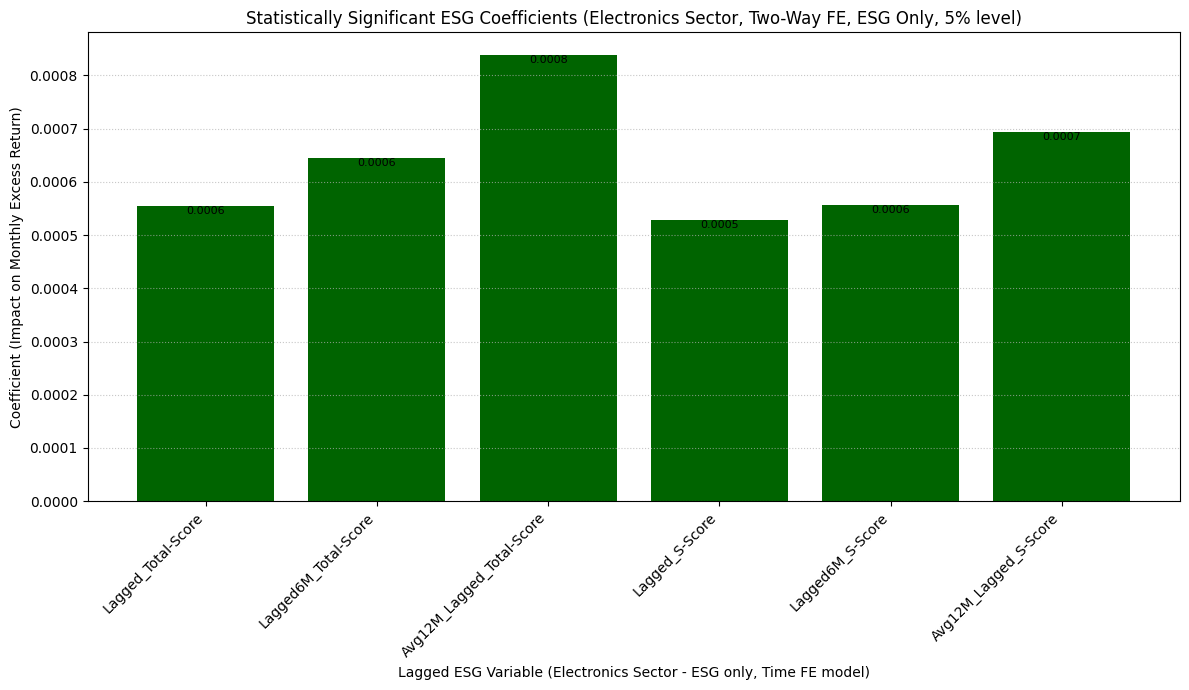

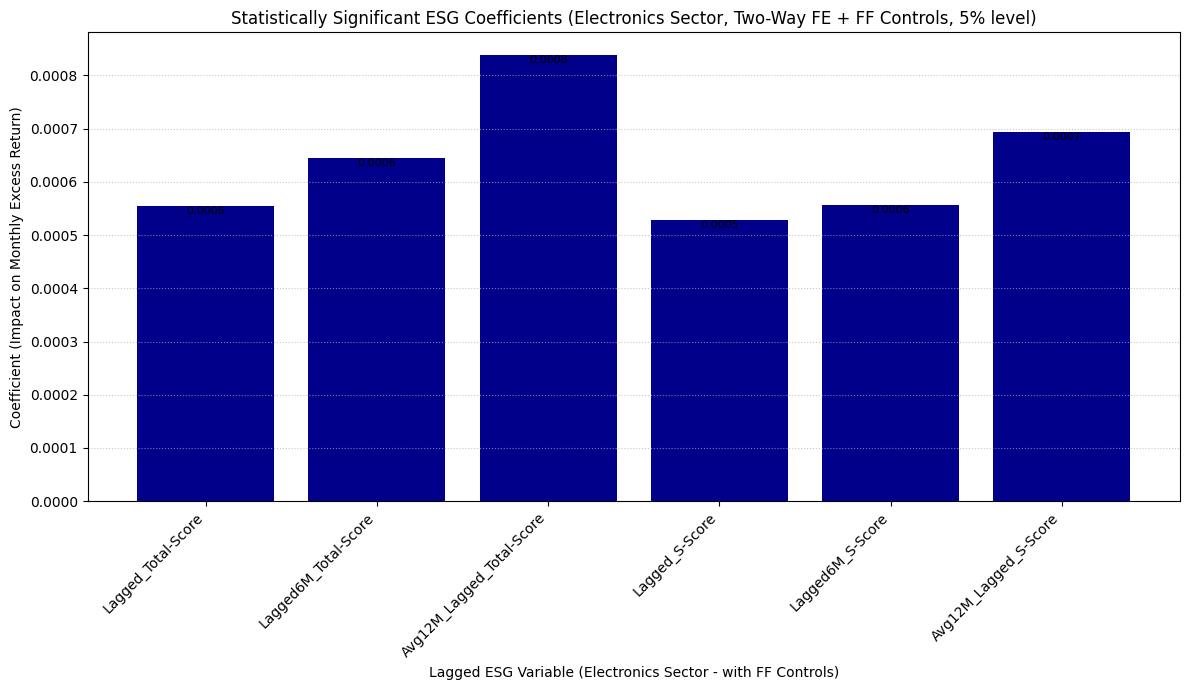



--- 5. Vector Autoregression (VAR) Analysis (RQ2: Dynamic Interplay for Electronics Sector) ---
  Constructing HML_ESG based on Lagged_Total-Score, aiming for 3 portfolios if data allows.
Shape of data for VAR analysis (var_data_merged) for Electronics Sector: (121, 7)

**VAR Data Visualizations for Electronics Sector:**


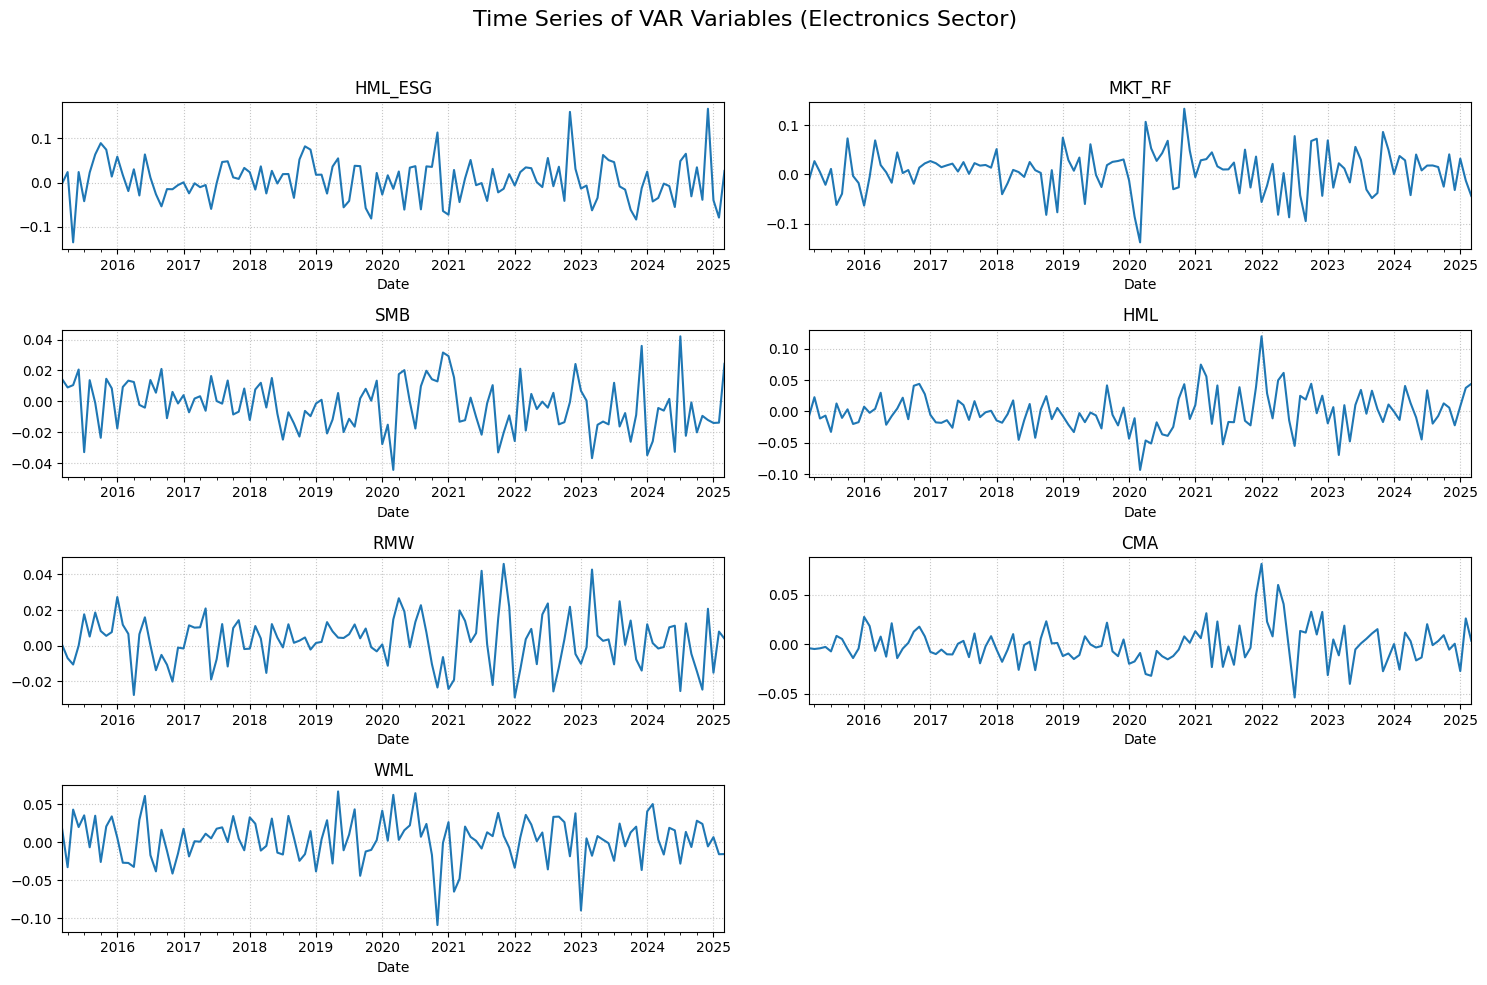

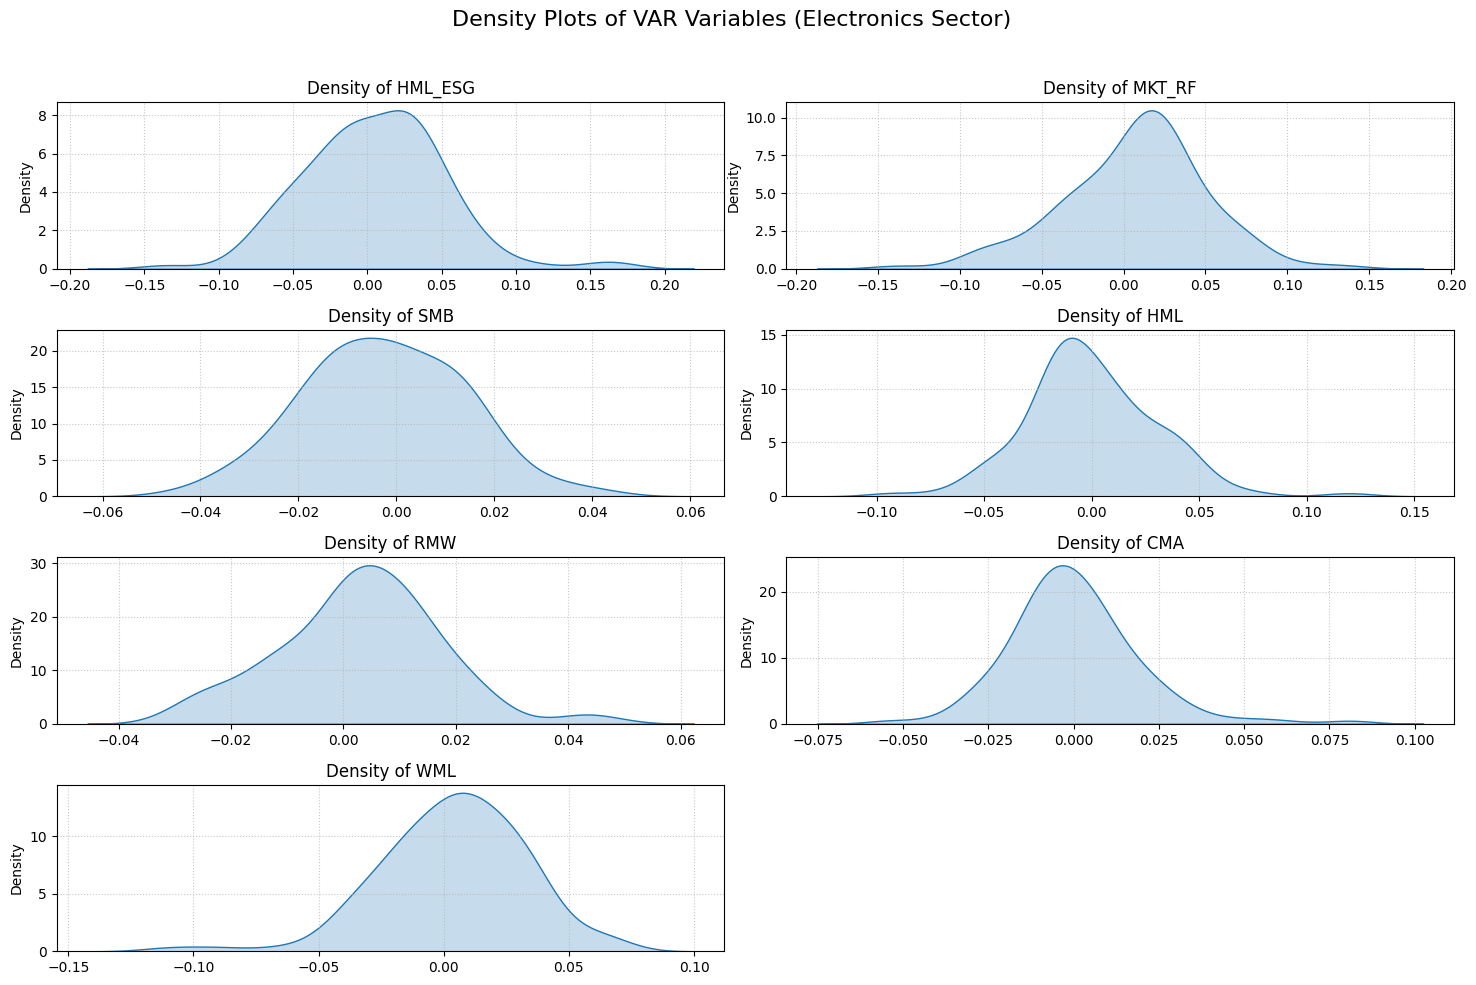


Scatter Plot Matrix for: HML_ESG, MKT_RF, SMB, HML


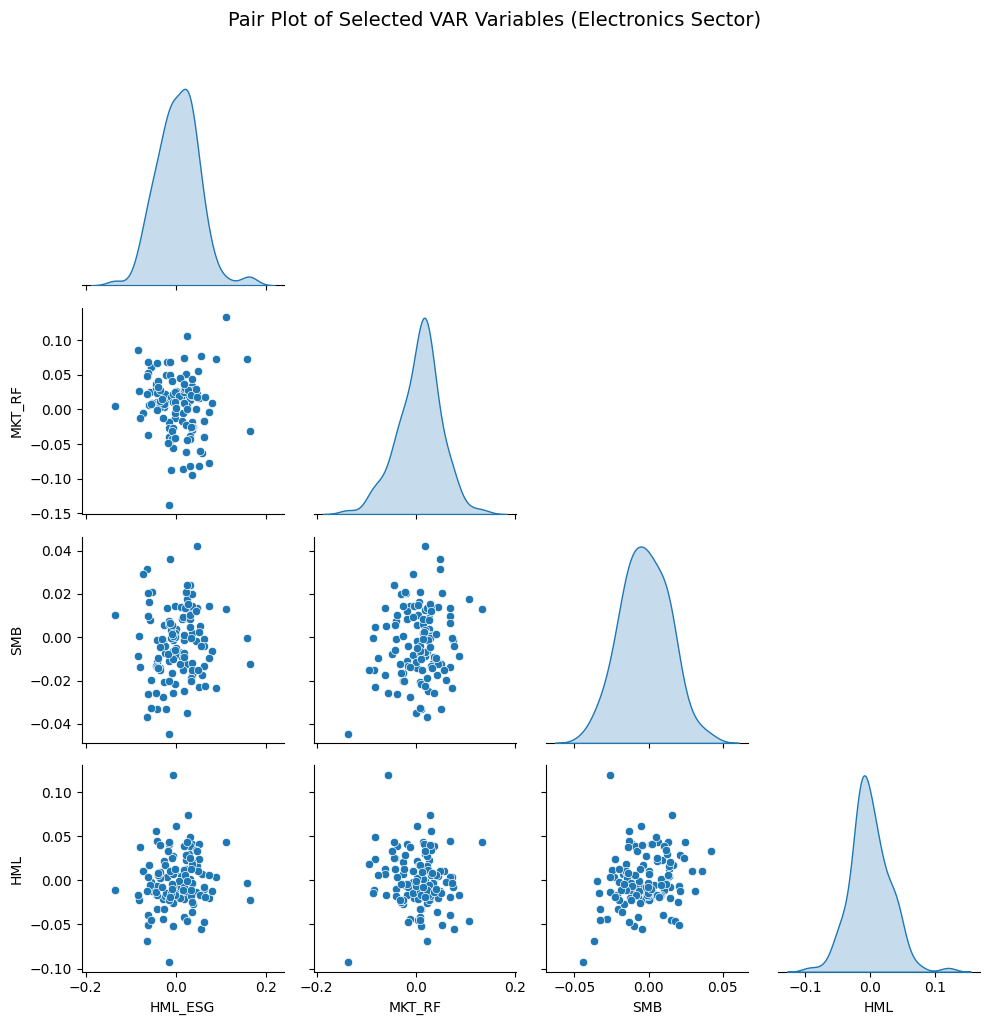

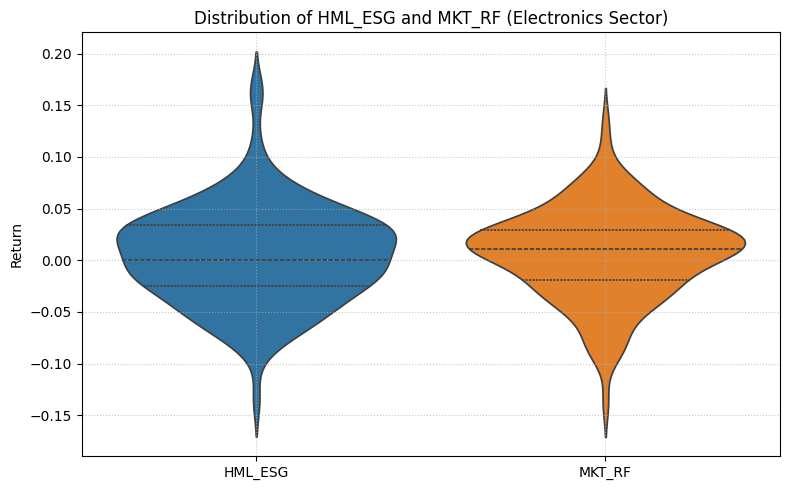

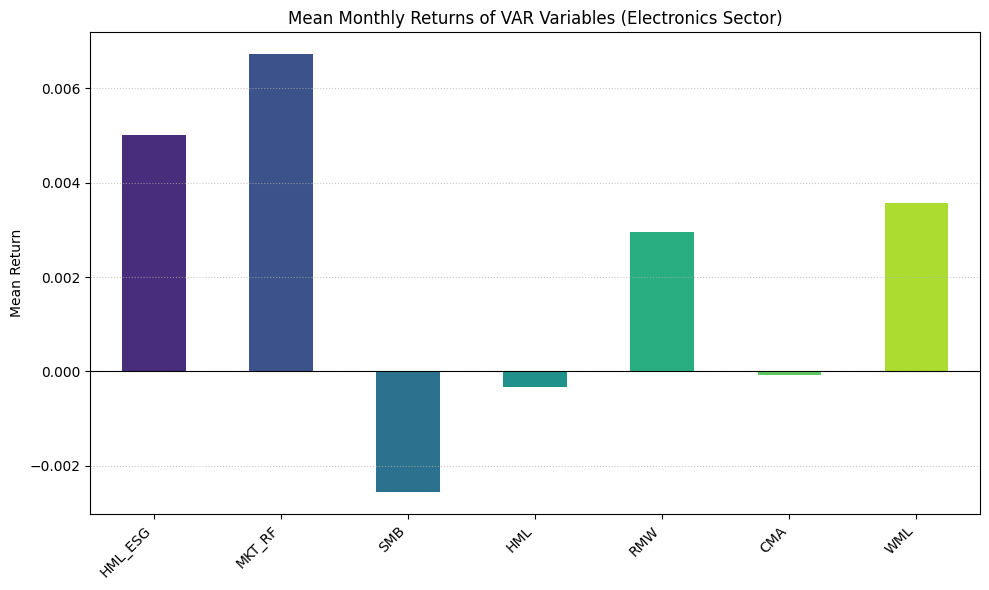


**VAR Model Diagnostics and Estimation for Electronics Sector:**
  1. Stationarity of VAR Inputs:
     - HML_ESG: ADF p-value=0.000 (Stationary)
     - MKT_RF: ADF p-value=0.000 (Stationary)
     - SMB: ADF p-value=0.000 (Stationary)
     - HML: ADF p-value=0.001 (Stationary)
     - RMW: ADF p-value=0.000 (Stationary)
     - CMA: ADF p-value=0.000 (Stationary)
     - WML: ADF p-value=0.000 (Stationary)

  2. VAR Lag Order Selection:
     Using maxlags=1.
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0     -53.42*     -53.26*  6.324e-24*     -53.35*
1      -52.98      -51.68   9.780e-24      -52.45
-------------------------------------------------
     Chosen VAR Lag Order (BIC): 1.

  3. VAR Residual Diagnostics - Durbin-Watson:
+------------+-----------------+
| Variable   |   Durbin-Watson |
+============+=================+
| HML_ESG    |          2.0327 |
+------------+----------

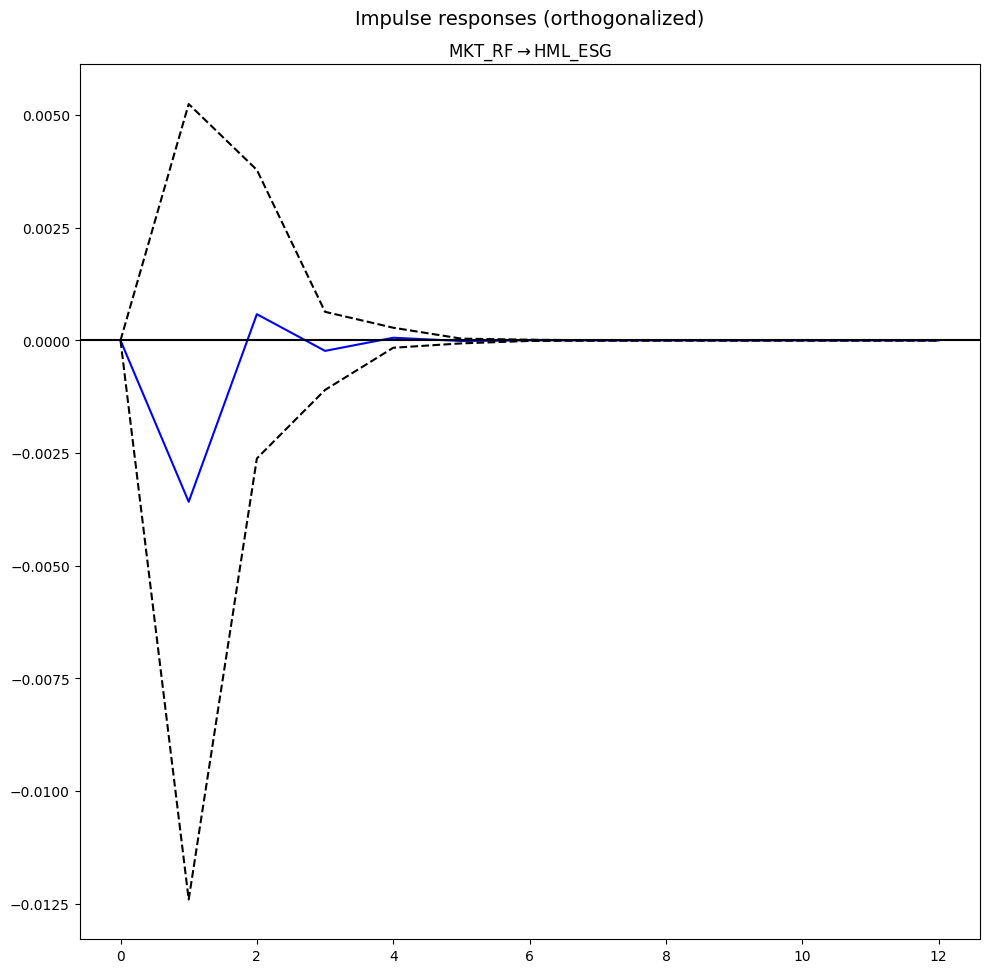

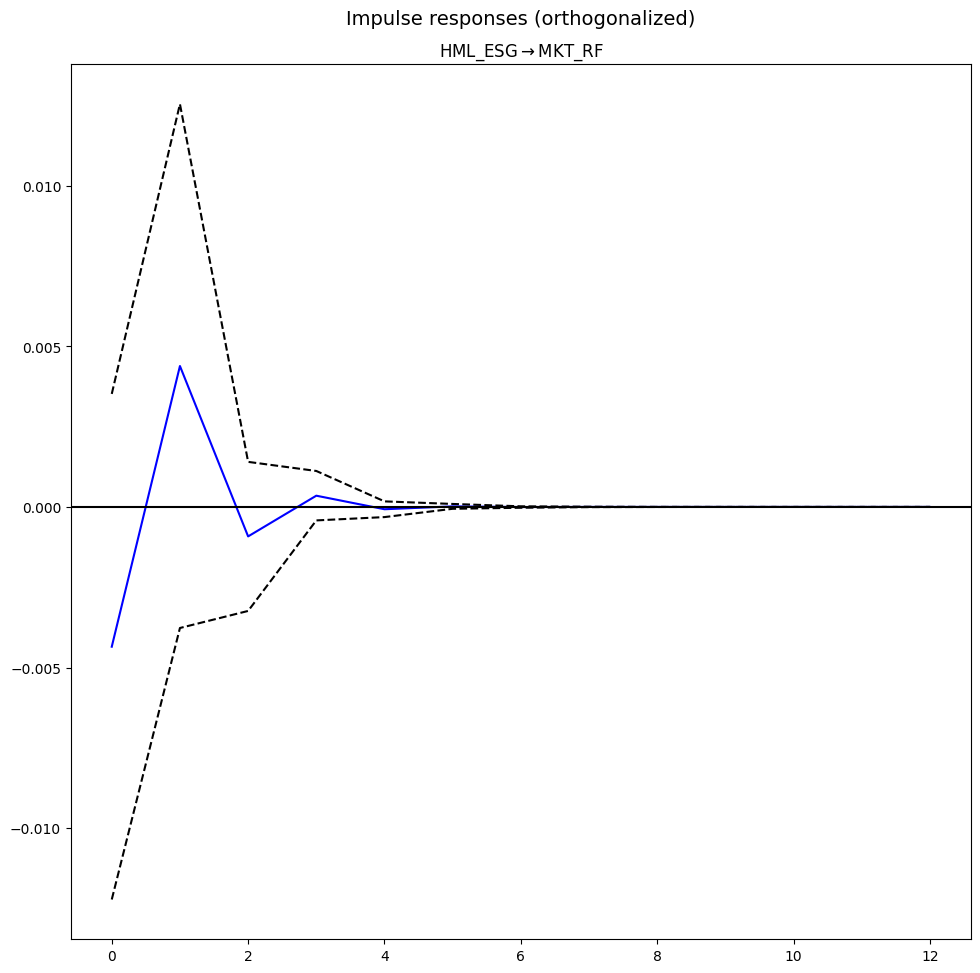

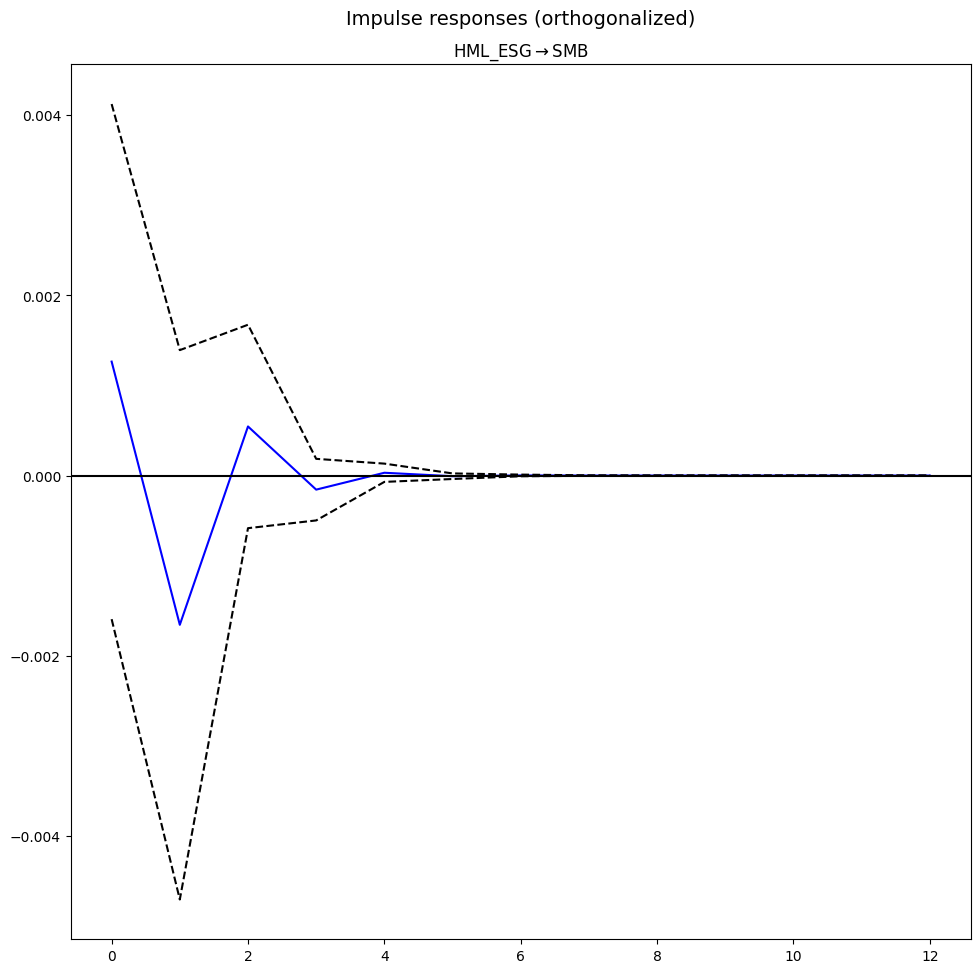


  6. Forecast Error Variance Decomposition (FEVD) Summary Tables:
FEVD for Electronics Sector (up to 12 periods):
FEVD for HML_ESG
       HML_ESG    MKT_RF       SMB       HML       RMW       CMA       WML
0     1.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
1     0.968353  0.005479  0.002327  0.000239  0.003094  0.015651  0.004856
2     0.967370  0.005616  0.002325  0.000246  0.003473  0.015733  0.005237
3     0.967307  0.005639  0.002337  0.000252  0.003475  0.015748  0.005242
4     0.967303  0.005640  0.002337  0.000252  0.003475  0.015749  0.005243
5     0.967303  0.005640  0.002337  0.000252  0.003475  0.015749  0.005243
6     0.967303  0.005640  0.002337  0.000252  0.003475  0.015749  0.005243
7     0.967303  0.005640  0.002337  0.000252  0.003475  0.015749  0.005243
8     0.967303  0.005640  0.002337  0.000252  0.003475  0.015749  0.005243
9     0.967303  0.005640  0.002337  0.000252  0.003475  0.015749  0.005243
10    0.967303  0.005640  0.002337  0.00025

In [19]:
# Install arch if running in Colab and it's not already installed
try:
    import arch
except ImportError:
    print("Installing arch library...")
    !pip install arch -q --no-input

import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from linearmodels.panel import PanelOLS, RandomEffects, PooledOLS
from scipy import stats
import io
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# --- 1. Setup and Data Loading ---
print("--- 1. Setup and Data Loading ---")
ff_file_path = '/content/Developed_5_Factors_Momentum.csv'
esg_file_path = '/content/historic_esg_scores_electronics.csv' # CHANGED FOR ELECTRONICS
SECTOR_NAME = "Electronics Sector" # CHANGED FOR ELECTRONICS
SECTOR_INDUSTRY_FOR_NARRATIVE = f"firms in the {SECTOR_NAME}"

try:
    ff_df = pd.read_csv(ff_file_path, sep=',')
    print(f"Fama-French data loaded successfully.")
except Exception as e: print(f"Error loading Fama-French CSV: {e}"); raise
if 'Date' not in ff_df.columns: raise ValueError("Date column missing in FF data.")
ff_df['Date'] = pd.to_datetime(ff_df['Date'], format='%m/%d/%y')
factor_cols_ff = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'WML']
for col_ff in factor_cols_ff: ff_df[col_ff] = ff_df[col_ff] / 100.0
ff_df = ff_df.rename(columns={'Mkt-RF': 'MKT_RF'})

try:
    esg_df = pd.read_csv(esg_file_path, sep=',') # Assuming CSV, check separator if issues
    print(f"ESG data for {SECTOR_NAME} loaded successfully.")
except Exception as e: print(f"Error loading ESG CSV for {SECTOR_NAME}: {e}"); raise

if 'Date' not in esg_df.columns: raise ValueError("Date column missing in ESG data.")
if 'Ticker' not in esg_df.columns: raise ValueError("Ticker column missing in ESG data.")
esg_df['Date'] = pd.to_datetime(esg_df['Date'], format='%m/%d/%y') # Ensure format matches CSV
tickers_from_esg = esg_df['Ticker'].unique().tolist()
print(f"Tickers found in ESG data: {tickers_from_esg}")

final_tickers_to_download = tickers_from_esg
start_date_prices = ff_df['Date'].min(); end_date_prices = max(ff_df['Date'].max(), esg_df['Date'].max())
stock_prices_df = pd.DataFrame()
print(f"Attempting to download stock prices for {len(final_tickers_to_download)} tickers from {start_date_prices - pd.DateOffset(months=1)} to {end_date_prices + pd.DateOffset(days=1)}")
downloaded_tickers_count = 0
for ticker in final_tickers_to_download:
    try:
        data = yf.download(ticker, start=start_date_prices - pd.DateOffset(months=1), end=end_date_prices + pd.DateOffset(days=1), progress=False, auto_adjust=True, timeout=30)
        if not data.empty and 'Close' in data.columns: stock_prices_df[ticker] = data['Close']; downloaded_tickers_count +=1
        elif data.empty : print(f"No data returned for {ticker} by yfinance.")
        else: print(f"Data for {ticker} downloaded but 'Close' column missing.")
    except Exception as e: print(f"yfinance error for {ticker}: {e}")
if stock_prices_df.empty: raise ValueError("No stock price data downloaded.")
print(f"\nStock prices downloaded for {downloaded_tickers_count} tickers.")
if downloaded_tickers_count < len(final_tickers_to_download): print(f"Warning: Could not download price data for all tickers. Expected {len(final_tickers_to_download)}, got {downloaded_tickers_count}"); print(f"Missing or problematic tickers: {list(set(final_tickers_to_download) - set(stock_prices_df.columns))}")

# --- 2. Data Preprocessing ---
print("\n--- 2. Data Preprocessing ---")
monthly_prices = stock_prices_df.resample('ME').last(); monthly_returns = monthly_prices.pct_change().dropna(how='all')
if monthly_returns.empty: raise ValueError("Monthly returns empty.")
stock_returns_long = monthly_returns.stack().reset_index(); stock_returns_long.columns = ['Date', 'Ticker', 'Stock_Return']
for df_to_process in [stock_returns_long, ff_df, esg_df]: df_to_process['Date'] = pd.to_datetime(df_to_process['Date']); df_to_process['Date'] = df_to_process['Date'].dt.to_period('M').dt.start_time

data_merged = pd.merge(stock_returns_long, ff_df, on='Date', how='left')
if 'RF' not in data_merged.columns: raise KeyError("'RF' column not found in Fama-French data after merge with returns.")
data_merged['Excess_Return'] = data_merged['Stock_Return'] - data_merged['RF']

esg_df_lagged = esg_df.copy(); esg_score_cols = ['Total-Score', 'E-Score', 'S-Score', 'G-Score']; all_esg_cols_to_process = [col for col in esg_score_cols if col in esg_df_lagged.columns]
for score_col in all_esg_cols_to_process:
    if score_col in esg_df_lagged.columns:
        if 'Score' in score_col: esg_df_lagged[score_col] = esg_df_lagged[score_col].replace(0, np.nan)
        esg_df_lagged[f'Lagged_{score_col}'] = esg_df_lagged.groupby('Ticker')[score_col].shift(1)
        esg_df_lagged[f'Lagged3M_{score_col}'] = esg_df_lagged.groupby('Ticker')[score_col].shift(3)
        esg_df_lagged[f'Lagged6M_{score_col}'] = esg_df_lagged.groupby('Ticker')[score_col].shift(6)
        esg_df_lagged[f'Avg12M_Lagged_{score_col}'] = esg_df_lagged.groupby('Ticker')[score_col].transform(lambda x: x.rolling(window=12, min_periods=max(1, 12//2)).mean().shift(1))

final_df = pd.merge(data_merged, esg_df_lagged, on=['Date', 'Ticker'], how='left')
if 'Excess_Return' not in final_df.columns: raise KeyError("FATAL: 'Excess_Return' is missing from final_df before dropna. Check merging steps.")

key_cols_for_dropna_list = ['Excess_Return', 'MKT_RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML']
lagged_esg_variants = []; [lagged_esg_variants.extend([f'Lagged_{s_col}', f'Lagged3M_{s_col}', f'Lagged6M_{s_col}', f'Avg12M_Lagged_{s_col}']) for s_col in all_esg_cols_to_process]
for lag_col in lagged_esg_variants:
    if lag_col in final_df.columns: key_cols_for_dropna_list.append(lag_col)
key_cols_for_dropna_list = list(set(key_cols_for_dropna_list)); key_cols_for_dropna_list = [col for col in key_cols_for_dropna_list if col in final_df.columns]

final_df_cleaned = final_df.dropna(subset=key_cols_for_dropna_list, how='any').copy()
if final_df_cleaned.empty: raise ValueError("Cleaned DataFrame (final_df_cleaned) is empty after dropna. Cannot proceed.")
if 'Excess_Return' not in final_df_cleaned.columns: raise KeyError("FATAL: 'Excess_Return' is missing from final_df_cleaned before set_index. Problem with dropna or earlier steps.")

final_df_cleaned = final_df_cleaned.set_index(['Ticker', 'Date'])
print(f"Shape of cleaned data for analysis (final_df_cleaned): {final_df_cleaned.shape}")
N_entities_final = final_df_cleaned.index.get_level_values(0).nunique(); print(f"Number of unique tickers in final_df_cleaned: {N_entities_final}")
print(f"Date range in final_df_cleaned: {final_df_cleaned.index.get_level_values(1).min()} to {final_df_cleaned.index.get_level_values(1).max()}")
print(f"Columns in final_df_cleaned AFTER set_index: {final_df_cleaned.columns.tolist()}")


# --- 3. Model Selection for Panel Data and Diagnostic Tests ---
print("\n\n--- 3. Model Selection for Panel Data and Diagnostic Tests ---")
chosen_panel_model_type = "Two-Way FE (Entity & Time) with Clustered SE (Default)"
test_summary_data = []
f_pooled_decision, hausman_decision, bp_decision = "Skipped", "Skipped", "Skipped"
if final_df_cleaned.empty or N_entities_final < 2:
    test_summary_data.append(["All Tests", "N/A", "Insufficient data/entities", "Defaulting to Two-Way FE"])
else:
    panel_test_esg_var = 'Lagged_Total-Score'; panel_test_ff_factors = ['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML']
    if panel_test_esg_var not in final_df_cleaned.columns or final_df_cleaned[panel_test_esg_var].isnull().all():
        available_lagged_esg = [c for c in final_df_cleaned.columns if c.startswith('Lagged_') and 'Score' in c and not final_df_cleaned[c].isnull().all()]
        if available_lagged_esg: panel_test_esg_var = available_lagged_esg[0]; print(f"Using {panel_test_esg_var} for panel model selection.")
        else: panel_test_esg_var = None; print(f"No suitable lagged ESG score for model selection. Defaulting model choice.")
    panel_test_exog_vars = []
    if panel_test_esg_var: panel_test_exog_vars = panel_test_ff_factors + [panel_test_esg_var]; panel_test_exog_vars = [v for v in panel_test_exog_vars if v in final_df_cleaned.columns]
    panel_test_data = pd.DataFrame()
    if panel_test_exog_vars:
        if 'Excess_Return' not in final_df_cleaned.columns: raise KeyError("'Excess_Return' NOT in final_df_cleaned.columns for panel_test_data.")
        missing_exog_for_test = [v for v in panel_test_exog_vars if v not in final_df_cleaned.columns]
        if missing_exog_for_test: print(f"Warning: Exog vars {missing_exog_for_test} missing from final_df_cleaned columns."); panel_test_exog_vars = [v for v in panel_test_exog_vars if v in final_df_cleaned.columns]
        if panel_test_exog_vars: # If still have exog vars after filtering
            try: panel_test_data = final_df_cleaned[['Excess_Return'] + panel_test_exog_vars].copy(); panel_test_data.dropna(inplace=True)
            except KeyError as e_key: print(f"KeyError during panel_test_data creation: {e_key}"); raise
    num_entities_test = panel_test_data.index.get_level_values(0).nunique() if not panel_test_data.empty else 0
    min_obs_for_tests = (len(panel_test_exog_vars) if panel_test_exog_vars else 0) + num_entities_test + 20
    if panel_test_data.empty or panel_test_data.shape[0] < min_obs_for_tests or num_entities_test < 2 :
        print(f"Insufficient data for full panel model selection tests (Obs: {panel_test_data.shape[0]}, Entities: {num_entities_test}). Defaulting to Two-Way FE.")
        f_pooled_decision, hausman_decision, bp_decision = "Default", "Default", "Default"; test_summary_data.append(["All Tests", "N/A", "Insufficient data", "Defaulting to Two-Way FE"])
    else:
        Y_paneltest = panel_test_data['Excess_Return']; X_paneltest_df = sm.add_constant(panel_test_data[panel_test_exog_vars]); fe_entity_res_for_test = None
        try: mod_fe_entity_test = PanelOLS(Y_paneltest, X_paneltest_df, entity_effects=True, time_effects=False); fe_entity_res_for_test = mod_fe_entity_test.fit(cov_type='clustered', cluster_entity=True)
        except Exception as e: f_pooled_decision = "Error"; test_summary_data.append(["F-test", "Error", str(e), f_pooled_decision]); print(f"Error F-test FE: {e}")
        if fe_entity_res_for_test and hasattr(fe_entity_res_for_test, 'f_pooled') and fe_entity_res_for_test.f_pooled is not None: f_pooled_decision = 'Entity FE significant' if fe_entity_res_for_test.f_pooled.pval < 0.05 else 'Entity FE not significant'; test_summary_data.append(["F-test (Entity FE vs Pooled OLS)", f"{fe_entity_res_for_test.f_pooled.stat:.4f}", f"{fe_entity_res_for_test.f_pooled.pval:.4f}", f_pooled_decision])
        else: f_pooled_decision = "Test N/A" if not f_pooled_decision == "Error" else f_pooled_decision; test_summary_data.append(["F-test", "N/A", "N/A", f_pooled_decision])
        try:
            if fe_entity_res_for_test and panel_test_esg_var in X_paneltest_df.columns :
                mod_re_test = RandomEffects(Y_paneltest, X_paneltest_df); re_res_for_test = mod_re_test.fit(cov_type='clustered', cluster_entity=True)
                fe_coeff = fe_entity_res_for_test.params.get(panel_test_esg_var, np.nan); re_coeff = re_res_for_test.params.get(panel_test_esg_var, np.nan)
                diff = fe_coeff - re_coeff if not (pd.isna(fe_coeff) or pd.isna(re_coeff)) else np.nan; note_h = f"FE:{fe_coeff:.4f}, RE:{re_coeff:.4f}. Diff:{diff:.4f}"
                hausman_decision = "FE preferred (F-test sig.)" if f_pooled_decision.startswith('Entity FE significant') else "Choice less clear (F-test not sig.)"
                test_summary_data.append(["Hausman (Informal)", "Comparison", note_h, hausman_decision])
            elif not fe_entity_res_for_test: hausman_decision = "Skipped (FE failed)"; test_summary_data.append(["Hausman (Informal)", "N/A", "FE model failed", hausman_decision])
            else: hausman_decision = "Skipped (ESG var not in X)"; test_summary_data.append(["Hausman (Informal)", "N/A", "ESG var issue", hausman_decision])
        except Exception as e: hausman_decision = "Error"; test_summary_data.append(["Hausman (Informal)", "Error", str(e), hausman_decision]); print(f"Error Hausman: {e}")
        try:
            if fe_entity_res_for_test:
                bp_exog = fe_entity_res_for_test.model.exog.dataframe if hasattr(fe_entity_res_for_test.model.exog, 'dataframe') else fe_entity_res_for_test.model.exog.ndarray
                bp_stat, bp_pval, _, _ = het_breuschpagan(fe_entity_res_for_test.resids, bp_exog)
                bp_decision = 'Heteroskedasticity present' if bp_pval < 0.05 else 'Homoskedasticity'
                test_summary_data.append([f"Breusch-Pagan (Entity FE resid)", f"LM:{bp_stat:.2f}", f"Pval:{bp_pval:.3f}", bp_decision])
            else: bp_decision = "Skipped (FE failed)"; test_summary_data.append(["Breusch-Pagan", "N/A", "FE model failed", bp_decision])
        except Exception as e: bp_decision = "Error"; test_summary_data.append(["Breusch-Pagan", "Error", str(e), bp_decision]); print(f"Error BP: {e}")
print("\n**Table: Panel Model Specification Tests Summary**"); print(tabulate(test_summary_data, headers=["Test", "Statistic", "P-value/Note", "Conclusion"], tablefmt="grid"))
print(f"\nModel Choice Justification for Panel Regressions (RQ1) for {SECTOR_NAME}:")
if f_pooled_decision.startswith('Entity FE significant'): print("  - F-test: Entity FE significant, supports FE over Pooled OLS.")
elif f_pooled_decision.startswith('Entity FE not significant'): print("  - F-test: Entity FE not significant. RE/Pooled OLS might be considered, but Time FE often vital.")
elif f_pooled_decision in ["Default", "Skipped", "Test N/A"]: print(f"  - F-test for entity effects was {f_pooled_decision.lower()} due to data limitations or test unavailability.")
else: print(f"  - F-test: {f_pooled_decision}.")
if hausman_decision.startswith("FE preferred"): print(f"  - Hausman (Informal): {hausman_decision}, supports FE over RE.")
elif hausman_decision not in ["Skipped", "Error", "Default", "Skipped (FE failed)", "Skipped (ESG var not in X)"]: print(f"  - Hausman (Informal): {hausman_decision}.")
if bp_decision.startswith('Heteroskedasticity'): print("  - Breusch-Pagan: Heteroskedasticity present (use robust SE).")
elif bp_decision.startswith('Homoskedasticity'): print("  - Breusch-Pagan: Homoskedasticity (robust SE still good practice).")
elif bp_decision not in ["Default", "Skipped", "Skipped (FE failed)"]: print(f"  - Breusch-Pagan: {bp_decision}.")
print(f"  - **Decision for RQ1 ({SECTOR_NAME}):** Given the importance of time-varying shocks and common practice, {chosen_panel_model_type} is adopted, but results from other models are presented for robustness.")


# --- 4. Panel Data Models (RQ1: ESG Impact on Returns) ---
print(f"\n\n--- 4. Panel Data Models (RQ1: ESG Impact on Returns for {SECTOR_NAME}) ---")
panel_results_summary_for_chart_data = []
all_panel_model_results = {}
significant_twoway_fe_with_ff_results = []
sub_period_results_summary = [] # Initialize for sub-period results

if final_df_cleaned.empty: print(f"Skipping panel models for {SECTOR_NAME}: final_df_cleaned is empty.")
else:
    esg_vars_to_test_panel = []; all_esg_cols_to_process_sec4 = [col for col in esg_score_cols if col in final_df_cleaned.columns]
    for s_col_panel in all_esg_cols_to_process_sec4: esg_vars_to_test_panel.extend([f'Lagged_{s_col_panel}', f'Lagged3M_{s_col_panel}', f'Lagged6M_{s_col_panel}', f'Avg12M_Lagged_{s_col_panel}'])
    esg_vars_to_test_panel = [v for v in esg_vars_to_test_panel if v in final_df_cleaned.columns and final_df_cleaned[v].nunique(dropna=True) > 1]
    ff_factors_for_panel = ['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML']
    if not esg_vars_to_test_panel: print(f"No valid ESG variables with variance found for panel regression in {SECTOR_NAME}.")
    else:
        for esg_var in esg_vars_to_test_panel:
            print(f"\n--- Panel Regressions for {SECTOR_NAME} using: {esg_var} ---")
            current_exog_panel_esg_only = [esg_var]; panel_data_subset_esg_only = final_df_cleaned[['Excess_Return'] + current_exog_panel_esg_only].copy().dropna()
            current_exog_panel_esg_ff = [esg_var] + [ff for ff in ff_factors_for_panel if ff in final_df_cleaned.columns]; panel_data_subset_esg_ff = final_df_cleaned[['Excess_Return'] + current_exog_panel_esg_ff].copy().dropna()
            regression_setups = [{"name_suffix": "(ESG only, FF absorbed by Time FE)", "exog_vars": current_exog_panel_esg_only, "data": panel_data_subset_esg_only}, {"name_suffix": "(ESG + FF controls)", "exog_vars": current_exog_panel_esg_ff, "data": panel_data_subset_esg_ff}]
            for reg_setup in regression_setups:
                print(f"\n  **Specification: {esg_var} {reg_setup['name_suffix']}**"); panel_data_subset = reg_setup['data']; current_exog_panel = reg_setup['exog_vars']
                if panel_data_subset.empty: print(f"    Skipping {esg_var} {reg_setup['name_suffix']}: No data after NA drop."); continue
                num_entities_model = panel_data_subset.index.get_level_values(0).nunique(); num_time_periods_model = panel_data_subset.index.get_level_values(1).nunique()
                if num_entities_model < 1: print(f"    Skipping {esg_var} {reg_setup['name_suffix']}: Not enough entities."); continue
                X_panel_df = sm.add_constant(panel_data_subset[current_exog_panel]); Y_panel = panel_data_subset['Excess_Return']
                model_specs_to_run = []
                min_obs_pooled = len(current_exog_panel) + 1 + 10; min_obs_re = len(current_exog_panel) + 1 + 10; min_obs_fe_entity = len(current_exog_panel) + num_entities_model + 10; min_obs_fe_time = len(current_exog_panel) + num_time_periods_model + 10; min_obs_fe_twoway = len(current_exog_panel) + num_entities_model + num_time_periods_model + 10
                if panel_data_subset.shape[0] >= min_obs_pooled: model_specs_to_run.append({"name": "PooledOLS", "model_type": PooledOLS, "effects": {}})
                if panel_data_subset.shape[0] >= min_obs_re and num_entities_model > len(current_exog_panel) +1: model_specs_to_run.append({"name": "RandomEffects (Entity)", "model_type": RandomEffects, "effects": {}})
                if panel_data_subset.shape[0] >= min_obs_fe_entity and num_entities_model >= 2: model_specs_to_run.append({"name": "FixedEffects (Entity)", "model_type": PanelOLS, "effects": {'entity_effects':True, 'time_effects':False, 'drop_absorbed':True}})
                include_time_fe_models = True
                if any(ff_col in current_exog_panel for ff_col in ff_factors_for_panel): print("    Note: FF factors are direct regressors. Time FE models might be redundant or cause multicollinearity if all FF are pure time series variations.")
                if include_time_fe_models:
                    if panel_data_subset.shape[0] >= min_obs_fe_time and num_time_periods_model >= len(current_exog_panel) + 2: model_specs_to_run.append({"name": "FixedEffects (Time)", "model_type": PanelOLS, "effects": {'entity_effects':False, 'time_effects':True, 'drop_absorbed':True}})
                    if panel_data_subset.shape[0] >= min_obs_fe_twoway and num_entities_model >= 2 and num_time_periods_model >= len(current_exog_panel) + num_entities_model + 2 : model_specs_to_run.append({"name": "FixedEffects (Two-Way)", "model_type": PanelOLS, "effects": {'entity_effects':True, 'time_effects':True, 'drop_absorbed':True}})
                if not model_specs_to_run: print(f"    Skipping {esg_var} {reg_setup['name_suffix']}: Not enough data for any robust panel model."); continue
                for spec in model_specs_to_run:
                    print(f"\n    -- Running Model: {spec['name']} for {esg_var} {reg_setup['name_suffix']} --")
                    try:
                        if spec['model_type'] == PooledOLS or spec['model_type'] == RandomEffects: mod = spec['model_type'](Y_panel, X_panel_df)
                        else: mod = spec['model_type'](Y_panel, X_panel_df, **spec['effects'])
                        res_cov_type = 'clustered'; res_cluster_entity = True; res_cluster_time = False
                        if spec['name'] == "FixedEffects (Time)": res_cluster_time = True; res_cluster_entity = False
                        elif spec['name'] == "FixedEffects (Two-Way)": res_cluster_time = True
                        if spec['name'] == "FixedEffects (Two-Way)" and res_cluster_entity and res_cluster_time:
                            try: res = mod.fit(cov_type=res_cov_type, cluster_entity=res_cluster_entity, cluster_time=res_cluster_time)
                            except Exception: res = mod.fit(cov_type=res_cov_type, cluster_entity=True); print(f"      Note: Used entity-clustered SE for Two-Way FE.")
                        elif res_cluster_entity and not res_cluster_time: res = mod.fit(cov_type=res_cov_type, cluster_entity=True)
                        elif res_cluster_time and not res_cluster_entity: res = mod.fit(cov_type=res_cov_type, cluster_time=True)
                        else: res = mod.fit(cov_type=res_cov_type, cluster_entity=True)
                        print(res); all_panel_model_results.setdefault(esg_var + reg_setup['name_suffix'], {})[spec['name']] = res.summary.as_text()
                        if esg_var in res.params and spec['name'] == "FixedEffects (Two-Way)":
                            coeff = res.params[esg_var]; pval = res.pvalues[esg_var]; significant = pval < 0.05
                            if reg_setup['name_suffix'] == "(ESG only, FF absorbed by Time FE)": panel_results_summary_for_chart_data.append({'ESG_Variable': esg_var, 'Coefficient': coeff, 'P_Value': pval, 'Significant_5pct': significant, 'Sector': SECTOR_NAME})
                            elif reg_setup['name_suffix'] == "(ESG + FF controls)" and significant: significant_twoway_fe_with_ff_results.append({'ESG_Variable': esg_var, 'Coefficient': coeff, 'P_Value': pval, 'Significant_5pct': significant, 'Sector': SECTOR_NAME, 'Model': 'Two-Way FE + FF'})
                            print(f"      Summary for {esg_var} ({spec['name']}, {reg_setup['name_suffix']}): Coeff={coeff:.6f} (P-val={pval:.4f}), Significant (5%): {significant}")
                    except Exception as e: print(f"      Error running {spec['name']} for {esg_var} {reg_setup['name_suffix']}: {e}"); all_panel_model_results.setdefault(esg_var + reg_setup['name_suffix'], {})[spec['name']] = f"Error: {e}"
        if panel_results_summary_for_chart_data:
            significant_esg_for_subperiod = [item['ESG_Variable'] for item in panel_results_summary_for_chart_data if item['Significant_5pct']]
            if significant_esg_for_subperiod:
                print("\n\n--- 4.A Sub-period Robustness Check (Two-Way FE, ESG only) ---"); temp_df_sub = final_df_cleaned.copy()
                if not isinstance(temp_df_sub.index.get_level_values(1), pd.DatetimeIndex): temp_df_sub.index = pd.MultiIndex.from_arrays([temp_df_sub.index.get_level_values(0), pd.to_datetime(temp_df_sub.index.get_level_values(1).to_timestamp())], names=['Ticker', 'Date'])
                unique_dates = sorted(temp_df_sub.index.get_level_values(1).unique())
                if len(unique_dates) >= 24:
                    median_date_idx = len(unique_dates) // 2; median_date = unique_dates[median_date_idx]; df_sub1 = temp_df_sub[temp_df_sub.index.get_level_values(1) <= median_date]; df_sub2 = temp_df_sub[temp_df_sub.index.get_level_values(1) > median_date]
                    for period_name, df_period in [("First Half", df_sub1), ("Second Half", df_sub2)]:
                        print(f"\n  -- {period_name} (Split at {median_date.strftime('%Y-%m-%d')}) --")
                        if df_period.empty: print(f"    Skipping {period_name}: No data in this sub-period after split."); continue
                        for esg_var_sub in significant_esg_for_subperiod:
                            current_exog_panel_sub = [esg_var_sub]
                            if 'Excess_Return' not in df_period.columns or esg_var_sub not in df_period.columns: print(f"    Skipping {esg_var_sub} for {period_name}: Required columns missing from df_period."); continue
                            panel_data_subset_sub = df_period[['Excess_Return'] + current_exog_panel_sub].copy().dropna()
                            num_entities_sub = panel_data_subset_sub.index.get_level_values(0).nunique(); num_time_sub = panel_data_subset_sub.index.get_level_values(1).nunique()
                            min_obs_fe_twoway_sub = len(current_exog_panel_sub) + num_entities_sub + num_time_sub + 5
                            if panel_data_subset_sub.empty or num_entities_sub < 2 or num_time_sub < (len(current_exog_panel_sub) + 2) or panel_data_subset_sub.shape[0] < min_obs_fe_twoway_sub : print(f"    Skipping {esg_var_sub} for {period_name}: Insufficient data (Obs: {panel_data_subset_sub.shape[0]}, Entities: {num_entities_sub}, Time: {num_time_sub}) for Two-Way FE."); continue
                            X_panel_sub = sm.add_constant(panel_data_subset_sub[current_exog_panel_sub]); Y_panel_sub = panel_data_subset_sub['Excess_Return']
                            try:
                                mod_sub = PanelOLS(Y_panel_sub, X_panel_sub, entity_effects=True, time_effects=True, drop_absorbed=True)
                                try: res_sub = mod_sub.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
                                except Exception: print(f"      Note: Used entity-clustered SE for {esg_var_sub} in {period_name} (Two-Way FE fallback)."); res_sub = mod_sub.fit(cov_type='clustered', cluster_entity=True)
                                if esg_var_sub in res_sub.params: coeff_sub = res_sub.params[esg_var_sub]; pval_sub = res_sub.pvalues[esg_var_sub]; significant_sub = pval_sub < 0.05; sub_period_results_summary.append({'Period': period_name, 'ESG_Variable': esg_var_sub, 'Coefficient': coeff_sub, 'P_Value': pval_sub, 'Significant_5pct': significant_sub, 'N_Obs': res_sub.nobs, 'R_squared': res_sub.rsquared}); print(f"    {esg_var_sub}: Coeff={coeff_sub:.6f} (P-val={pval_sub:.4f}), N={res_sub.nobs}, R2={res_sub.rsquared:.4f}, Significant (5%): {significant_sub}")
                                else: print(f"    {esg_var_sub}: Variable absorbed or error in sub-period {period_name}.")
                            except Exception as e_sub_model: print(f"    Error running model for {esg_var_sub} in {period_name}: {e_sub_model}")
                    if sub_period_results_summary: print("\nSub-period Analysis Summary Table:"); sub_period_df = pd.DataFrame(sub_period_results_summary); print(tabulate(sub_period_df, headers="keys", tablefmt="grid", floatfmt=(".6f", ".4f", ".0f", ".4f")))
                else: print("  Skipping sub-period analysis: Not enough unique dates for a meaningful split (require at least 24 months).")
        else: print("No initially significant ESG variables from Two-Way FE (ESG only) to check in sub-periods.")
if panel_results_summary_for_chart_data:
    panel_results_df_chart = pd.DataFrame(panel_results_summary_for_chart_data); significant_results_chart = panel_results_df_chart[panel_results_df_chart['Significant_5pct']]
    if not significant_results_chart.empty: plt.figure(figsize=(12, 7)); bars = plt.bar(significant_results_chart['ESG_Variable'], significant_results_chart['Coefficient'], color=['darkgreen' if x > 0 else 'darkred' for x in significant_results_chart['Coefficient']]); plt.ylabel('Coefficient (Impact on Monthly Excess Return)'); plt.xlabel(f'Lagged ESG Variable ({SECTOR_NAME} - ESG only, Time FE model)'); plt.title(f'Statistically Significant ESG Coefficients ({SECTOR_NAME}, Two-Way FE, ESG Only, 5% level)'); plt.xticks(rotation=45, ha="right"); plt.grid(axis='y', linestyle=':', alpha=0.7); [plt.text(bar_item.get_x() + bar_item.get_width()/2.0, bar_item.get_height(), f'{bar_item.get_height():.4f}', va='bottom' if bar_item.get_height() < 0 else 'top', ha='center', fontsize=8) for bar_item in bars]; plt.tight_layout(); plt.show()
    else: print(f"\nNo ESG variables found statistically significant at 5% in Two-Way FE PanelOLS models (ESG only) for {SECTOR_NAME} for chart.")
else: print(f"\nNo Two-Way FE panel regression results (ESG only) to visualize for {SECTOR_NAME}.")
if significant_twoway_fe_with_ff_results:
    panel_results_ff_chart = pd.DataFrame(significant_twoway_fe_with_ff_results)
    plt.figure(figsize=(12, 7)); bars_ff = plt.bar(panel_results_ff_chart['ESG_Variable'], panel_results_ff_chart['Coefficient'], color=['darkblue' if x > 0 else 'maroon' for x in panel_results_ff_chart['Coefficient']]); plt.ylabel('Coefficient (Impact on Monthly Excess Return)'); plt.xlabel(f'Lagged ESG Variable ({SECTOR_NAME} - with FF Controls)'); plt.title(f'Statistically Significant ESG Coefficients ({SECTOR_NAME}, Two-Way FE + FF Controls, 5% level)'); plt.xticks(rotation=45, ha="right"); plt.grid(axis='y', linestyle=':', alpha=0.7); [plt.text(bar_item.get_x() + bar_item.get_width()/2.0, bar_item.get_height(), f'{bar_item.get_height():.4f}', va='bottom' if bar_item.get_height() < 0 else 'top', ha='center', fontsize=8) for bar_item in bars_ff]; plt.tight_layout(); plt.show()
else: print(f"\nNo ESG variables found statistically significant at 5% in Two-Way FE PanelOLS models (with FF controls) for {SECTOR_NAME} for chart.")

# --- 5. Vector Autoregression (VAR) Analysis ---
print(f"\n\n--- 5. Vector Autoregression (VAR) Analysis (RQ2: Dynamic Interplay for {SECTOR_NAME}) ---")
var_success_flag = False; fevd = None; irf_periods = None; best_lag_order_var_val = None
var_data_merged = pd.DataFrame(); gc_table_data = []
primary_esg_for_hml_var = 'Lagged_Total-Score'
if primary_esg_for_hml_var not in final_df_cleaned.columns or final_df_cleaned[primary_esg_for_hml_var].isnull().all():
    available_esg_for_hml = [c for c in final_df_cleaned.columns if c.startswith('Lagged_') and 'Score' in c and not final_df_cleaned[c].isnull().all()]
    if available_esg_for_hml: primary_esg_for_hml_var = available_esg_for_hml[0]; print(f"Using {primary_esg_for_hml_var} for HML_ESG in VAR.")
    else: primary_esg_for_hml_var = None; print(f"Skipping VAR: No suitable non-empty lagged ESG score for HML_ESG.")
if not final_df_cleaned.empty and primary_esg_for_hml_var is not None and N_entities_final > 0 :
    def get_portfolio_returns_simple_var(data_panel_indexed_func, esg_col_name_sort_func, num_portfolios_target=2):
        if esg_col_name_sort_func not in data_panel_indexed_func.columns: return pd.DataFrame()
        if data_panel_indexed_func[esg_col_name_sort_func].isnull().all(): return pd.DataFrame()
        data_for_sort_local = data_panel_indexed_func.reset_index(); portfolio_dfs_local = []
        print(f"  Constructing HML_ESG based on {esg_col_name_sort_func}, aiming for {num_portfolios_target} portfolios if data allows.")
        for date_val_local, group_local in data_for_sort_local.groupby('Date'):
            valid_esg_scores_group = group_local.dropna(subset=[esg_col_name_sort_func, 'Excess_Return'])
            n_firms_this_period = valid_esg_scores_group['Ticker'].nunique()
            if n_firms_this_period >= num_portfolios_target * 2 and n_firms_this_period >= 5 and num_portfolios_target >=5 : n_portfolios_this_period = 5
            elif n_firms_this_period >= num_portfolios_target * 2 and n_firms_this_period >= 3 and num_portfolios_target >=3: n_portfolios_this_period = 3
            else: n_portfolios_this_period = 2
            if valid_esg_scores_group[esg_col_name_sort_func].nunique() < n_portfolios_this_period or valid_esg_scores_group.shape[0] < n_portfolios_this_period : continue
            try:
                labels_local = [f'P{i+1}' for i in range(n_portfolios_this_period)]
                valid_esg_scores_group['Portfolio'] = pd.qcut(valid_esg_scores_group[esg_col_name_sort_func].rank(method='first', pct=True), n_portfolios_this_period, labels=labels_local, duplicates='drop')
                if valid_esg_scores_group['Portfolio'].nunique() < n_portfolios_this_period: continue
                port_returns_this_date_local = valid_esg_scores_group.groupby('Portfolio', observed=False)['Excess_Return'].mean()
                if labels_local[0] in port_returns_this_date_local and labels_local[-1] in port_returns_this_date_local:
                    portfolio_dfs_local.append(pd.DataFrame([{'Date': date_val_local, 'HML_ESG_Ret_VAR': port_returns_this_date_local[labels_local[-1]] - port_returns_this_date_local[labels_local[0]]}]))
            except Exception: continue
        if not portfolio_dfs_local: print(f"Warning: No HML_ESG portfolio returns calculated for {SECTOR_NAME} using {esg_col_name_sort_func}."); return pd.DataFrame()
        return pd.concat(portfolio_dfs_local).set_index('Date').dropna(subset=['HML_ESG_Ret_VAR'])
    hml_portfolios_target = 5 if N_entities_final >= 15 else (3 if N_entities_final >= 9 else 2)
    portfolio_returns_for_var = get_portfolio_returns_simple_var(final_df_cleaned, primary_esg_for_hml_var, num_portfolios_target=hml_portfolios_target)
    if not portfolio_returns_for_var.empty and 'HML_ESG_Ret_VAR' in portfolio_returns_for_var.columns:
        var_data_hml_esg = portfolio_returns_for_var[['HML_ESG_Ret_VAR']].rename(columns={'HML_ESG_Ret_VAR':'HML_ESG'})
        ff_df_for_var_join = ff_df.set_index('Date'); var_data_hml_esg.index = pd.to_datetime(var_data_hml_esg.index)
        var_data_merged = var_data_hml_esg.join(ff_df_for_var_join[['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML']], how='inner').dropna()
        print(f"Shape of data for VAR analysis (var_data_merged) for {SECTOR_NAME}: {var_data_merged.shape}")
        if var_data_merged.shape[0] < 30: print(f"Not enough observations ({var_data_merged.shape[0]}) for VAR analysis in {SECTOR_NAME}. Min 30 required.")
        else:
            var_success_flag = True
            print(f"\n**VAR Data Visualizations for {SECTOR_NAME}:**"); plt.figure(figsize=(15, 10))
            for i, col in enumerate(var_data_merged.columns): plt.subplot((len(var_data_merged.columns) + 1) // 2, 2, i + 1); var_data_merged[col].plot(title=col); plt.grid(True, linestyle=':', alpha=0.7)
            plt.suptitle(f'Time Series of VAR Variables ({SECTOR_NAME})', fontsize=16); plt.tight_layout(rect=[0,0,1,0.96]); plt.show()
            plt.figure(figsize=(15, 10))
            for i, col in enumerate(var_data_merged.columns): plt.subplot((len(var_data_merged.columns) + 1) // 2, 2, i + 1); sns.kdeplot(var_data_merged[col], fill=True); plt.title(f'Density of {col}'); plt.xlabel(''); plt.ylabel('Density'); plt.grid(True, linestyle=':', alpha=0.7)
            plt.suptitle(f'Density Plots of VAR Variables ({SECTOR_NAME})', fontsize=16); plt.tight_layout(rect=[0,0,1,0.96]); plt.show()
            pair_plot_vars = ['HML_ESG', 'MKT_RF'] + [c for c in ['SMB', 'HML', 'WML'] if c in var_data_merged.columns][:2]; pair_plot_vars = [v for v in pair_plot_vars if v in var_data_merged.columns]
            if len(pair_plot_vars) > 1:
                print(f"\nScatter Plot Matrix for: {', '.join(pair_plot_vars)}");
                try: sns.pairplot(var_data_merged[pair_plot_vars], diag_kind='kde', corner=True); plt.suptitle(f'Pair Plot of Selected VAR Variables ({SECTOR_NAME})', y=1.02, fontsize=14); plt.tight_layout(); plt.show()
                except Exception as e_pairplot: print(f"Could not generate pairplot: {e_pairplot}")
            if 'HML_ESG' in var_data_merged.columns and 'MKT_RF' in var_data_merged.columns: plt.figure(figsize=(8, 5)); sns.violinplot(data=var_data_merged[['HML_ESG', 'MKT_RF']], inner='quartile'); plt.title(f'Distribution of HML_ESG and MKT_RF ({SECTOR_NAME})'); plt.ylabel('Return'); plt.grid(True, linestyle=':', alpha=0.7); plt.tight_layout(); plt.show()
            plt.figure(figsize=(10, 6)); var_data_merged.mean().plot(kind='bar', color=sns.color_palette("viridis", len(var_data_merged.columns))); plt.title(f'Mean Monthly Returns of VAR Variables ({SECTOR_NAME})'); plt.ylabel('Mean Return'); plt.xticks(rotation=45, ha='right'); plt.grid(axis='y', linestyle=':', alpha=0.7); plt.axhline(0, color='black', linewidth=0.8); plt.tight_layout(); plt.show()
            print(f"\n**VAR Model Diagnostics and Estimation for {SECTOR_NAME}:**"); print("  1. Stationarity of VAR Inputs:")
            all_stationary_var = True
            for col_name_var in var_data_merged.columns:
                try: adf_result_var_check = adfuller(var_data_merged[col_name_var].dropna()); is_stationary = adf_result_var_check[1] < 0.05; print(f"     - {col_name_var}: ADF p-value={adf_result_var_check[1]:.3f} ({'Stationary' if is_stationary else 'Non-Stationary'})");
                except Exception as e_adf: print(f"     - {col_name_var}: Error ADF: {e_adf}"); all_stationary_var = False
            if not all_stationary_var: print("     Warning: Non-stationary series in VAR inputs.")
            model_var_select = VAR(var_data_merged)
            try:
                print("\n  2. VAR Lag Order Selection:"); max_lags_var = min(6, int(var_data_merged.shape[0] / (len(var_data_merged.columns)**2) / 1.5) - 1 ); max_lags_var = max(1, max_lags_var); print(f"     Using maxlags={max_lags_var}."); selected_lags_var_info = model_var_select.select_order(maxlags=max_lags_var); print(selected_lags_var_info.summary()); best_lag_order_var_val = selected_lags_var_info.bic;
                if best_lag_order_var_val == 0: best_lag_order_var_val = 1; print(f"     Chosen VAR Lag Order (BIC): {best_lag_order_var_val}."); var_model_fitted = model_var_select.fit(best_lag_order_var_val)
                print("\n  3. VAR Residual Diagnostics - Durbin-Watson:"); dw_results_var = durbin_watson(var_model_fitted.resid); dw_df_var_data = [[col, f"{val:.4f}"] for col, val in zip(var_data_merged.columns, dw_results_var)]; print(tabulate(dw_df_var_data, headers=["Variable", "Durbin-Watson"], tablefmt="grid"))
                print("\n  4. Granger Causality Tests:"); gc_table_data = [] ; hml_esg_col_name = 'HML_ESG'
                if hml_esg_col_name in var_data_merged.columns:
                    causing_ff_vars = [v for v in var_data_merged.columns if v != hml_esg_col_name]
                    if causing_ff_vars:
                        try: gc_res_ff_to_esg = var_model_fitted.test_causality(caused=hml_esg_col_name, causing=causing_ff_vars, kind='f', signif=0.05); gc_table_data.append([f"{', '.join(causing_ff_vars)} -> {hml_esg_col_name}", f"{gc_res_ff_to_esg.test_statistic:.2f}", f"{gc_res_ff_to_esg.pvalue:.3f}", gc_res_ff_to_esg.conclusion=='reject'])
                        except Exception as e_gc_1: gc_table_data.append([f"{', '.join(causing_ff_vars)} -> {hml_esg_col_name}", "Error", str(e_gc_1).split('\n')[0], "N/A"])
                    for ff_var_caused in causing_ff_vars:
                        try: gc_res_esg_to_ff = var_model_fitted.test_causality(caused=ff_var_caused, causing=hml_esg_col_name, kind='f', signif=0.05); gc_table_data.append([f"{hml_esg_col_name} -> {ff_var_caused}", f"{gc_res_esg_to_ff.test_statistic:.2f}", f"{gc_res_esg_to_ff.pvalue:.3f}", gc_res_esg_to_ff.conclusion=='reject'])
                        except Exception as e_gc_2: gc_table_data.append([f"{hml_esg_col_name} -> {ff_var_caused}", "Error", str(e_gc_2).split('\n')[0], "N/A"])
                else: print(f"     HML_ESG column ('{hml_esg_col_name}') not found. Skipping Granger tests.")
                if gc_table_data: print(tabulate(gc_table_data, headers=["Causality Direction", "F-Stat", "P-Value", "Significant (5%)"], tablefmt="grid"))
                else: print("     No Granger causality tests were successfully run or produced results.")
                print("\n  5. Impulse Response Functions (IRFs):")
                try:
                    irf_periods = min(12, var_data_merged.shape[0] - best_lag_order_var_val - 5); irf_periods = max(5, irf_periods); print(f"     Plotting IRFs for {irf_periods} periods."); irf = var_model_fitted.irf(periods=irf_periods)
                    if 'MKT_RF' in var_data_merged.columns and 'HML_ESG' in var_data_merged.columns: fig1 = irf.plot(impulse='MKT_RF', response='HML_ESG', orth=True, signif=0.05); plt.show(); fig2 = irf.plot(impulse='HML_ESG', response='MKT_RF', orth=True, signif=0.05); plt.show()
                    if 'SMB' in var_data_merged.columns and 'HML_ESG' in var_data_merged.columns: fig3 = irf.plot(impulse='HML_ESG', response='SMB', orth=True, signif=0.05); plt.show()
                except Exception as e_irf: print(f"     Could not compute/plot IRFs for {SECTOR_NAME}: {e_irf}")
                print("\n  6. Forecast Error Variance Decomposition (FEVD) Summary Tables:")
                try:
                    if irf_periods is not None and irf_periods > 0 : fevd = var_model_fitted.fevd(periods=irf_periods); print(f"FEVD for {SECTOR_NAME} (up to {irf_periods} periods):"); print(fevd.summary())
                    else: print("     Skipping FEVD due to invalid periods for IRF.")
                except Exception as e_fevd_calc: print(f"     Could not compute or display FEVD for {SECTOR_NAME}: {e_fevd_calc}")
            except Exception as e_var_fit: print(f"Error during VAR model fitting or subsequent analysis for {SECTOR_NAME}: {e_var_fit}"); var_model_fitted = None; best_lag_order_var_val = None; irf_periods = None; fevd = None; gc_table_data = []
    else: print(f"Skipping VAR for {SECTOR_NAME}: HML_ESG portfolio could not be formed or insufficient data after merging.")
elif final_df_cleaned.empty: print(f"Skipping VAR for {SECTOR_NAME}: final_df_cleaned is empty.")
else: print(f"Skipping VAR for {SECTOR_NAME}: Conditions not met (e.g. no ESG var for HML, N_entities_final=0, or primary_esg_for_hml_var is None).")

# --- 4.BIS. Time-Series Alpha of HML_ESG Factor (if VAR runs) ---
if 'var_success_flag' in locals() and var_success_flag and ('var_data_merged' in locals() and not var_data_merged.empty) and 'HML_ESG' in var_data_merged.columns:
    print("\n\n--- 4.BIS. Time-Series Alpha of HML_ESG Factor ---")
    primary_esg_for_hml_var_report = primary_esg_for_hml_var if 'primary_esg_for_hml_var' in locals() else "used ESG"
    n_entities_for_hml_report = N_entities_final if 'N_entities_final' in locals() else "N/A"
    print(f"Regressing the constructed HML_ESG factor (from {n_entities_for_hml_report} firms, using {primary_esg_for_hml_var_report}) on Fama-French-Momentum factors.")
    y_hml_esg = var_data_merged['HML_ESG']
    ff_cols_for_alpha_reg = [col for col in ['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML'] if col in var_data_merged.columns]
    if not ff_cols_for_alpha_reg: print("  Skipping HML_ESG alpha regression: No FF factors available.")
    else:
        X_ff_factors = sm.add_constant(var_data_merged[ff_cols_for_alpha_reg])
        try:
            ts_model = sm.OLS(y_hml_esg, X_ff_factors).fit(cov_type='HAC', cov_kwds={'maxlags': int(np.floor(4*(len(y_hml_esg)/100)**(2/9)))})
            print(ts_model.summary())
            hml_esg_alpha_monthly = ts_model.params.get('const', np.nan); hml_esg_alpha_pval = ts_model.pvalues.get('const', np.nan)
            if not pd.isna(hml_esg_alpha_monthly):
                hml_esg_alpha_annualized = hml_esg_alpha_monthly * 12
                print(f"\n  HML_ESG Monthly Alpha: {hml_esg_alpha_monthly*100:.4f}% (p-value: {hml_esg_alpha_pval:.4f})")
                print(f"  HML_ESG Annualized Alpha: {hml_esg_alpha_annualized*100:.2f}%")
                if hml_esg_alpha_pval < 0.05: print("  The HML_ESG alpha is statistically significant at the 5% level.")
                elif hml_esg_alpha_pval < 0.10: print("  The HML_ESG alpha is statistically significant at the 10% level.")
                else: print("  The HML_ESG alpha is NOT statistically significant at conventional levels.")
            else: print("  Could not extract HML_ESG alpha or p-value.")
        except Exception as e: print(f"  Error during HML_ESG alpha regression: {e}")
else:
    if 'var_success_flag' not in locals() or not var_success_flag : print("\nSkipping HML_ESG alpha calculation as VAR did not run successfully.")
    elif 'var_data_merged' not in locals() or ('var_data_merged' in locals() and var_data_merged.empty) : print("\nSkipping HML_ESG alpha calculation as var_data_merged is empty.")
    elif 'var_data_merged' in locals() and 'HML_ESG' not in var_data_merged.columns: print("\nSkipping HML_ESG alpha calculation as HML_ESG column is not in var_data_merged.")


# --- 6. Structuring the Narrative for High Impact ---
print(f"\n\n--- 6. Key Findings and Implications for High-Impact Research ({SECTOR_NAME}) ---")
print(f"\n**Research Question 1: Impact of ESG Scores on Stock Excess Returns for {SECTOR_NAME}**")
final_chosen_panel_model_type = chosen_panel_model_type if 'chosen_panel_model_type' in locals() else "Two-Way FE (Default)"
print(f"Methodology: Panel data models (including Fixed Effects, Random Effects, and Pooled OLS with clustered standard errors) were employed for {SECTOR_INDUSTRY_FOR_NARRATIVE}. The choice of preferred model ({final_chosen_panel_model_type}) was guided by diagnostic tests (F-test, Hausman) and theoretical considerations, with results from alternative specifications presented for robustness.")
num_tickers_cleaned_for_narrative = N_entities_final if 'N_entities_final' in locals() else 'N/A'
print(f"Key Findings (Panel Models for {SECTOR_NAME}):")
print(f"  - [USER TO INTERPRET AND SUMMARIZE SIGNIFICANT/NON-SIGNIFICANT ESG EFFECTS ACROSS MODELS, NOTING THE NUMBER OF FIRMS ({num_tickers_cleaned_for_narrative}) AND WHICH ESG SCORES (TOTAL, E, S, G, OR ALTERNATIVE MEASURES) WERE TESTED.]")
print(f"  - [IF N_entities_final ({num_tickers_cleaned_for_narrative}) IS STILL LOW (e.g. <20-30), EMPHASIZE THIS LIMITATION REPEATEDLY.]")
if 'significant_twoway_fe_with_ff_results' in locals() and significant_twoway_fe_with_ff_results:
    print(f"  - Robustness Check (Two-Way FE with FF Controls):")
    for res_item_ff in significant_twoway_fe_with_ff_results: print(f"    - {res_item_ff['ESG_Variable']} remained significant (Coeff: {res_item_ff['Coefficient']:.4f}, P-val: {res_item_ff['P_Value']:.3f}) even after directly controlling for FF factors.")
else: print(f"  - [USER TO COMMENT ON ESG SIGNIFICANCE WHEN FF FACTORS ARE DIRECTLY CONTROLLED IN TWO-WAY FE MODELS - REFER TO OUTPUT TABLES.]")
if 'sub_period_results_summary' in locals() and sub_period_results_summary: print(f"  - Sub-Period Analysis: [USER TO DISCUSS STABILITY OF FINDINGS ACROSS SUB-PERIODS - REFER TO SUB-PERIOD TABLE.]")
else: print(f"  - Sub-Period Analysis: Not performed or no significant variables to test.")
print(f"Implications for RQ1 ({SECTOR_NAME}):")
print(f"  - [USER TO DISCUSS IMPLICATIONS: e.g., If ESG is significant: 'This suggests that {{SPECIFIC ESG DIMENSION}} is financially material for {SECTOR_NAME} firms, potentially reflecting {{sector-specific reasons like supply chain scrutiny, consumer preferences, regulatory pressures}}...']")
print(f"  - [e.g., If ESG is not significant: 'The lack of significance, potentially due to a sample size of {num_tickers_cleaned_for_narrative} firms or specific characteristics of the {SECTOR_NAME} where {{other factors}} dominate, suggests that...']")

print(f"\n**Research Question 2: Dynamic Interplay between an ESG Factor (HML_ESG) and Market Factors for {SECTOR_NAME}**")
var_ran_successfully = var_success_flag if 'var_success_flag' in locals() else False
if not var_ran_successfully:
    print(f"Methodology: VAR analysis was planned but could not be fully executed for {SECTOR_NAME} due to data limitations or other preceding errors.")
    print(f"Key Findings (VAR for {SECTOR_NAME}): Not available."); print(f"Implications for RQ2 ({SECTOR_NAME}): Cannot be determined.")
else:
    best_lag_order_var_val_report = best_lag_order_var_val if 'best_lag_order_var_val' in locals() and best_lag_order_var_val is not None else 'N/A'
    primary_esg_var_report = primary_esg_for_hml_var if 'primary_esg_for_hml_var' in locals() and primary_esg_for_hml_var is not None else 'Selected ESG Var'
    hml_portfolios_report = hml_portfolios_target if 'hml_portfolios_target' in locals() else 'N/A'
    hml_construction_detail = f"HML_ESG factor based on {primary_esg_var_report} using up to {hml_portfolios_report} portfolios"
    print(f"Methodology: A Vector Autoregression (VAR) model, typically VAR({best_lag_order_var_val_report}), was estimated using monthly returns of an {hml_construction_detail} for {SECTOR_NAME}, and the six Fama-French-Momentum factors. Model selection was guided by information criteria (e.g., BIC), and residuals were checked for serial correlation.")
    print(f"Key Findings (VAR for {SECTOR_NAME}):")
    print(f"  - VAR Data Characteristics: [USER TO INTERPRET TIME SERIES PLOTS, DENSITY PLOTS, SCATTER PLOTS - e.g., 'The HML_ESG factor showed {{higher/lower/comparable}} volatility compared to MKT_RF...', 'Distributions appeared {{normal/skewed/etc.}}...']")
    print(f"  - Granger Causality: [USER TO SUMMARIZE GRANGER RESULTS - e.g., Based on the table: {{Summarize if HML_ESG causes/is caused by FF factors, noting p-values}}.]")
    print(f"  - Impulse Response Functions (IRFs): [USER TO INTERPRET IRF PLOTS - e.g., 'A one S.D. shock to MKT_RF led to a {{temporary negative/positive/insignificant/persistent}} response in HML_ESG over X periods...']")
    print(f"  - Forecast Error Variance Decomposition (FEVD) for HML_ESG ({SECTOR_NAME}):")
    if 'fevd' in locals() and fevd is not None and hasattr(fevd, 'decomp') and hasattr(fevd, 'model') and ('HML_ESG' in fevd.decomp if hasattr(fevd.decomp, '__contains__') else False) : # Added check for dict-like decomp
        try:
            hml_esg_fevd_array = fevd.decomp['HML_ESG']; var_names_in_order = fevd.model.endog_names
            num_periods_fevd_actual = hml_esg_fevd_array.shape[0]; last_period_fevd_values = hml_esg_fevd_array[-1, :]; hml_esg_idx = var_names_in_order.index('HML_ESG')
            own_variance_explained = last_period_fevd_values[hml_esg_idx]
            print(f"    - Approximately {own_variance_explained*100:.1f}% of HML_ESG's forecast error variance (at period {num_periods_fevd_actual-1 if num_periods_fevd_actual > 0 else 0}) is explained by its own past innovations.")
            if 'MKT_RF' in var_names_in_order: mkt_rf_idx = var_names_in_order.index('MKT_RF'); mkt_rf_contribution = last_period_fevd_values[mkt_rf_idx]; print(f"    - MKT_RF contributed about {mkt_rf_contribution*100:.1f}% to HML_ESG's variance (at period {num_periods_fevd_actual-1 if num_periods_fevd_actual > 0 else 0}).")
        except Exception as e_fevd_sum_narr: print(f"    - Could not extract specific FEVD details for narrative: {e_fevd_sum_narr}")
    else: print(f"    - FEVD results for HML_ESG were not available or HML_ESG was not in the model's decomposition data for detailed narrative summary. Check VAR logs.")
    print(f"Implications for RQ2 ({SECTOR_NAME}):")
    print(f"  - [USER TO DISCUSS VAR IMPLICATIONS - e.g., 'The {{independence/interconnectedness}} of the HML_ESG factor implies that ESG considerations in {SECTOR_NAME} represent a {{distinct/correlated}} risk dimension not fully captured by traditional factors...']")

print(f"\n**Overall Contributions and High-Impact Value Proposition for {SECTOR_NAME}:**")
print("  - Academic/Scientific:"); print(f"    1. Sector-Specific ESG Alpha ({SECTOR_NAME}): [USER TO REFINE BASED ON FINDINGS - e.g., 'Provided {{robust/preliminary}} evidence {{for/against}} an ESG premium in {SECTOR_NAME}, considering various model specifications and {{number}} firms...']")
print(f"    2. ESG Component/Alternative Measure Differentiation ({SECTOR_NAME}): [USER TO REFINE - e.g., 'Attempted to highlight the role of {{specific ESG measure}} over generic scores, though findings were {{conclusive/inconclusive due to data limitations}}...']")
print(f"    3. ESG Factor Dynamics ({SECTOR_NAME}): [USER TO REFINE - e.g., 'Demonstrated the {{nature: independent/interactive}} of the ESG factor's relationship with market risks for the {{SECTOR_NAME}}...']")
print("  - Societal/Practical: [USER TO TAILOR BASED ON FINDINGS AND ELECTRONICS SECTOR CONTEXT]")
print(f"    - {SECTOR_NAME} Context: [USER TO ELABORATE: Discuss specific ESG challenges and opportunities in electronics – e.g., supply chain labor, e-waste, conflict minerals, energy consumption of devices & data centers. How do the findings (or lack thereof) relate to these practical issues? What are the implications for sustainable practices and investment decisions in the electronics industry?]")

print("\nKey Limitations to Emphasize:"); num_tickers_cleaned_limit = N_entities_final if 'N_entities_final' in locals() else 'N/A'
print(f"  - Data Availability and Quality: The success of dataset expansion efforts is paramount. The current analysis is based on {num_tickers_cleaned_limit} firms; if this number remains small, it severely limits the robustness and generalizability of all findings. International tickers often have different data availability and reporting standards.")
print(f"  - ESG Data Source and Scope: Specificity to the ESG data used (original, expanded, alternative). Clear definition of geographic scope if changed from 'U.S. Mining Sector'. The definition and measurement of 'ESG' itself can vary significantly.")
print(f"  - Model Robustness: Findings' sensitivity to panel model specification and VAR parameters (lag length, HML_ESG construction). The choice of default panel model should be critically assessed if N ({num_tickers_cleaned_limit}) is very small and diagnostic tests suggest otherwise.")
print(f"  - Endogeneity: While FE models address time-invariant unobserved heterogeneity, other forms of endogeneity (e.g., simultaneity, omitted time-varying variables correlated with ESG) might persist and are not addressed by System GMM in this script version.")
print(f"  - Generalizability: Findings are specific to the {SECTOR_INDUSTRY_FOR_NARRATIVE} (potentially with international firms) and the sample period. Results may not apply to other sectors or timeframes.")
print(f"  - VAR Model Parsimony: The choice of VAR lag length (e.g., BIC often chooses short lags) can influence conclusions about dynamic interplay; richer dynamics might exist at longer lags if supported by data (which requires more observations). The HML_ESG factor's stability and representativeness depend heavily on the number of firms used in its construction each period.")

print(f"\n--- Project Script Execution Complete for {SECTOR_NAME} ---")
if 'plt' in globals() and hasattr(plt, 'show') and callable(plt.show): plt.show()